## Introduction

#### create a model to predict solar energy efficiency based on the measurements of various meteorological parameters over a period of time.

### Import the necessary packages.

In [1]:
!pip install -q klib
!pip install metpy -q


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # visualization
from matplotlib import pyplot as plt # visualization
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import klib
import missingno as msno
import re
import copy

from scipy.stats import skew, kurtosis
from prettytable import PrettyTable
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import metpy.calc as mpcalc

### Import train and test dataset

In [3]:
train=pd.read_csv("/kaggle/input/mh-forecasting-solar-energy-efficiency/train.csv")
test=pd.read_csv("/kaggle/input/mh-forecasting-solar-energy-efficiency/test.csv")

In [4]:
def remove_col_name_space(df):
    df=df.rename(columns={col:re.sub("\s","_",col.lower()) for col in df.columns.values})
    return df

In [5]:
train=remove_col_name_space(train)
test=remove_col_name_space(test)

### Structure of the train and test dataset.

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210240 entries, 0 to 210239
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   timestamp           210240 non-null  object 
 1   temperature         210240 non-null  float64
 2   dew_point           210240 non-null  float64
 3   surface_albedo      210240 non-null  float64
 4   pressure            210240 non-null  int64  
 5   wind_direction      210240 non-null  int64  
 6   wind_speed          210240 non-null  float64
 7   clearsky_dhi        210240 non-null  int64  
 8   clearsky_dni        210240 non-null  int64  
 9   clearsky_ghi        210240 non-null  int64  
 10  fill_flag           210240 non-null  int64  
 11  ozone               210240 non-null  float64
 12  cloud_type          210240 non-null  int64  
 13  solar_zenith_angle  210240 non-null  float64
 14  precipitable_water  210240 non-null  float64
 15  relative_humidity   210240 non-nul

#### The above information shows that there are 210240 data entries and 16 columns.

#### The target column(Multilabel prediction) is ** Clearsky DHI, Clearsky DNI, Clearsky GHI**.

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52560 entries, 0 to 52559
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   timestamp           52560 non-null  object 
 1   temperature         52560 non-null  float64
 2   dew_point           52560 non-null  float64
 3   surface_albedo      52560 non-null  float64
 4   pressure            52560 non-null  int64  
 5   wind_direction      52560 non-null  int64  
 6   wind_speed          52560 non-null  float64
 7   clearsky_dhi        0 non-null      float64
 8   clearsky_dni        0 non-null      float64
 9   clearsky_ghi        0 non-null      float64
 10  fill_flag           52560 non-null  int64  
 11  ozone               52560 non-null  float64
 12  cloud_type          52560 non-null  int64  
 13  solar_zenith_angle  52560 non-null  float64
 14  precipitable_water  52560 non-null  float64
 15  relative_humidity   52560 non-null  float64
dtypes: f

#### The above information shows that there are 52560 data entries and 13 columns.

#### Let's see is there any missing values in train and test dataset by column wise.

In [8]:
train.isnull().sum()

timestamp             0
temperature           0
dew_point             0
surface_albedo        0
pressure              0
wind_direction        0
wind_speed            0
clearsky_dhi          0
clearsky_dni          0
clearsky_ghi          0
fill_flag             0
ozone                 0
cloud_type            0
solar_zenith_angle    0
precipitable_water    0
relative_humidity     0
dtype: int64

#### The above information shows that there are no missing values.

In [9]:
test.isnull().sum()

timestamp                 0
temperature               0
dew_point                 0
surface_albedo            0
pressure                  0
wind_direction            0
wind_speed                0
clearsky_dhi          52560
clearsky_dni          52560
clearsky_ghi          52560
fill_flag                 0
ozone                     0
cloud_type                0
solar_zenith_angle        0
precipitable_water        0
relative_humidity         0
dtype: int64

#### The above information shows that there are no missing values.

#### Let's see the glimpse of train dataset

In [10]:
train.head()

timestamp  temperature  dew_point  surface_albedo  pressure  \
0  2019-01-01 00:00:00         12.5        6.9            0.21      1005   
1  2019-01-01 00:10:00         12.3        6.9            0.21      1005   
2  2019-01-01 00:20:00         12.1        6.9            0.21      1005   
3  2019-01-01 00:30:00         12.0        6.9            0.21      1005   
4  2019-01-01 00:40:00         11.8        6.9            0.21      1005   

   wind_direction  wind_speed  clearsky_dhi  clearsky_dni  clearsky_ghi  \
0             121         1.0             0             0             0   
1             122         1.0             0             0             0   
2             124         1.0             0             0             0   
3             125         1.0             0             0             0   
4             126         1.0             0             0             0   

   fill_flag  ozone  cloud_type  solar_zenith_angle  precipitable_water  \
0          0  0.258           1              173.92                 1.4   
1          0  0.258           1              171.79                 1.3   
2          0  0.258           1              169.59                 1.3   
3          0  0.258           1              167.37                 1.3   
4          0  0.258           1              165.13                 1.3   

   relative_humidity  
0              68.82  
1              69.73  
2              70.65  
3              71.11  
4              71.91

### Let's explore the target columns distribution.This data has three target columns to predict.
 * Clearsky_DHI
 * Clearsky_DNI
 * Clearsky_GHI

### Let's explore the **Clearsky DHI** distribution.

### Diffuse Horizontal Irradiance is the amount of radiation received per unit area by a surface that does not arrive on a direct path from the sun. Basically, it is the lightning or light that comes from clouds.

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


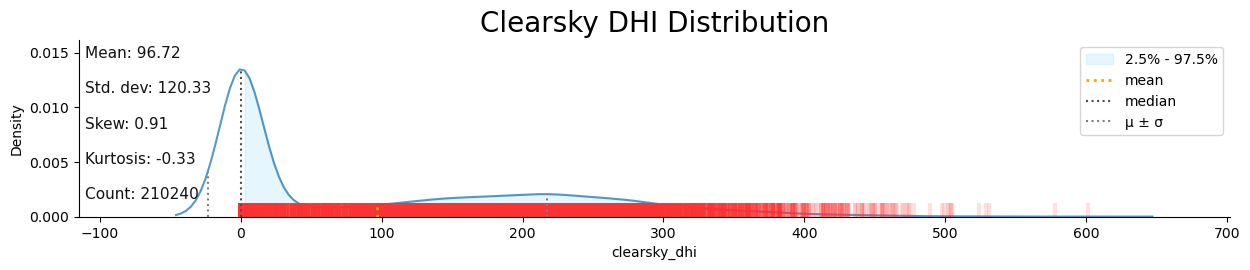

In [11]:
klib.dist_plot(train['clearsky_dhi']);
plt.title("Clearsky DHI Distribution",fontsize=20);

In [12]:
def box_plot(df,col,title=""):
  _=plt.figure(figsize=(8,6))
  _=sns.boxplot(y=df[col],color="Green")
  _=plt.title(col.capitalize()+ " Distribution",fontsize=25)
  _=plt.ylabel(col,fontsize=20)
  _=plt.yticks(fontsize=14)

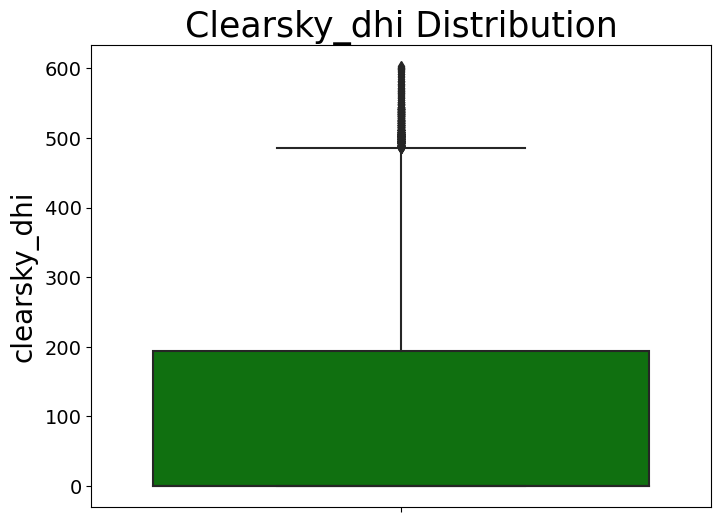

In [13]:
box_plot(train,'clearsky_dhi')

In [14]:
train['clearsky_dhi'].describe()

count    210240.000000
mean         96.720681
std         120.334380
min           0.000000
25%           0.000000
50%           0.000000
75%         194.000000
max         603.000000
Name: clearsky_dhi, dtype: float64

#### The above histogram explains that the Clearsky_DHI columns is positively(right) skewed.

#### The average clearsky_dhi is 53.07.

#### The median zero tells that more than half of a column value is zero.

#### The Clearsky_DHI ranges from 0.0 to 603.0.

#### The above boxplot expains that there are outliers above the third quartile.

### Let's see Clearsky_DNI column distribution.

#### Diffused Normal Irradiance represents the amount of light that is coming perpendicular to the surface. The surface here represents ground or something parallel to ground.

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


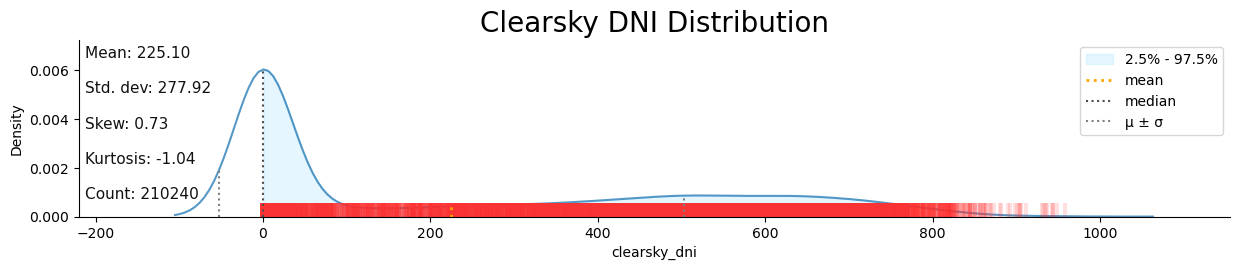

In [15]:
klib.dist_plot(train['clearsky_dni']);
plt.title("Clearsky DNI Distribution",fontsize=20);

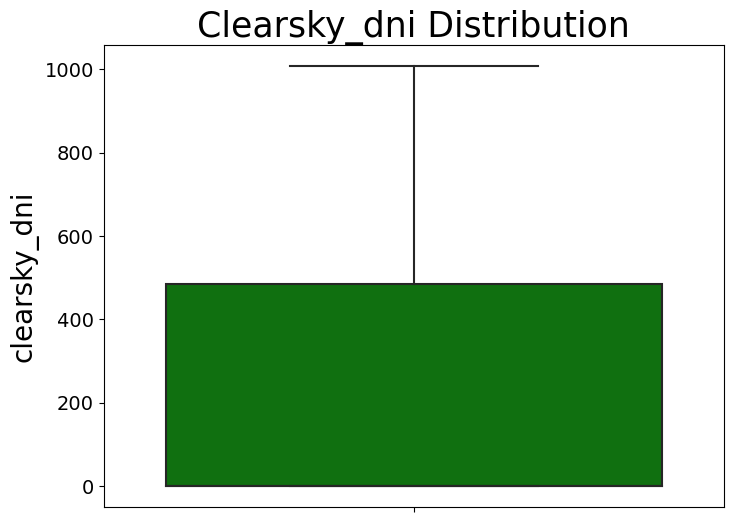

In [16]:
box_plot(train,'clearsky_dni')

In [17]:
train['clearsky_dni'].describe()

count    210240.000000
mean        225.098992
std         277.920322
min           0.000000
25%           0.000000
50%           0.000000
75%         486.000000
max        1008.000000
Name: clearsky_dni, dtype: float64

#### The above histogram explains that the Clearsky_DNI columns is positively(right) skewed.

#### The average clearsky_dni is 225.1.

#### The median zero tells that more than half of a column value is zero.

#### The Clearsky_DNI ranges from 0.0 to 1008.

#### The above boxplot expains that there are no outliers.

### Let's see Clearsky_GHI column distribution.

### Global Horizontal Irradiance (GHI) is the total irradiance from the sun on a horizontal surface on Earth. It is the sum of direct irradiance and diffuse horizontal irradiance.


### DHI+DNI+cos(z) 

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


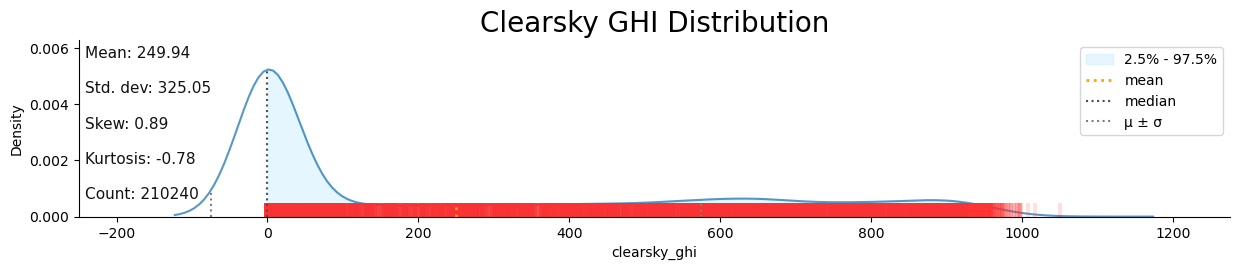

In [18]:
klib.dist_plot(train['clearsky_ghi']);
plt.title("Clearsky GHI Distribution",fontsize=20);

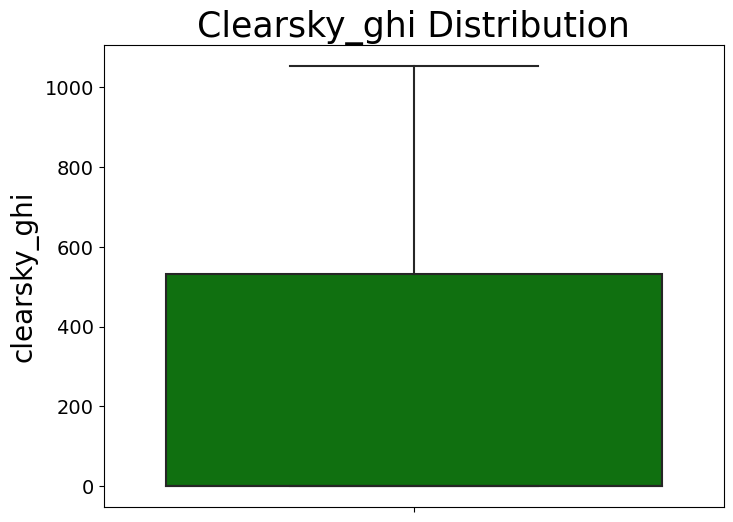

In [19]:
box_plot(train,'clearsky_ghi')

In [20]:
train['clearsky_ghi'].describe()

count    210240.000000
mean        249.938537
std         325.049751
min           0.000000
25%           0.000000
50%           0.000000
75%         533.000000
max        1053.000000
Name: clearsky_ghi, dtype: float64

#### The above histogram explains that the Clearsky_GHI columns is positively(right) skewed.

#### The average clearsky_ghi is 249.94.

#### The median zero tells that more than half of a column value is zero.

#### The Clearsky_GHI ranges from 0.0 to 1053.0.

#### The above boxplot expains that there are no outliers.

### Let's see is there any correlation between the three target columns themselves.

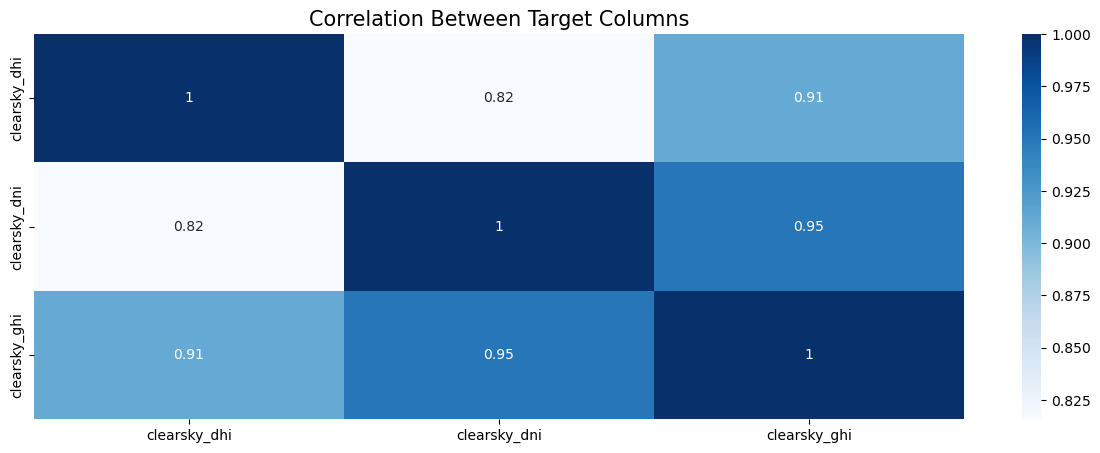

In [21]:
plt.figure(figsize=(15,5));
sns.heatmap(train.iloc[:,7:10].corr(),cmap='Blues',annot=True);
plt.title("Correlation Between Target Columns",fontsize=15);

#### The above heat map explains that the target columns are correlated within them.

### Let's see cloud type wise target columns distribution.


In [22]:
def count_plot(df,col,title="",size="",r=None,switch=False):
    _=plt.figure(figsize=size)
    if switch:
        _=sns.countplot(y=df[col],order=df[col].value_counts().index)
        _=plt.title(col+ " Distribution",fontsize=25)
        _=plt.ylabel(col,fontsize=20)
        _=plt.yticks(fontsize=14,rotation=r)
    else:
        _=sns.countplot(x=df[col],order=df[col].value_counts().index)
        _=plt.title(col+ " Distribution",fontsize=25)
        _=plt.xlabel(col,fontsize=20)
        _=plt.xticks(fontsize=14,rotation=r)

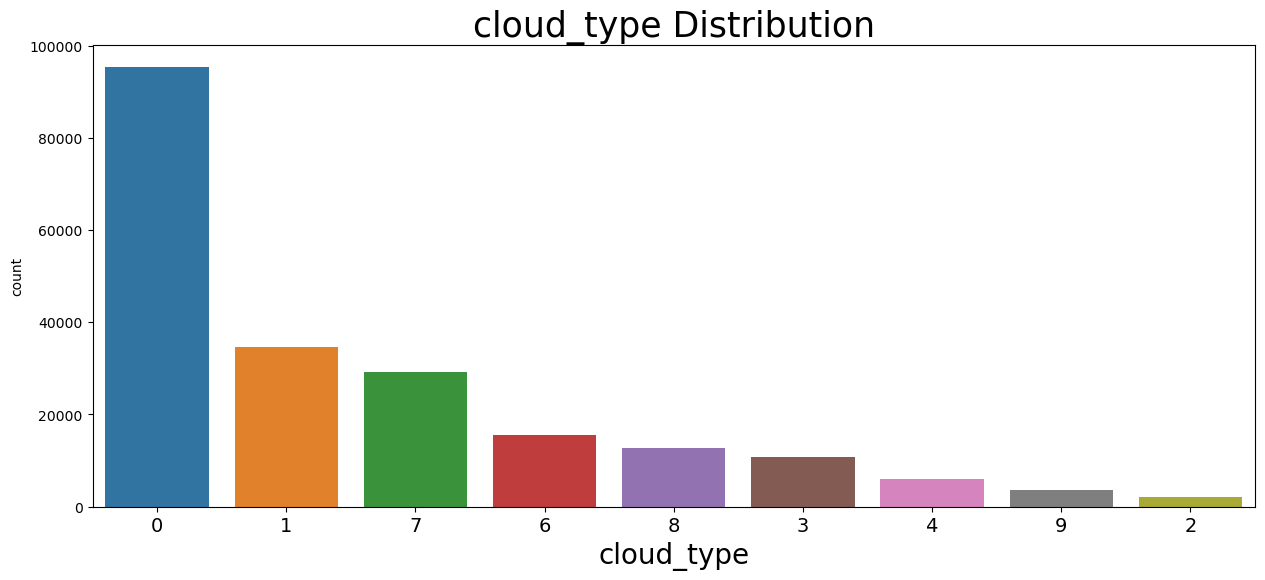

In [23]:
count_plot(train,'cloud_type',size=(15,6))

#### Most solar radiation data are from clear-type category 0.

### Let's see cloud type-wise solar irradiance distribution using a boxplot.

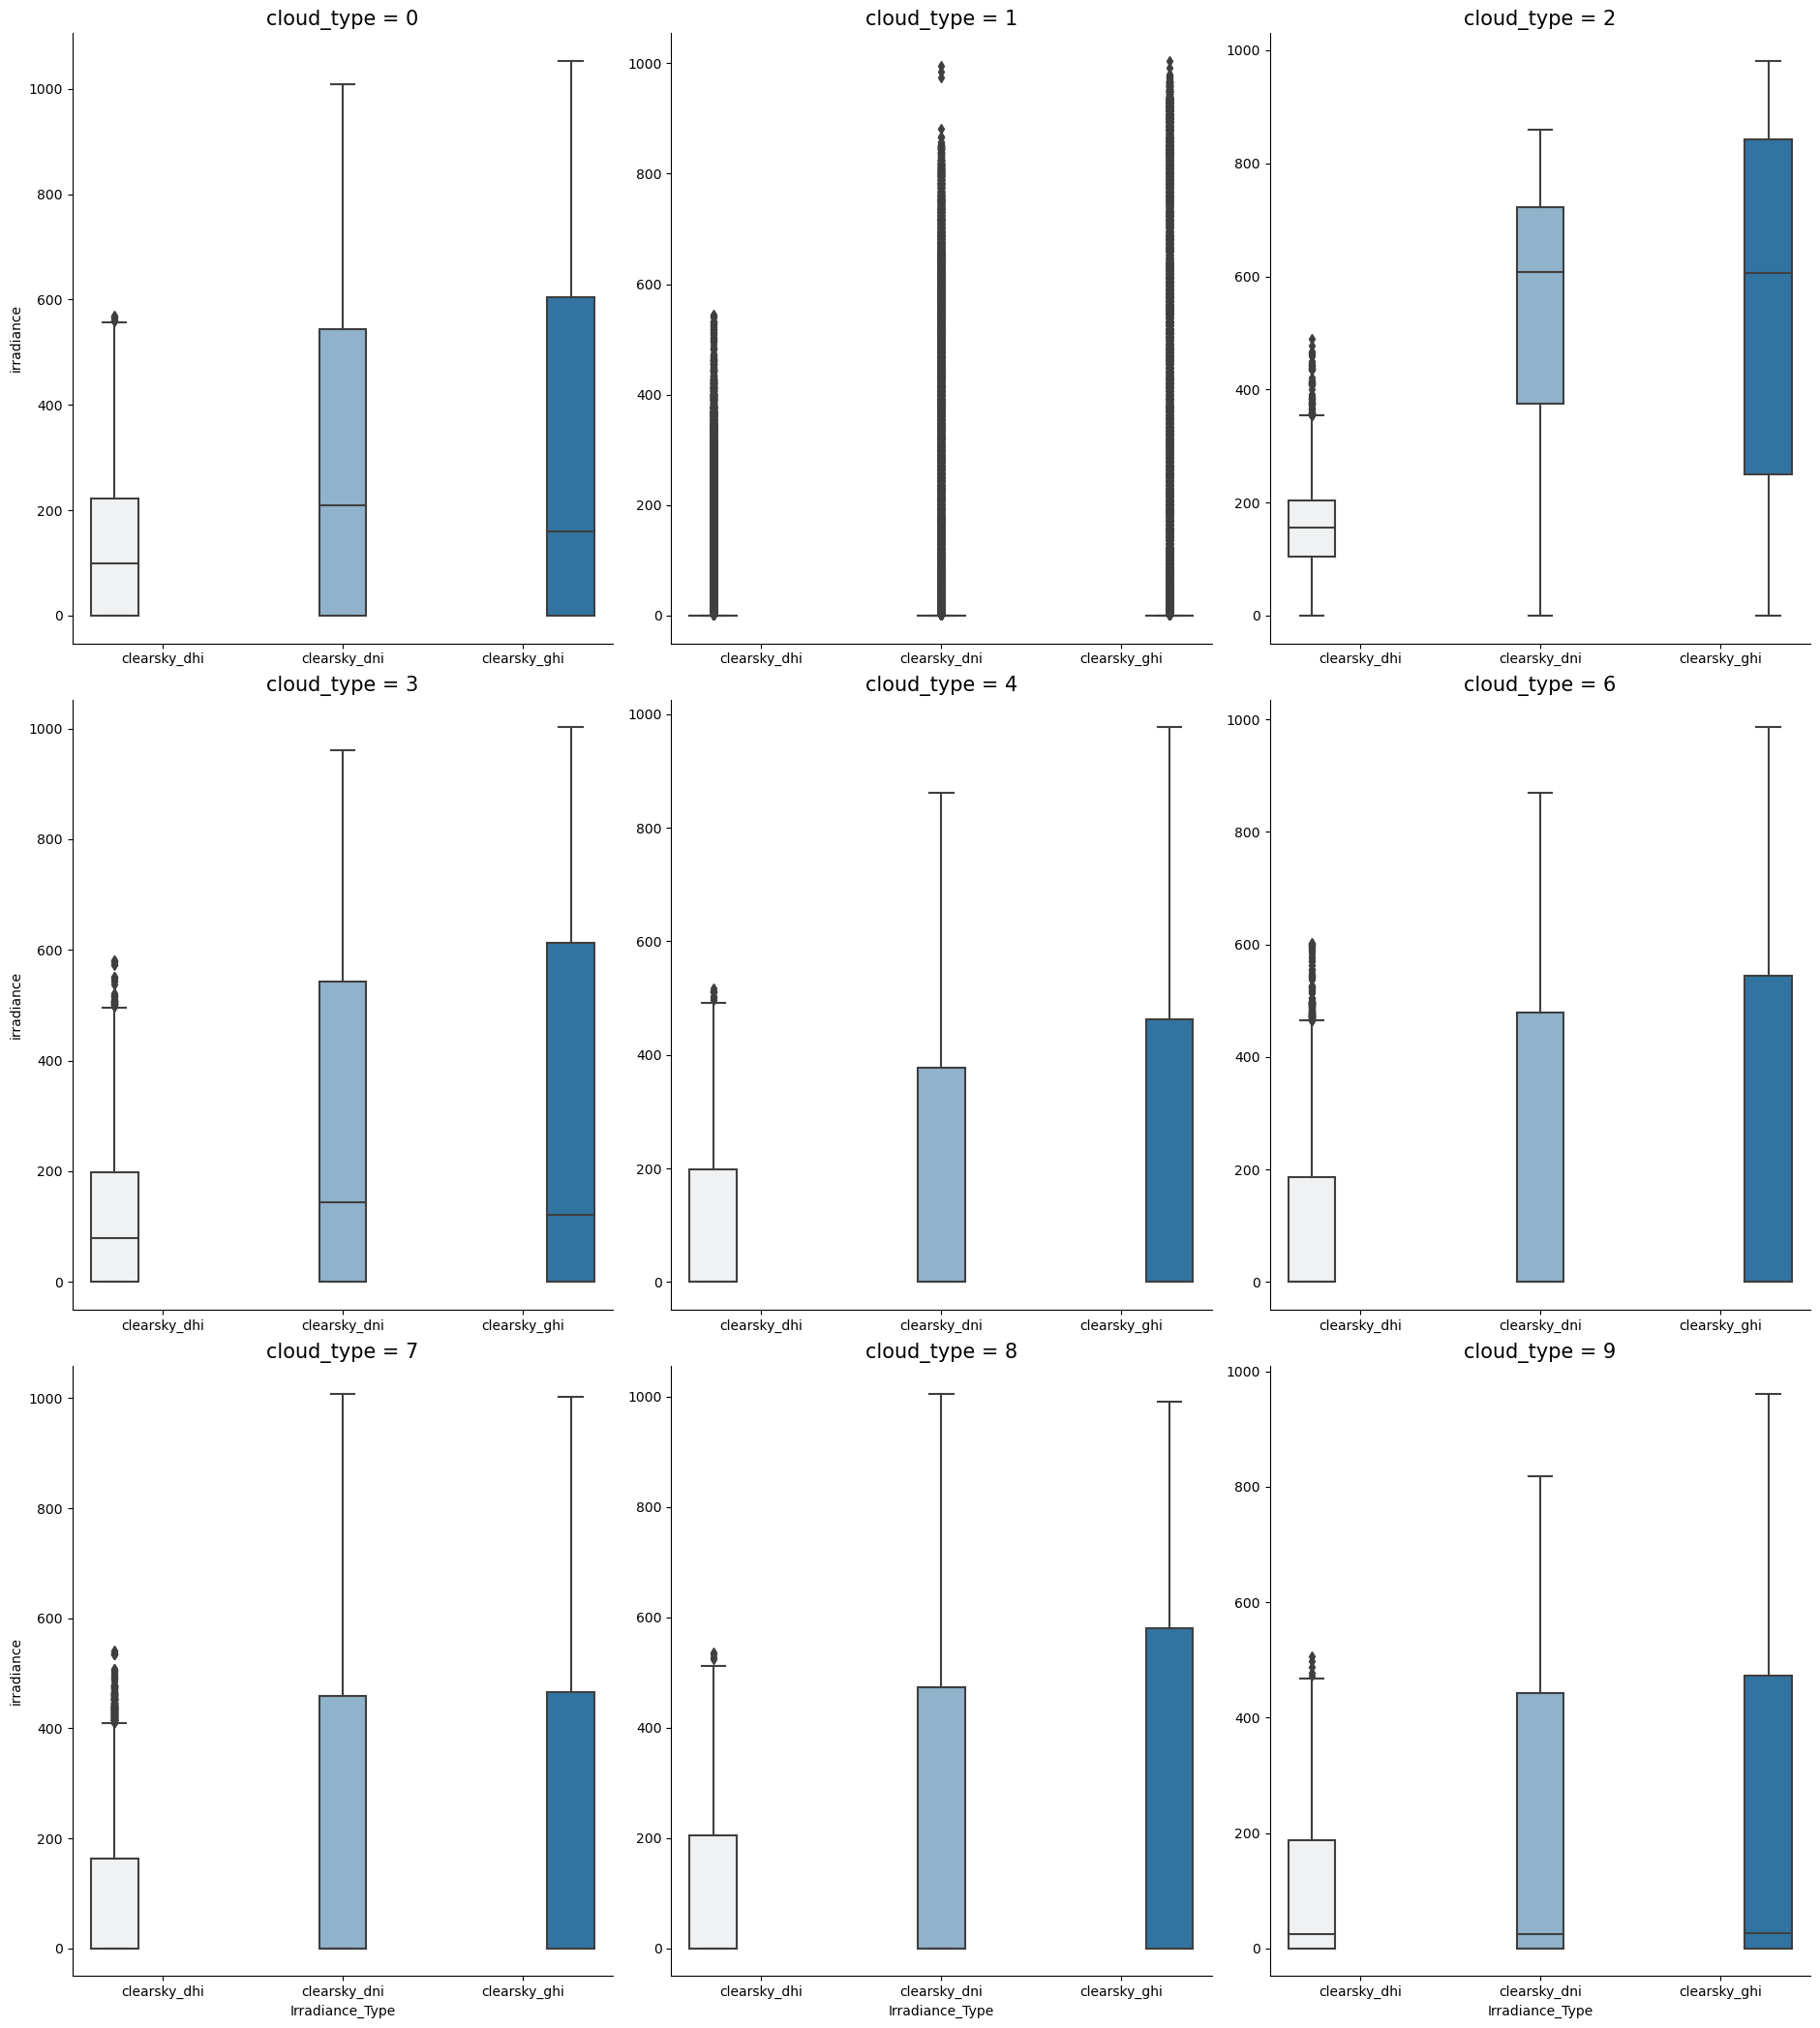

In [24]:
g = sns.FacetGrid(data=(pd.melt(train.iloc[:,np.r_[7:10,12]],value_vars=['clearsky_dhi','clearsky_dni','clearsky_ghi'],
                                id_vars='cloud_type',
        value_name='irradiance',var_name='Irradiance_Type')),col_wrap=3,
        col="cloud_type",margin_titles=True,height=7,aspect=.9,sharex=False,sharey=False);
g.map_dataframe(sns.boxplot, x='Irradiance_Type',y="irradiance",hue='Irradiance_Type');
g.set_titles(size=15);

### Let's see cloud type-wise solar irradiance distribution using a kernel density plot.

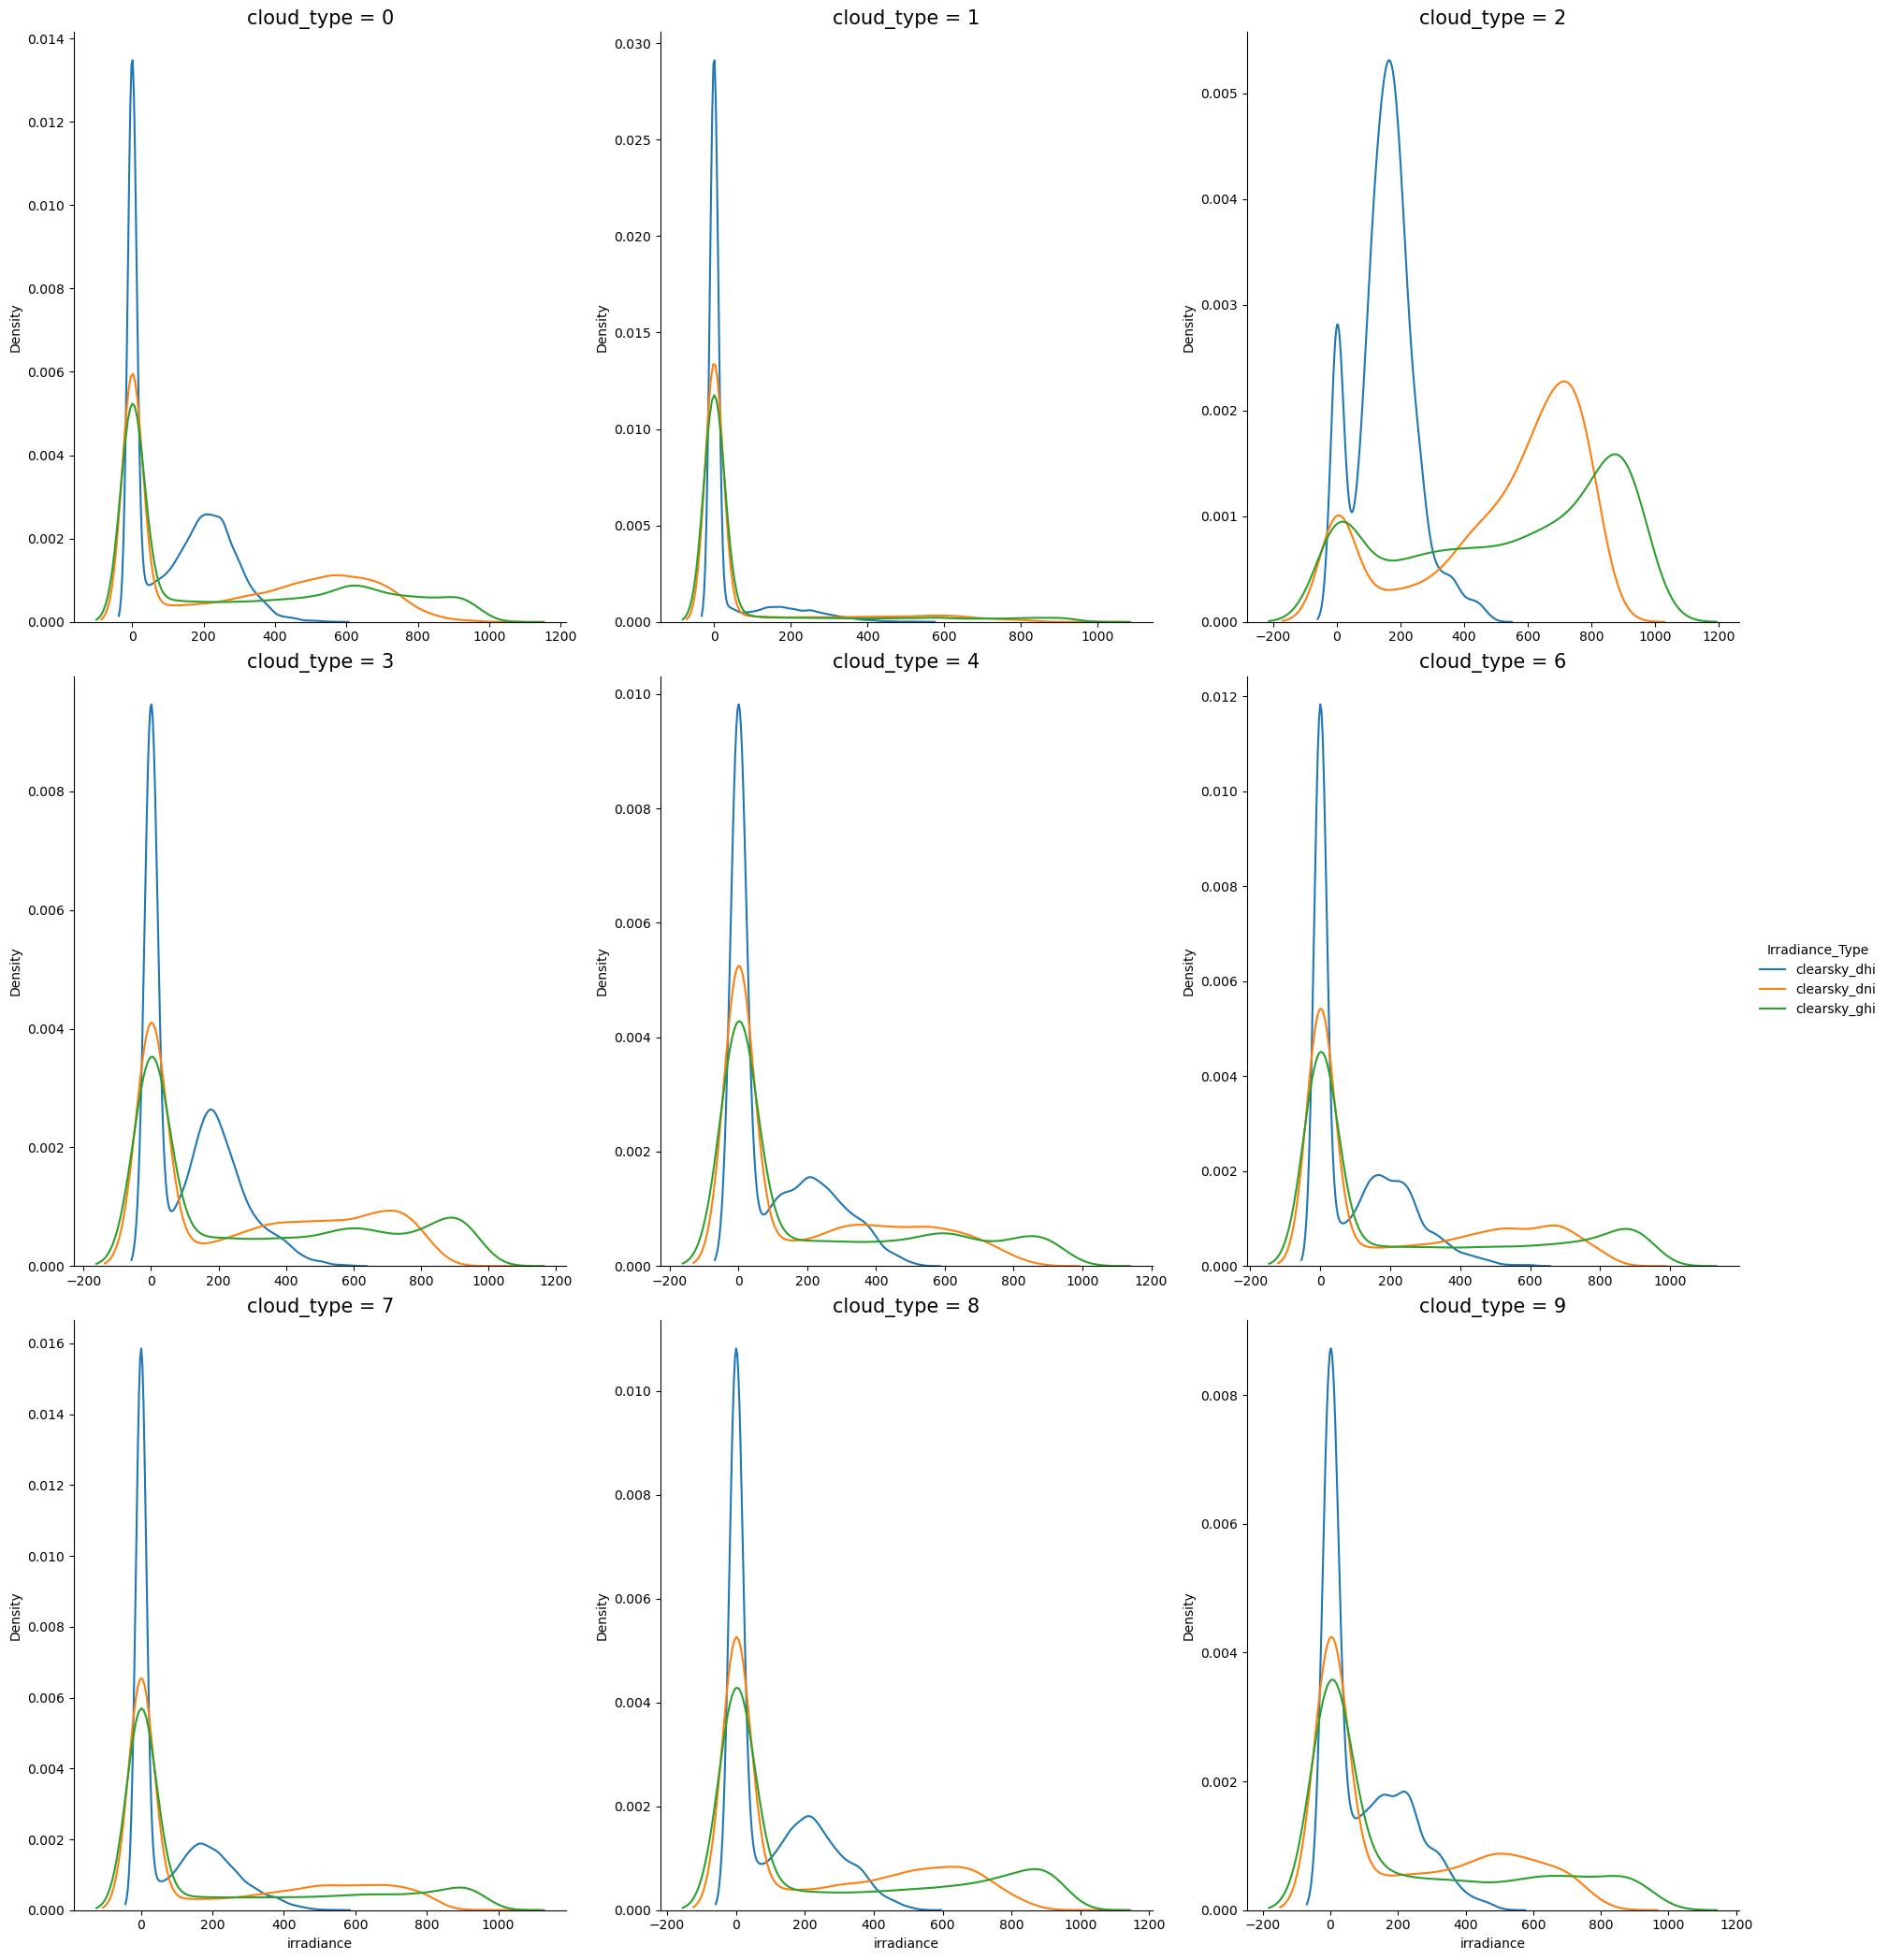

In [25]:
g = sns.FacetGrid(data=(pd.melt(train.iloc[:,np.r_[7:10,12]],value_vars=['clearsky_dhi','clearsky_dni','clearsky_ghi'],
                                id_vars='cloud_type',
        value_name='irradiance',var_name='Irradiance_Type')),col_wrap=3,
        col="cloud_type",hue='Irradiance_Type',
                  margin_titles=True,height=7,aspect=.9,legend_out=True,
                 sharex=False,sharey=False);
g.map_dataframe(sns.kdeplot, x="irradiance");
g.set_titles(size=15);
g.add_legend(loc='center right');

### Function to group by boxplot and density plot

In [26]:
def side_by_side_plot(df,grp,valcol,rot=None):
    clr="Paired"
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,8))
    fig.tight_layout()
    sns.kdeplot(x=df[valcol], hue=df[grp],ax=ax1,palette=clr)
    ax1.set_title(grp.capitalize()+" Wise "+valcol.capitalize()+" Distribution",size=15)
    ax1.set_xlabel(valcol,fontsize=20)
    sns.boxplot(x=df[grp],y=df[valcol],ax=ax2,palette=clr)
    ax2.set_title(grp.capitalize()+" Wise "+valcol.capitalize()+" Distribution",size=15)
    ax2.set_xlabel(grp,fontsize=20)
    ax2.tick_params(rotation=rot)

### Function to show group by summary

In [27]:
def group_summary(df,groupcol,value):
    return df.groupby(groupcol)[value].describe().reset_index().sort_values('mean',ascending=False)

### Let's see Temperature distribution.

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


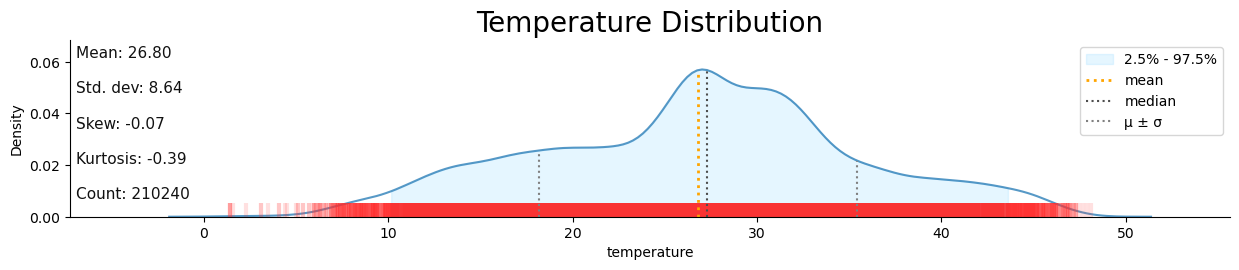

In [28]:
klib.dist_plot(train['temperature']);
plt.title("Temperature Distribution",fontsize=20);


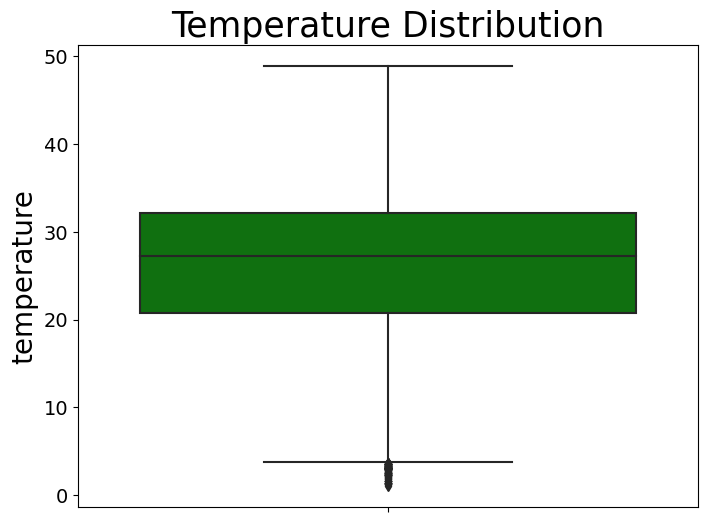

In [29]:
box_plot(train,'temperature')

In [30]:
train['temperature'].describe()

count    210240.000000
mean         26.795495
std           8.639162
min           1.000000
25%          20.800000
50%          27.300000
75%          32.200000
max          48.900000
Name: temperature, dtype: float64

#### The above histogram explains that the Temperature column is slightly left skewed.

#### The average temperature is 26.8 degree celsius.

#### The Temperature ranges from 1 to 49.9 degree celsius.

#### The above boxplot expains that there are  outliers below the first quartile.

### Let's see cloud type-wise temperature distribution.

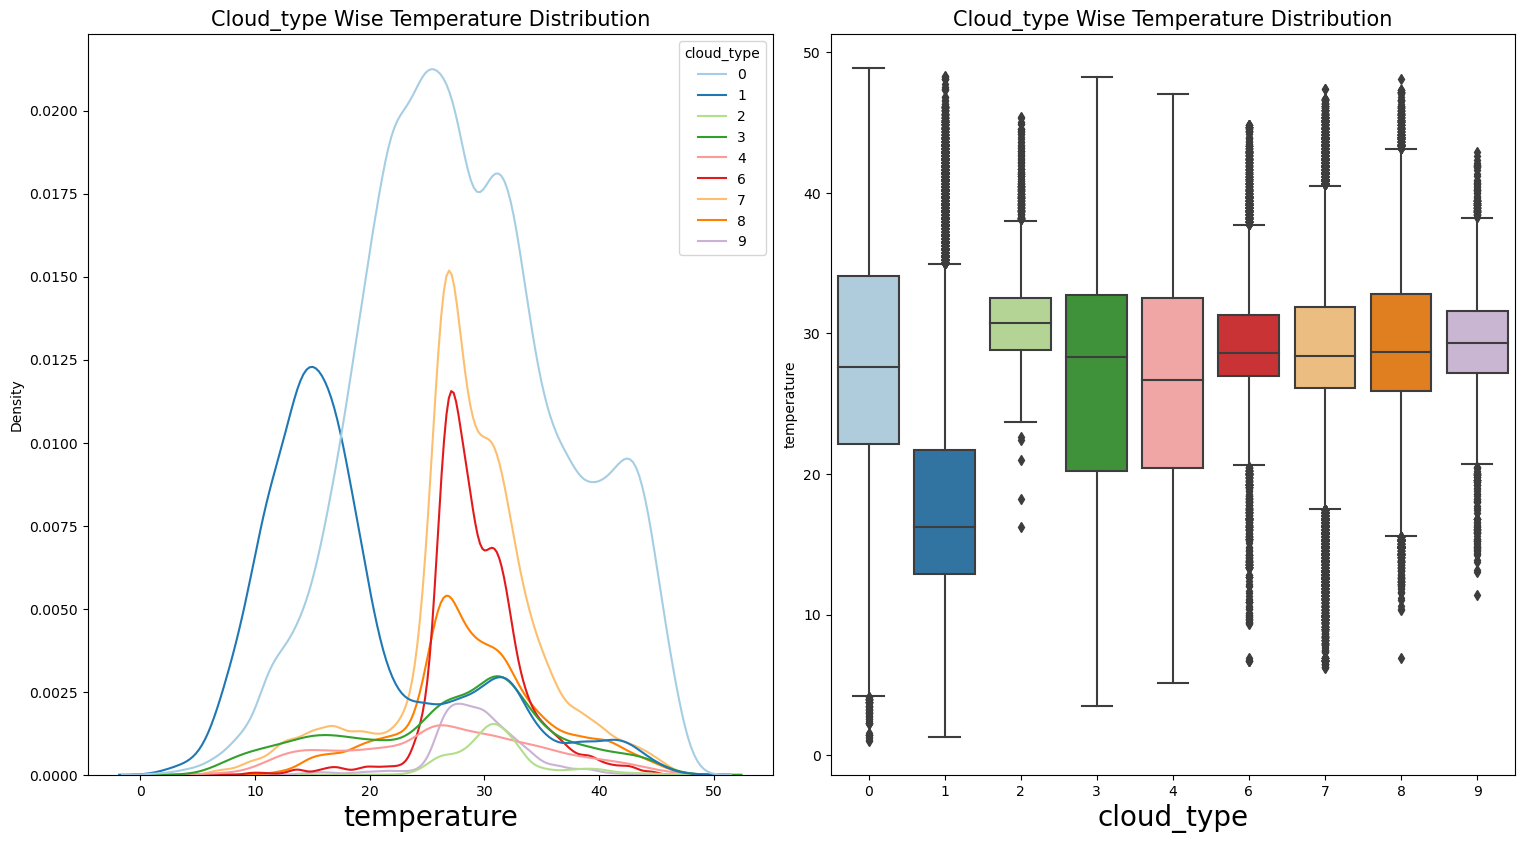

In [31]:
side_by_side_plot(train,'cloud_type','temperature')

In [32]:
group_summary(train,'cloud_type','temperature')

cloud_type    count       mean       std   min   25%   50%   75%   max
2           2   2132.0  31.038086  3.813353  16.2  28.8  30.7  32.5  45.4
8           9   3593.0  29.454077  3.914771  11.4  27.2  29.3  31.6  42.9
7           8  12809.0  29.314755  6.295402   6.9  25.9  28.7  32.8  48.1
5           6  15662.0  29.246718  4.002606   6.7  27.0  28.6  31.3  44.8
6           7  29130.0  28.611716  6.179080   6.2  26.1  28.4  31.9  47.4
0           0  95418.0  28.288582  8.588535   1.0  22.1  27.6  34.1  48.9
3           3  10862.0  26.890425  9.014385   3.5  20.2  28.3  32.7  48.2
4           4   6095.0  26.586087  8.481603   5.1  20.4  26.7  32.5  47.0
1           1  34539.0  18.561719  8.482991   1.3  12.9  16.2  21.7  48.3

#### The highest average temperature recorded in cloud type 2.

### Let's see dew point distribution.

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


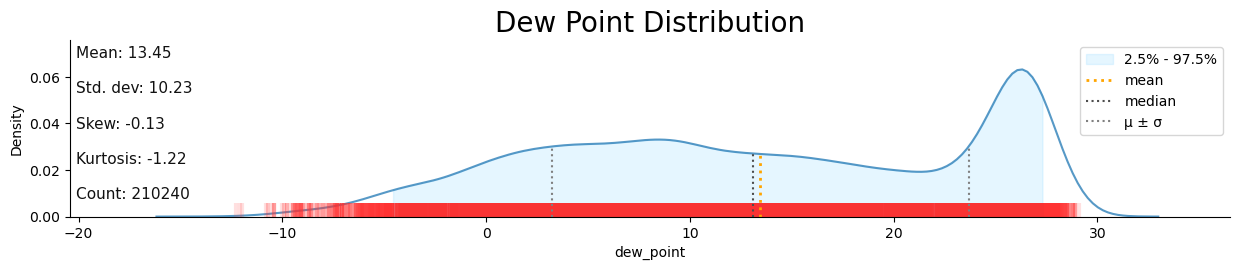

In [33]:
klib.dist_plot(train['dew_point']);
plt.title("Dew Point Distribution",fontsize=20);

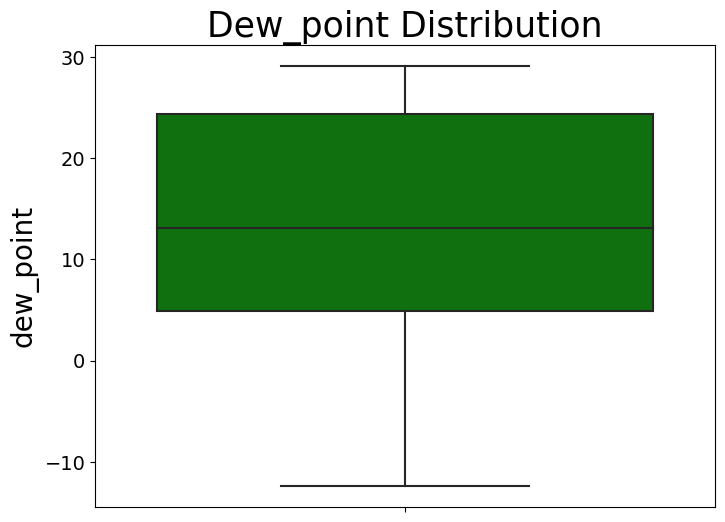

In [34]:
box_plot(train,'dew_point')

In [35]:
train['dew_point'].describe()

count    210240.000000
mean         13.447805
std          10.234861
min         -12.400000
25%           4.900000
50%          13.100000
75%          24.400000
max          29.100000
Name: dew_point, dtype: float64

#### The above histogram explains that the Dew_Point column is left skewed.

#### The average dew point is 13.45 degree celsius.

#### The Dew_Point ranges from -12.4 to 29.1 degree celsius.

#### The above boxplot expains that there is no outlier.


### Let's see cloud type-wise dew point distribution.

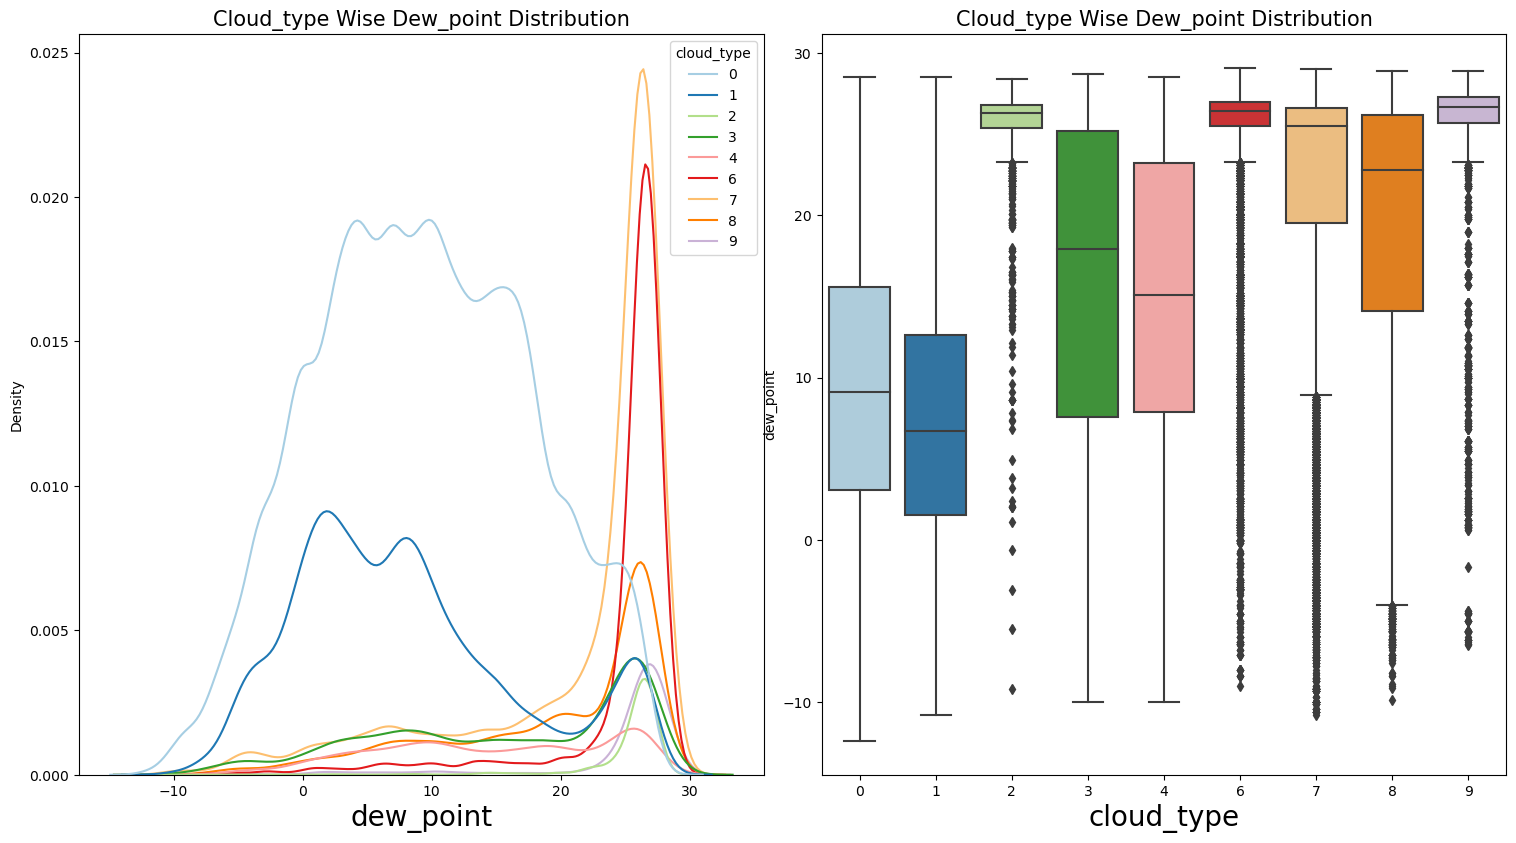

In [36]:
side_by_side_plot(train,'cloud_type','dew_point')

In [37]:
group_summary(train,'cloud_type','dew_point')

cloud_type    count       mean       std   min    25%   50%   75%   max
2           2   2132.0  25.399156  3.345340  -9.2  25.40  26.3  26.8  28.4
8           9   3593.0  24.692124  6.222894  -6.5  25.70  26.7  27.3  28.9
5           6  15662.0  24.638284  5.562276  -9.0  25.50  26.4  27.0  29.1
6           7  29130.0  21.393773  8.378098 -10.8  19.50  25.5  26.6  29.0
7           8  12809.0  19.335522  8.500939  -9.9  14.10  22.8  26.2  28.9
3           3  10862.0  15.791466  9.894473 -10.0   7.60  17.9  25.2  28.7
4           4   6095.0  14.716981  8.839803 -10.0   7.85  15.1  23.2  28.5
0           0  95418.0   9.332768  8.300180 -12.4   3.10   9.1  15.6  28.5
1           1  34539.0   7.988118  8.633098 -10.8   1.50   6.7  12.6  28.5

### The highest average dewpoint in the cloud types 2, 6, and 9.

### Let's see surface_albedo distribution.
### Surface albedo refers to fraction of solar radiation reflected by surface(building,ground).
### Surface albedo value ranges from 0 to 1.
### 0 represents perfectly absorbing surface that reflects no radiation.
### 1 represents perfectly refelcting surface that reflects all radiation.


Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


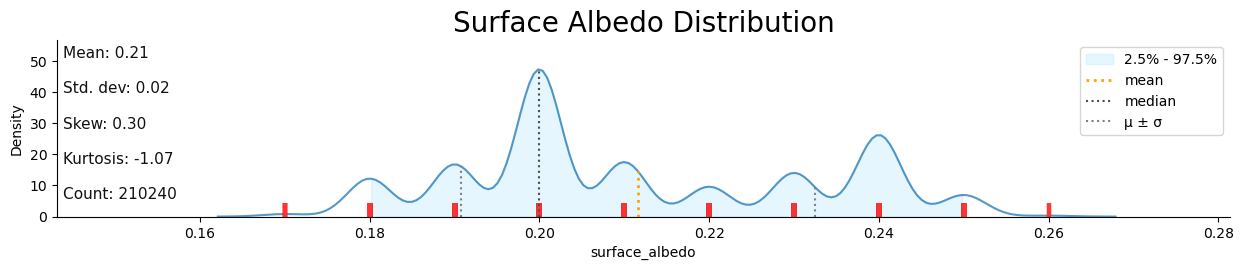

In [38]:
klib.dist_plot(train['surface_albedo']);
plt.title("Surface Albedo Distribution",fontsize=20);

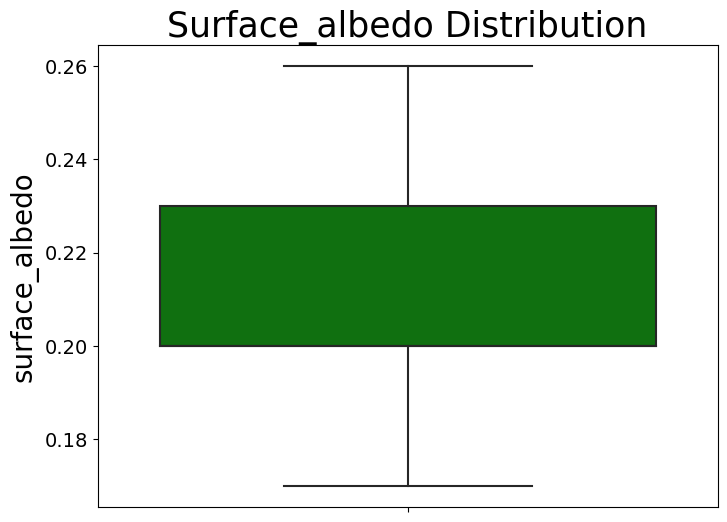

In [39]:
box_plot(train,'surface_albedo')

In [40]:
train['surface_albedo'].describe()

count    210240.000000
mean          0.211623
std           0.020889
min           0.170000
25%           0.200000
50%           0.200000
75%           0.230000
max           0.260000
Name: surface_albedo, dtype: float64

#### The above histogram explains that the surface albedo column is right skewed but there are more than one peaks(mode).

#### The average surface albedo is 1.57.

#### The above boxplot expains that there no outlier.

### Let's see cloud type-wise surface albedo distribution.

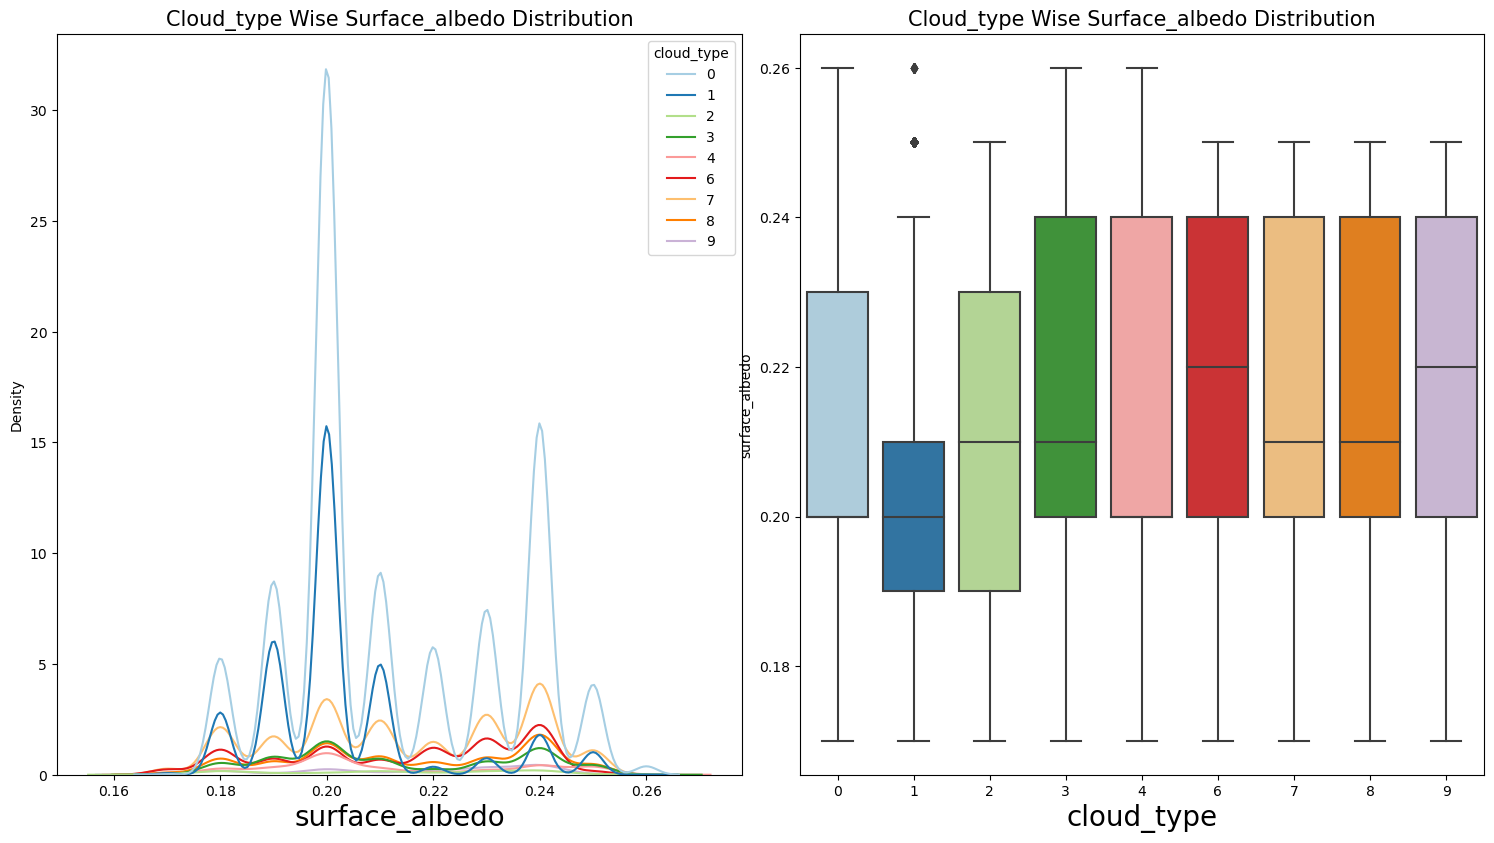

In [41]:
side_by_side_plot(train,'cloud_type','surface_albedo')

In [42]:
group_summary(train,'cloud_type','surface_albedo')

cloud_type    count      mean       std   min   25%   50%   75%   max
8           9   3593.0  0.216326  0.022876  0.17  0.20  0.22  0.24  0.25
7           8  12809.0  0.215869  0.022499  0.17  0.20  0.21  0.24  0.25
5           6  15662.0  0.215154  0.022315  0.17  0.20  0.22  0.24  0.25
6           7  29130.0  0.214758  0.022304  0.17  0.20  0.21  0.24  0.25
3           3  10862.0  0.213297  0.022210  0.17  0.20  0.21  0.24  0.26
2           2   2132.0  0.212556  0.022870  0.17  0.19  0.21  0.23  0.25
0           0  95418.0  0.212389  0.020231  0.17  0.20  0.20  0.23  0.26
4           4   6095.0  0.212269  0.022957  0.17  0.20  0.20  0.24  0.26
1           1  34539.0  0.202502  0.015771  0.17  0.19  0.20  0.21  0.26

#### The above plot explains that in all types of clouds, the surface is perfectly absorbing that reflects no radiation.

### Let's see Pressure distribution.

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


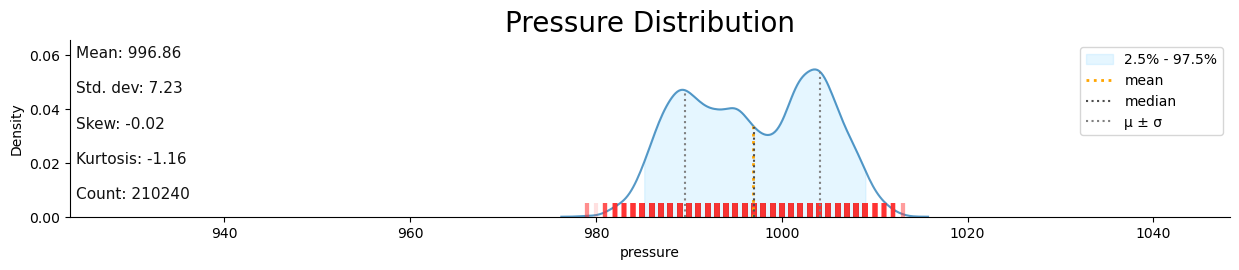

In [43]:
klib.dist_plot(train['pressure']);
plt.title("Pressure Distribution",fontsize=20);

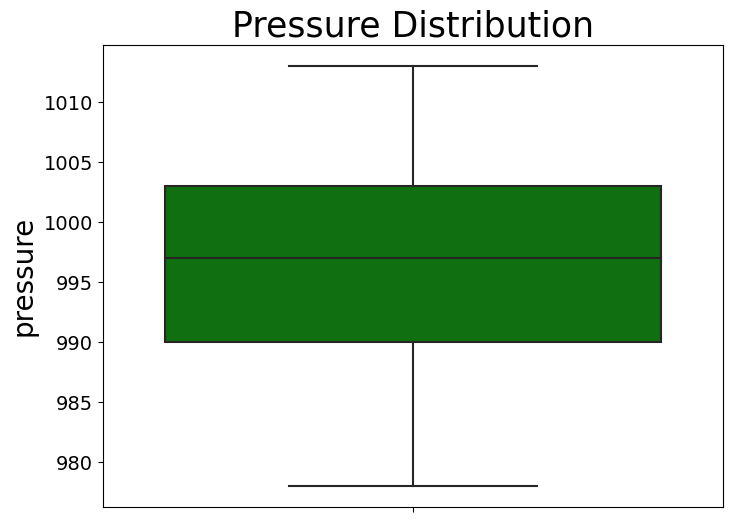

In [44]:
box_plot(train,'pressure')

In [45]:
train['pressure'].describe()

count    210240.000000
mean        996.856141
std           7.226820
min         978.000000
25%         990.000000
50%         997.000000
75%        1003.000000
max        1013.000000
Name: pressure, dtype: float64

#### The above histogram explains that the Pressure column is slightly left skewed.
#### The average pressure is 996.9 Hectopascals.
#### The Pressure ranges from 978.0 to 1013.0 Hectopascals.
#### The above boxplot expains that there is no outlier.

### Let's see cloud type-wise pressure distribution.

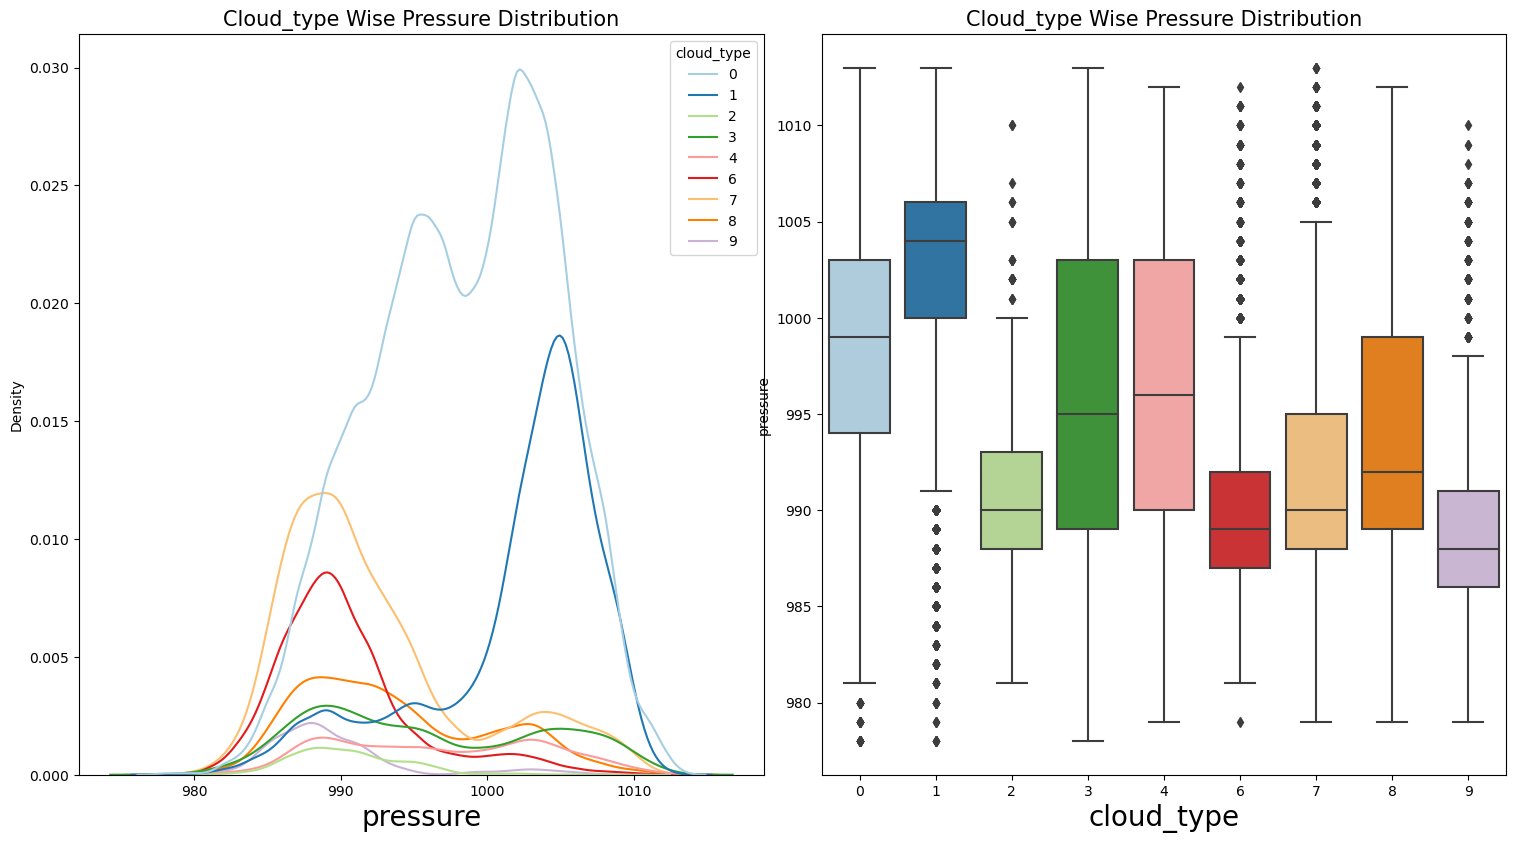

In [46]:
side_by_side_plot(train,'cloud_type','pressure')

In [47]:
group_summary(train,'cloud_type','pressure')

cloud_type    count         mean       std    min     25%     50%     75%  \
1           1  34539.0  1001.956397  6.105952  978.0  1000.0  1004.0  1006.0   
0           0  95418.0   998.456277  6.139892  978.0   994.0   999.0  1003.0   
4           4   6095.0   996.537326  7.088258  979.0   990.0   996.0  1003.0   
3           3  10862.0   995.936844  7.941068  978.0   989.0   995.0  1003.0   
7           8  12809.0   993.636662  6.433408  979.0   989.0   992.0   999.0   
6           7  29130.0   992.306488  6.537437  979.0   988.0   990.0   995.0   
2           2   2132.0   990.498124  3.796995  981.0   988.0   990.0   993.0   
5           6  15662.0   990.295556  4.826330  979.0   987.0   989.0   992.0   
8           9   3593.0   989.387698  4.858205  979.0   986.0   988.0   991.0   

      max  
1  1013.0  
0  1013.0  
4  1012.0  
3  1013.0  
7  1012.0  
6  1013.0  
2  1010.0  
5  1012.0  
8  1010.0

#### The above plot explains that in all cloud types, the pressure was higher and was in fair weather.

### Let's see Wind_Direction distribution.

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


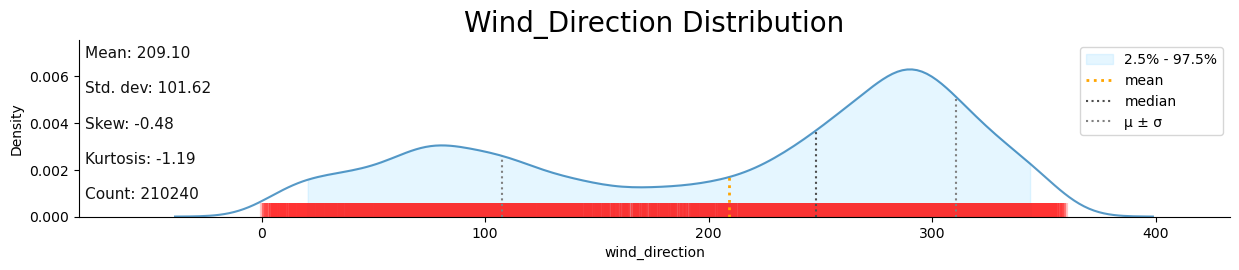

In [48]:
klib.dist_plot(train['wind_direction']);
plt.title("Wind_Direction Distribution",fontsize=20);

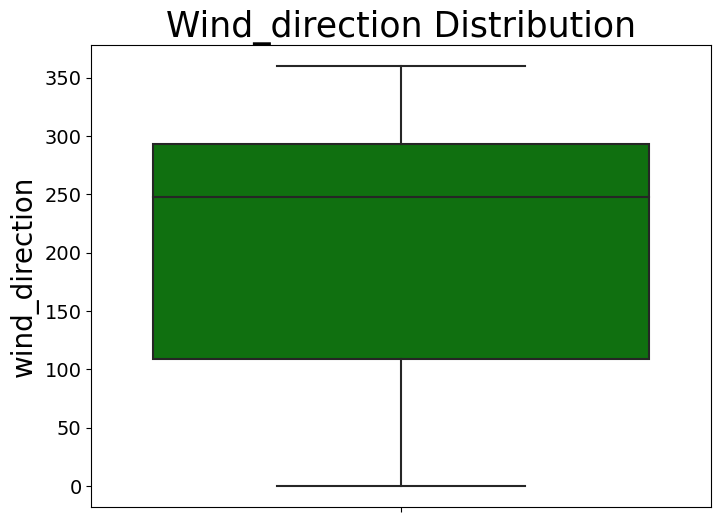

In [49]:
box_plot(train,'wind_direction')

In [50]:
train['wind_direction'].describe()

count    210240.000000
mean        209.095453
std         101.616108
min           0.000000
25%         109.000000
50%         248.000000
75%         293.000000
max         360.000000
Name: wind_direction, dtype: float64

#### The above histogram explains that the Wind_Direction column is left skewed.

#### The Wind_Direction mean is 209.1 degrees.

#### The Wind_Direction ranges from 0.0 to 360.0 degrees.

#### The above boxplot expains that there are no outlier.



### Let's see cloud type-wise wind_direction distribution.

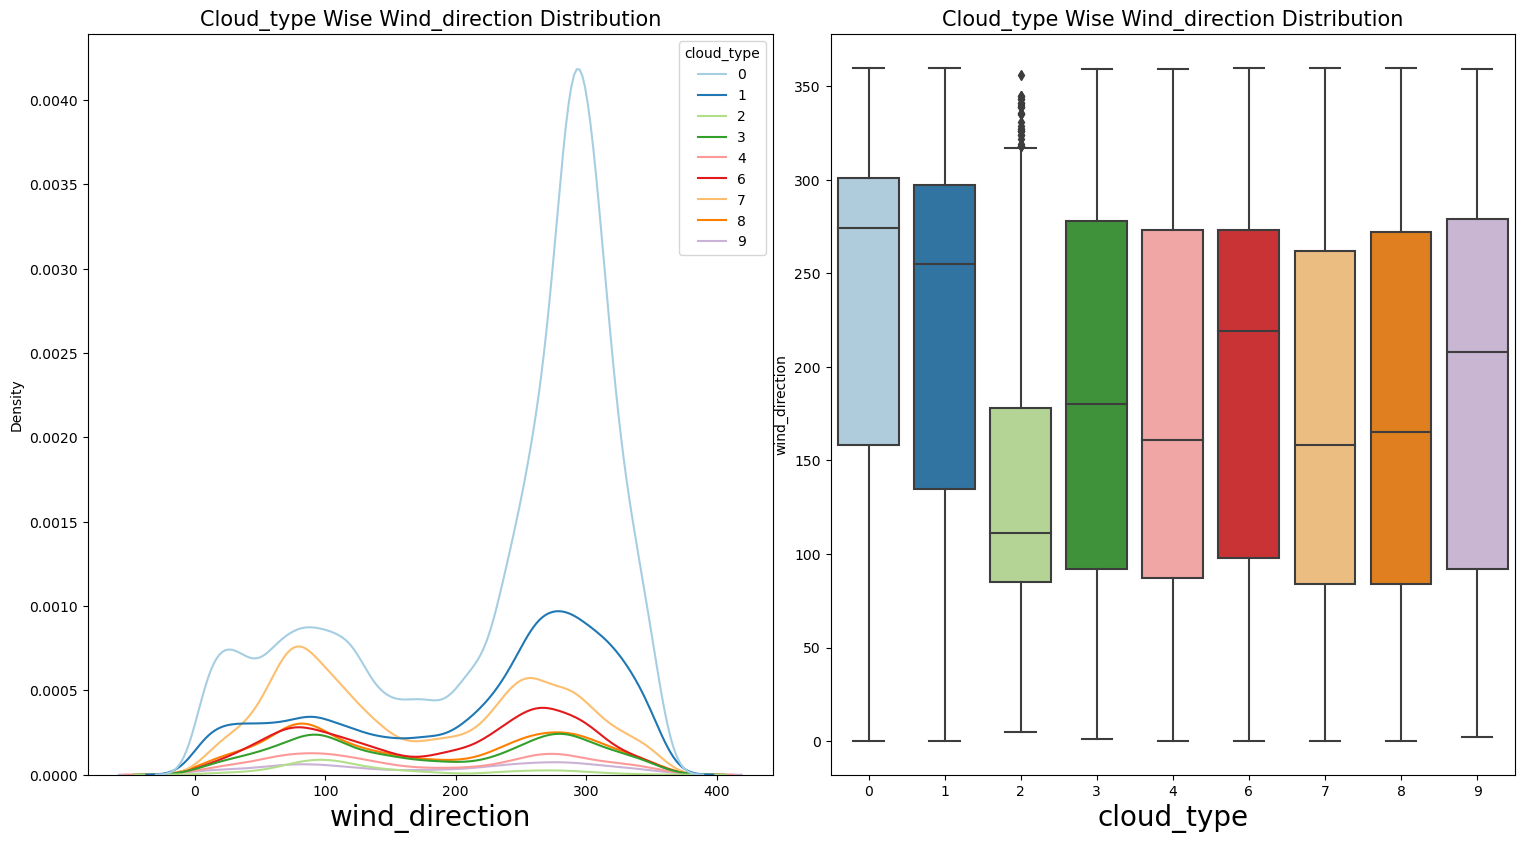

In [51]:
side_by_side_plot(train,'cloud_type','wind_direction')

In [52]:
group_summary(train,'cloud_type','wind_direction')

cloud_type    count        mean         std  min    25%    50%    75%  \
0           0  95418.0  230.845218   97.887301  0.0  158.0  274.0  301.0   
1           1  34539.0  219.049422  100.295307  0.0  135.0  255.0  297.0   
5           6  15662.0  191.809794   96.244911  0.0   98.0  219.0  273.0   
8           9   3593.0  187.716115  102.760293  2.0   92.0  208.0  279.0   
3           3  10862.0  183.767538  100.664271  1.0   92.0  180.0  278.0   
4           4   6095.0  177.177358  101.716832  0.0   87.0  161.0  273.0   
7           8  12809.0  176.728628  101.609718  0.0   84.0  165.0  272.0   
6           7  29130.0  173.460213   97.818367  0.0   84.0  158.0  262.0   
2           2   2132.0  139.075985   78.722698  5.0   85.0  111.0  178.0   

     max  
0  360.0  
1  360.0  
5  360.0  
8  359.0  
3  359.0  
4  359.0  
7  360.0  
6  360.0  
2  356.0

#### The above plot explains that in cloud type 2, the wind blew from the east-southeast to the south-southeast direction.

### Let's convert wind direction to cardinal direction.

In [53]:
train['cardinal_direction']=mpcalc.angle_to_direction(train['wind_direction'], full=True)

In [54]:
train['cardinal_direction']

0         East South East
1         East South East
2              South East
3              South East
4              South East
               ...       
210235         North East
210236         North East
210237         North East
210238         North East
210239         North East
Name: cardinal_direction, Length: 210240, dtype: object

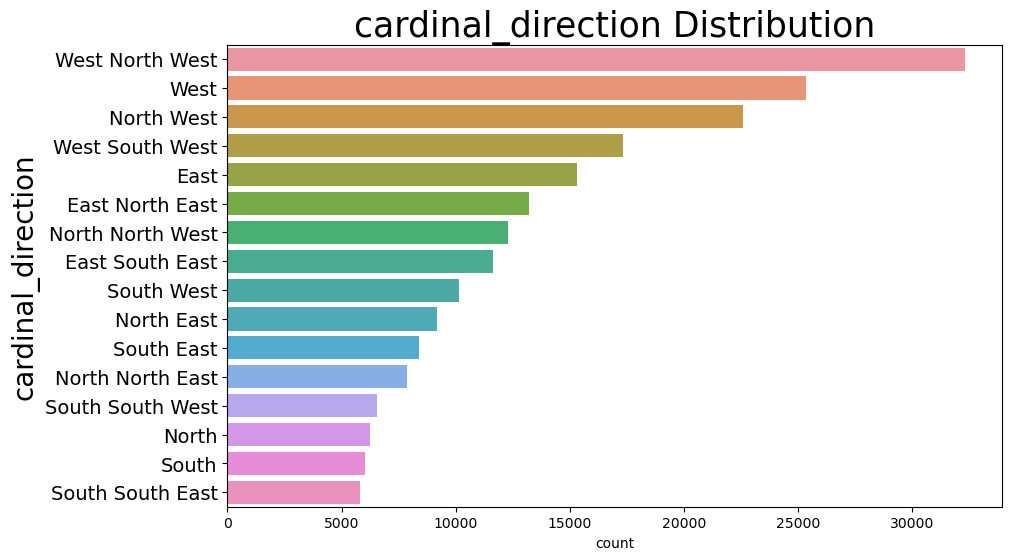

In [55]:
count_plot(train,'cardinal_direction',size=(10,6),switch=True)

#### The above plot explains that the high wind blew from the direction west north west, north west, and west.

### Let's see Wind_Speed distribution.

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


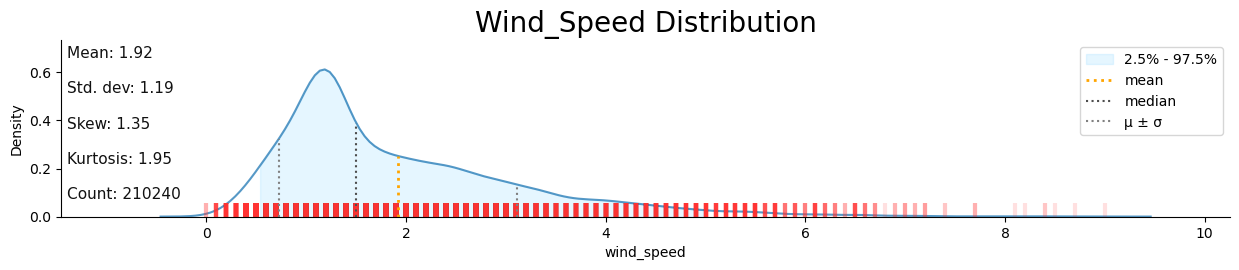

In [56]:
klib.dist_plot(train['wind_speed']);
plt.title("Wind_Speed Distribution",fontsize=20);

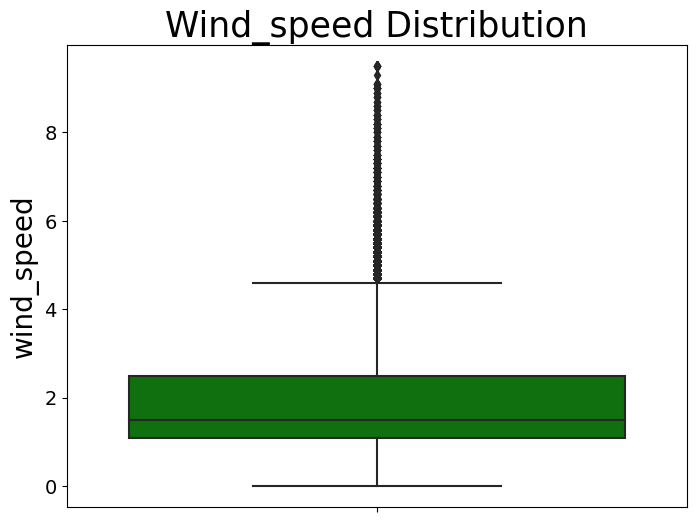

In [57]:
box_plot(train,'wind_speed');

In [58]:
train['wind_speed'].describe()

count    210240.000000
mean          1.918037
std           1.194954
min           0.000000
25%           1.100000
50%           1.500000
75%           2.500000
max           9.500000
Name: wind_speed, dtype: float64

#### The above histogram explains that the Wind_Speed column is positively skewed.

#### The average Wind_Speed is 1.92 Meters per second.

#### The Wind_Speed ranges from 0.0 to 9.50 Meters per second.

#### The above boxplot expains that there are outliers above the third quartile.

### Let's see cloud type-wise wind_speed distribution.

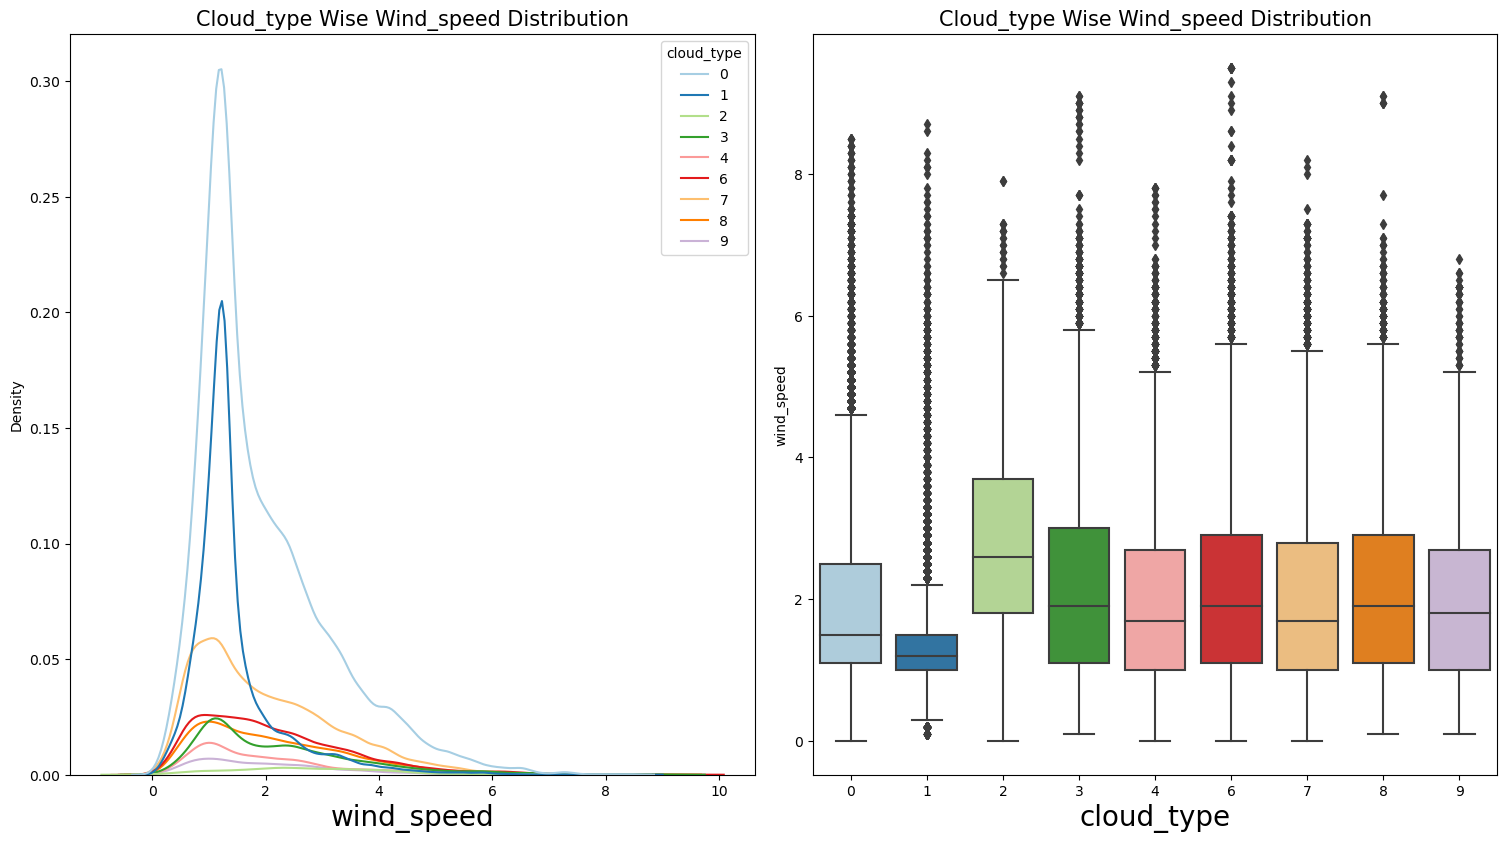

In [59]:
side_by_side_plot(train,'cloud_type','wind_speed')

In [60]:
group_summary(train,'cloud_type','wind_speed')

cloud_type    count      mean       std  min  25%  50%  75%  max
2           2   2132.0  2.772186  1.386579  0.0  1.8  2.6  3.7  7.9
3           3  10862.0  2.205993  1.388475  0.1  1.1  1.9  3.0  9.1
5           6  15662.0  2.141438  1.343171  0.0  1.1  1.9  2.9  9.5
7           8  12809.0  2.120486  1.283578  0.1  1.1  1.9  2.9  9.1
4           4   6095.0  2.059672  1.371746  0.0  1.0  1.7  2.7  7.8
6           7  29130.0  1.994243  1.240664  0.0  1.0  1.7  2.8  8.2
8           9   3593.0  1.986613  1.198875  0.1  1.0  1.8  2.7  6.8
0           0  95418.0  1.937620  1.163363  0.0  1.1  1.5  2.5  8.5
1           1  34539.0  1.447876  0.824236  0.1  1.0  1.2  1.5  8.7

#### The above plot explains that in all the cloud types, the wind speed was light.

### Let's see ozone distribution.

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


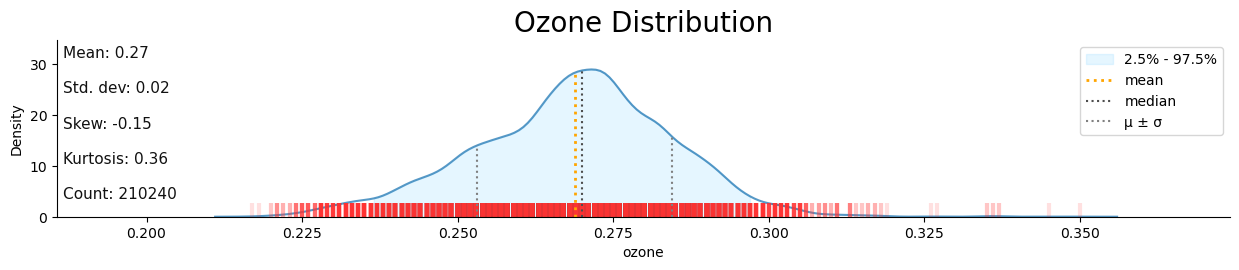

In [61]:
klib.dist_plot(train['ozone']);
plt.title("Ozone Distribution",fontsize=20);

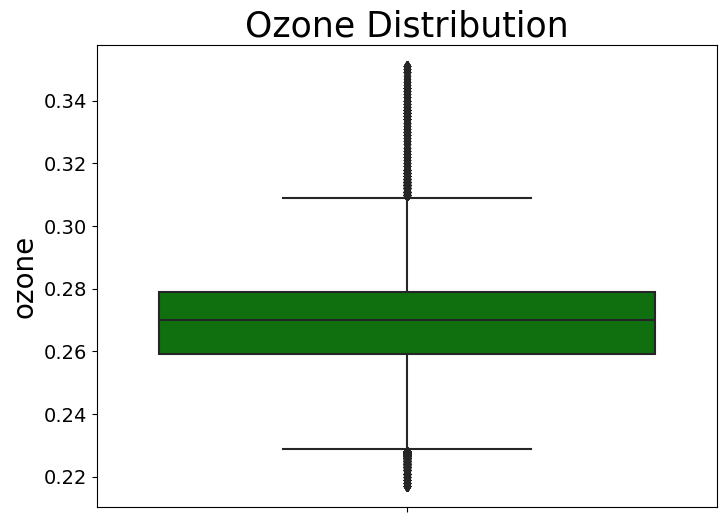

In [62]:
box_plot(train,'ozone')

In [63]:
train['ozone'].describe()

count    210240.000000
mean          0.268813
std           0.015632
min           0.217000
25%           0.259000
50%           0.270000
75%           0.279000
max           0.351000
Name: ozone, dtype: float64

#### The above histogram explains that the ozone column is normally distributed.

#### The average ozone dobson unit is 2.26.

#### The ozone value ranges from 0.217000 to 0.351000.

#### The above boxplot expains that there are outliers above the third quartile and below the first quartile.

### Let's see cloud type-wise ozone distribution.

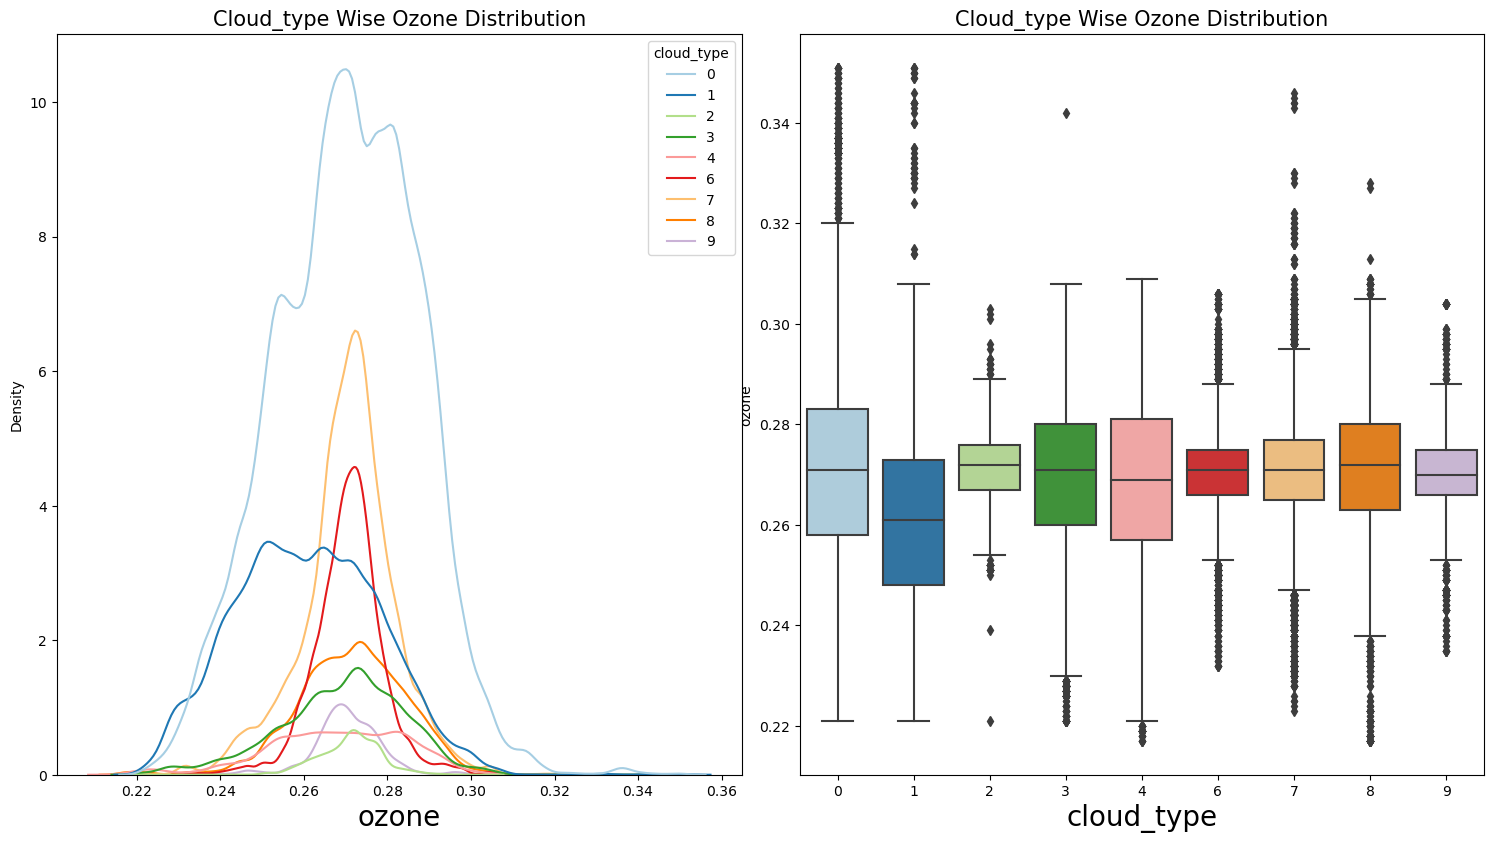

In [64]:
side_by_side_plot(train,'cloud_type','ozone')

In [65]:
group_summary(train,'cloud_type','ozone')

cloud_type    count      mean       std    min    25%    50%    75%    max
7           8  12809.0  0.271459  0.012913  0.217  0.263  0.272  0.280  0.328
2           2   2132.0  0.271136  0.007324  0.221  0.267  0.272  0.276  0.303
5           6  15662.0  0.270745  0.008265  0.232  0.266  0.271  0.275  0.306
6           7  29130.0  0.270659  0.011204  0.223  0.265  0.271  0.277  0.346
8           9   3593.0  0.270388  0.008484  0.235  0.266  0.270  0.275  0.304
0           0  95418.0  0.270343  0.016949  0.221  0.258  0.271  0.283  0.351
3           3  10862.0  0.269118  0.014972  0.221  0.260  0.271  0.280  0.342
4           4   6095.0  0.268038  0.016354  0.217  0.257  0.269  0.281  0.309
1           1  34539.0  0.260908  0.017023  0.221  0.248  0.261  0.273  0.351

#### The above plot explains that in all the cloud types, the ozone DU level was low or very low.

### Let's see Relative_Humidity distribution.

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


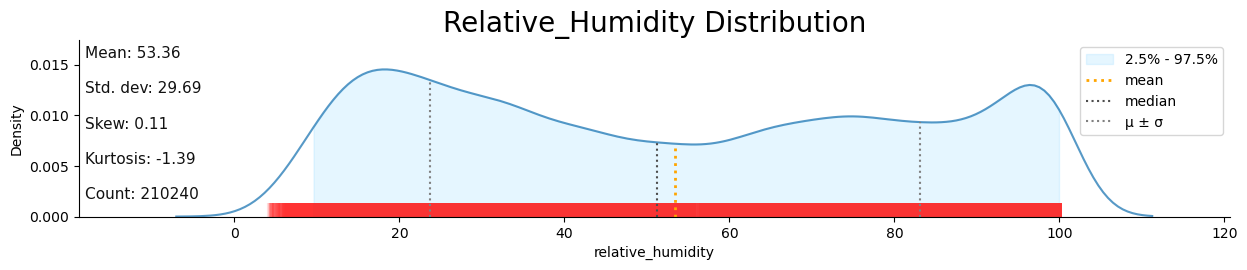

In [66]:
klib.dist_plot(train['relative_humidity']);
plt.title("Relative_Humidity Distribution",fontsize=20);

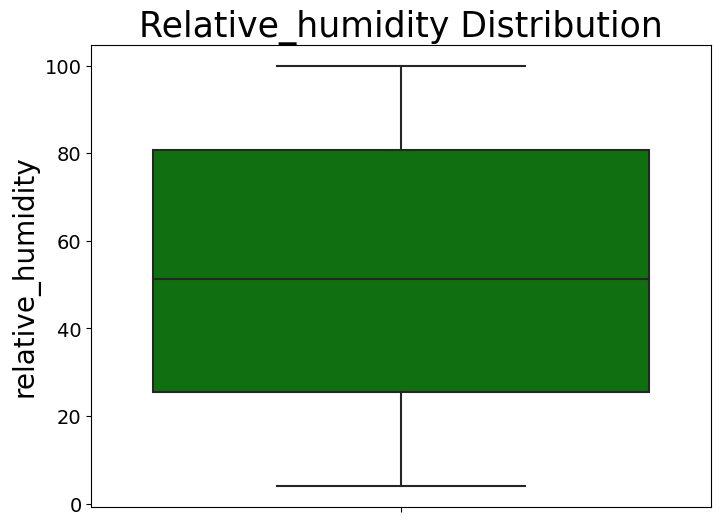

In [67]:
box_plot(train,'relative_humidity')

In [68]:
train['relative_humidity'].describe()

count    210240.000000
mean         53.364443
std          29.692608
min           4.100000
25%          25.540000
50%          51.210000
75%          80.820000
max         100.000000
Name: relative_humidity, dtype: float64

#### The above histogram explains that the Relative_Humidity column looks normally distributed but there are two peaks(mod).

#### The average Relative_Humidity is 53.4.

#### The Relative_Humidity ranges from 4.10 to 100.0

#### The above boxplot expains that there is no outlier.

### Let's see cloud type-wise relative_humidity distribution.

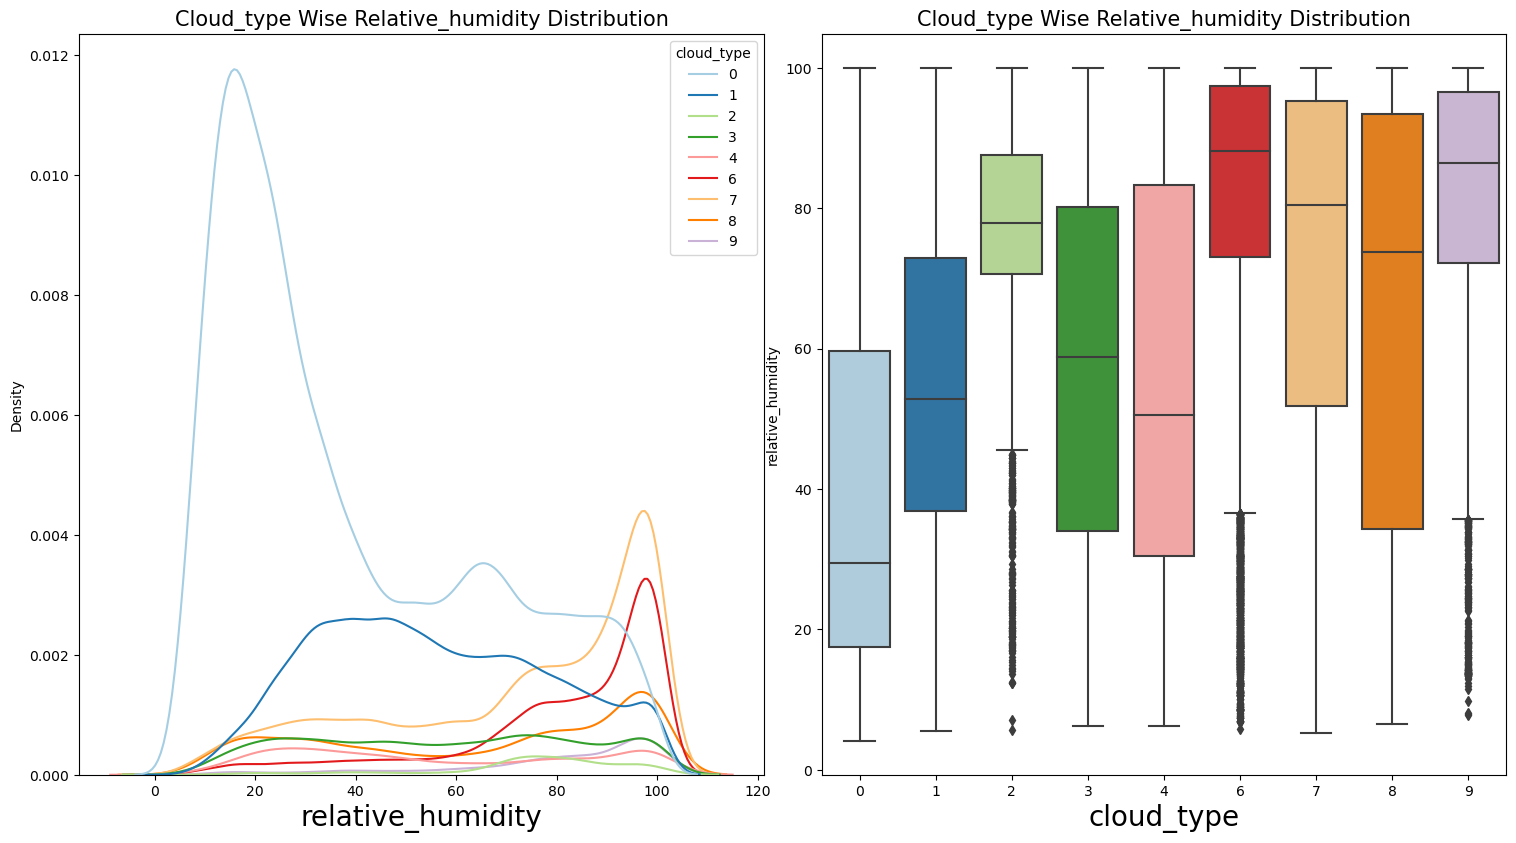

In [69]:
side_by_side_plot(train,'cloud_type','relative_humidity')

In [70]:
group_summary(train,'cloud_type','relative_humidity')

cloud_type    count       mean        std   min      25%     50%      75%  \
5           6  15662.0  80.739296  21.594636  5.87  73.0100  88.080  97.3400   
8           9   3593.0  79.866618  21.666104  7.87  72.2100  86.350  96.5600   
2           2   2132.0  75.574531  18.741317  5.67  70.6100  77.905  87.6025   
6           7  29130.0  71.932599  26.709748  5.28  51.7625  80.440  95.2600   
7           8  12809.0  64.314366  30.291509  6.55  34.3300  73.780  93.4600   
3           3  10862.0  57.765868  26.582884  6.19  34.0825  58.760  80.1450   
4           4   6095.0  56.110407  28.593688  6.19  30.4500  50.460  83.3100   
1           1  34539.0  55.197981  22.751090  5.53  36.8700  52.810  72.8800   
0           0  95418.0  38.898194  26.164284  4.10  17.4700  29.450  59.5800   

     max  
5  100.0  
8  100.0  
2  100.0  
6  100.0  
7  100.0  
3  100.0  
4  100.0  
1  100.0  
0  100.0

#### The above plot explains that in all the cloud types except cloud type 0, the relative humidity level was high.

### Let's see Solar_Zenith_Angle distribution.

#### The solar zenith angle is the angle between the sun's rays and the vertical direction.

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


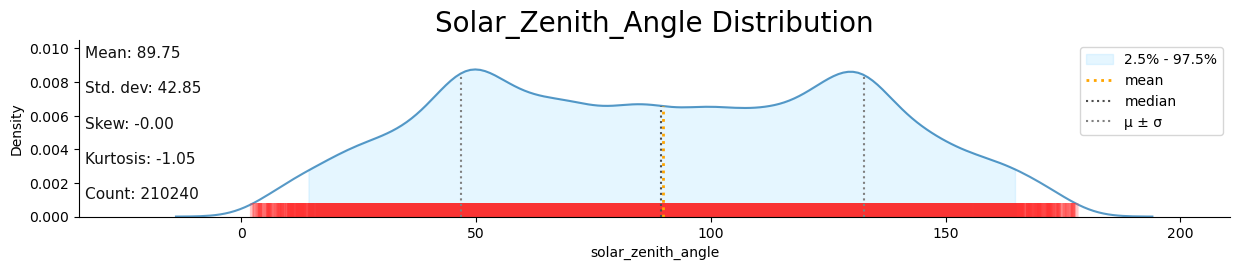

In [71]:
klib.dist_plot(train['solar_zenith_angle']);
plt.title("Solar_Zenith_Angle Distribution",fontsize=20);

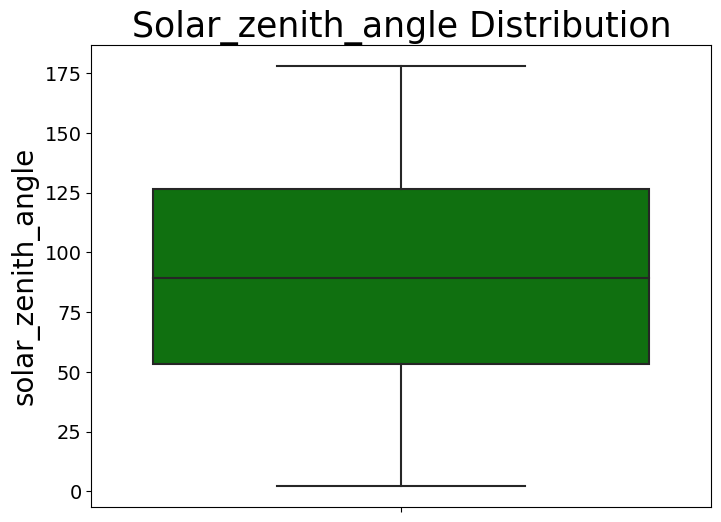

In [72]:
box_plot(train,'solar_zenith_angle')

In [73]:
train['solar_zenith_angle'].describe()

count    210240.000000
mean         89.745758
std          42.852632
min           2.210000
25%          53.140000
50%          89.400000
75%         126.440000
max         177.950000
Name: solar_zenith_angle, dtype: float64

#### The above histogram explains that the Solar_Zenith_Angle column is normally distributed but there are two peaks(mode).

#### The average Solar_Zenith_Angle is 89.73 degree.

#### The Solar_Zenith_Angle ranges from 8.55 to 171.55 degrees.

#### The above boxplot expains that there are no  outliers.

### Let's see cloud type-wise solar_zenith_angle distribution.

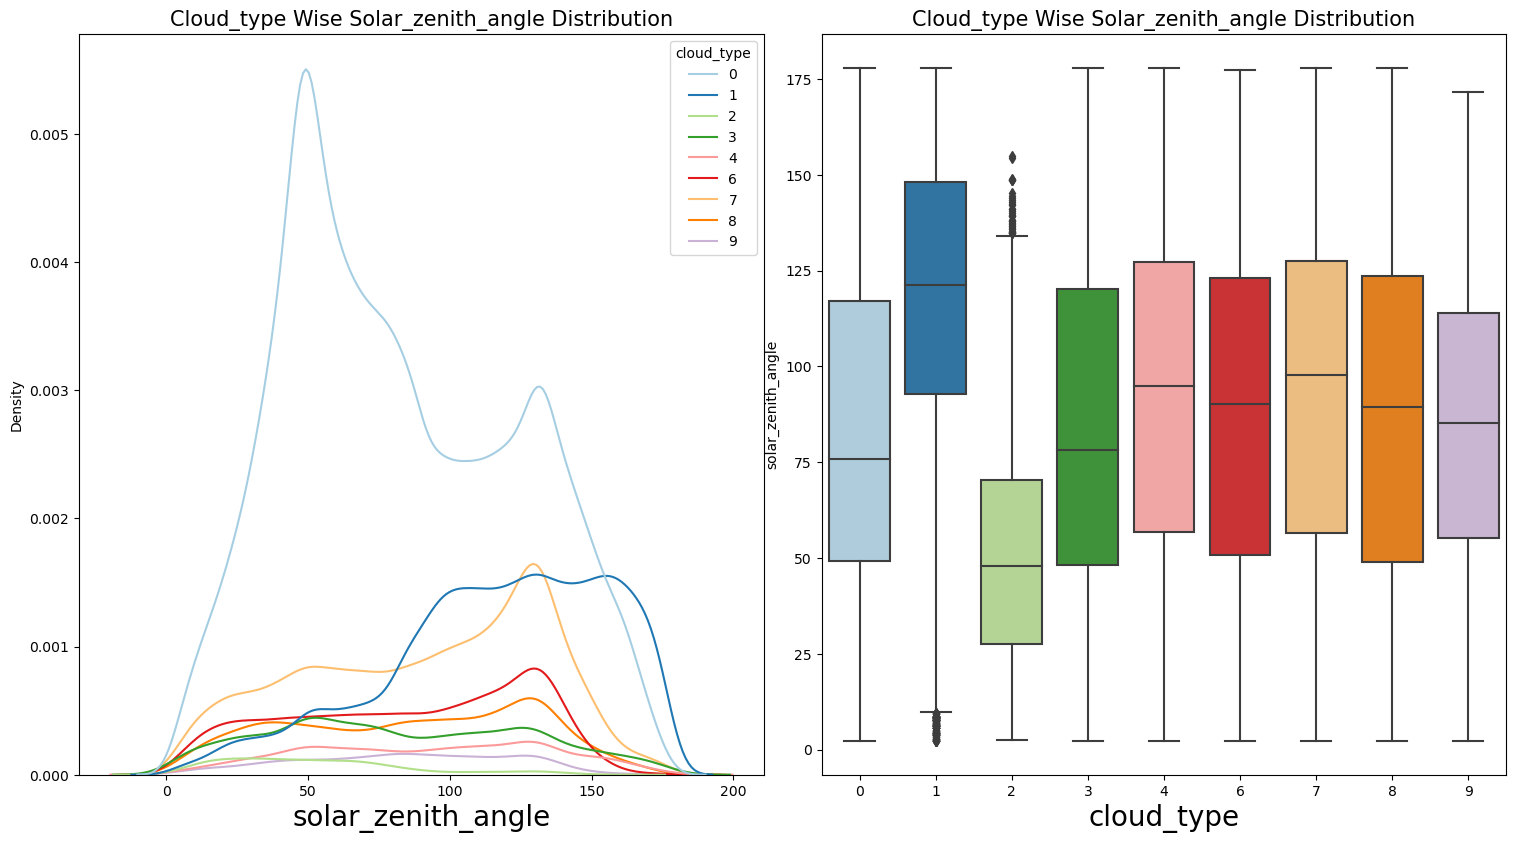

In [74]:
side_by_side_plot(train,'cloud_type','solar_zenith_angle')

In [75]:
group_summary(train,'cloud_type','solar_zenith_angle')

cloud_type    count        mean        std   min      25%      50%  \
1           1  34539.0  116.429624  39.071955  2.21  92.6750  121.110   
4           4   6095.0   91.969890  41.803988  2.23  56.8150   94.890   
6           7  29130.0   91.362864  41.937977  2.30  56.6275   97.775   
7           8  12809.0   86.119859  42.507965  2.21  48.8200   89.500   
5           6  15662.0   85.703832  41.341796  2.27  50.7000   90.045   
8           9   3593.0   83.647506  36.758596  2.25  55.0900   85.170   
3           3  10862.0   82.715237  44.469586  2.22  48.2075   78.100   
0           0  95418.0   82.458016  40.846040  2.22  49.1900   75.910   
2           2   2132.0   52.743297  32.479729  2.37  27.5150   47.840   

        75%     max  
1  148.0400  177.95  
4  127.2750  177.76  
6  127.4700  177.95  
7  123.4900  177.86  
5  122.9875  177.44  
8  113.8200  171.47  
3  120.1600  177.93  
0  116.9300  177.83  
2   70.2700  154.80

#### The above plot explains that in all the cloud types except cloud type 2, the solar zenith angle was at a high amount of radiation.

### Let's see Precipitable_Water distribution.
### Precipitable_Water is total water vapor contained in a unit vertical column of the atmosphere.

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


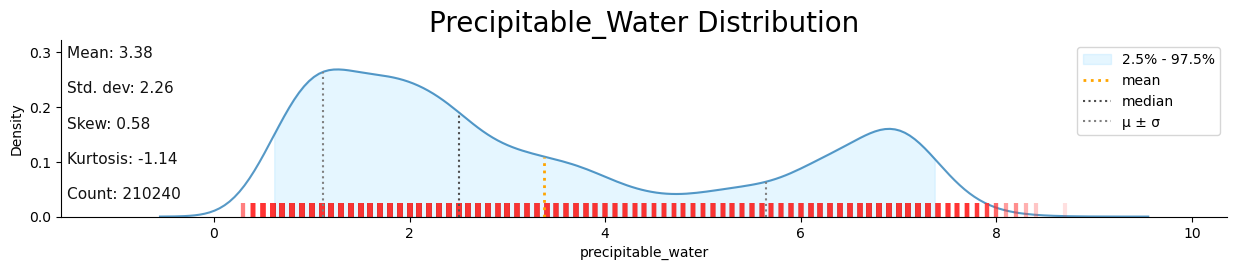

In [76]:
klib.dist_plot(train['precipitable_water']);
plt.title("Precipitable_Water Distribution",fontsize=20);

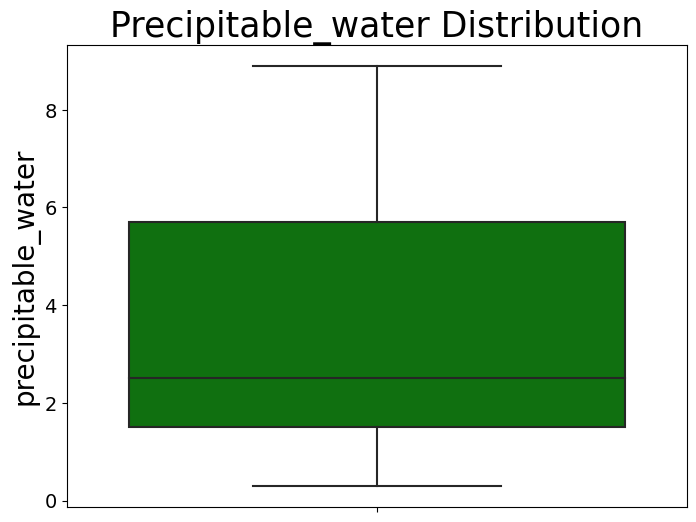

In [77]:
box_plot(train,'precipitable_water')

In [78]:
train['precipitable_water'].describe()

count    210240.000000
mean          3.377582
std           2.261960
min           0.300000
25%           1.500000
50%           2.500000
75%           5.700000
max           8.900000
Name: precipitable_water, dtype: float64

#### The above histogram explains that the Precipitable_Water column is positively skewed and there are two peaks(mode).

#### The average Precipitable_Water value is 2.90 millimeter.

#### The Precipitable_Water ranges from 0.3 to 8.90 mm.

#### The above boxplot expains that there are no outlier.

### Let's see cloud type-wise precipitable_water distribution.

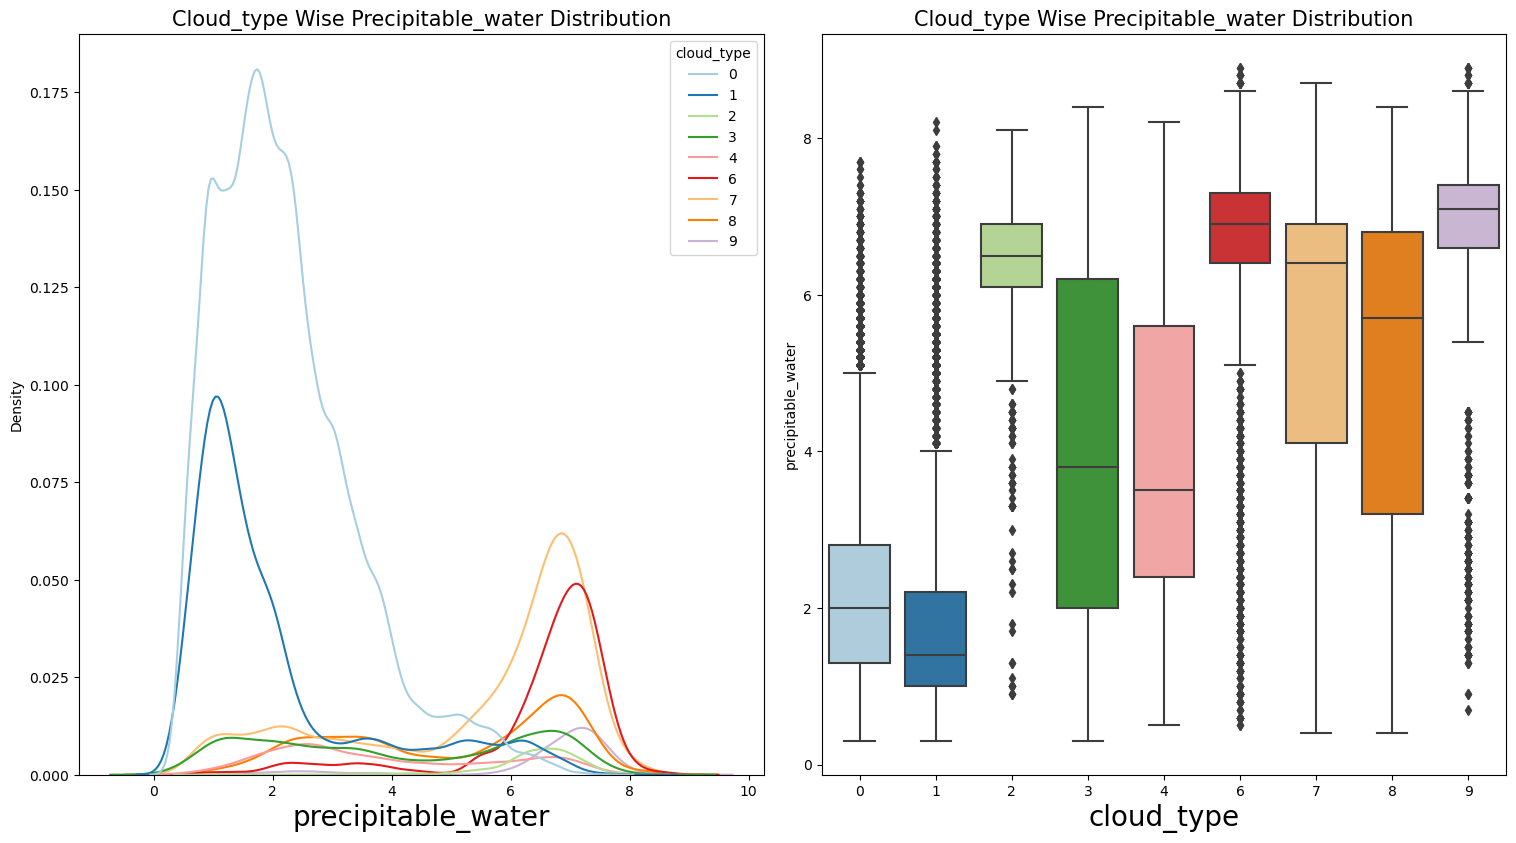

In [79]:
side_by_side_plot(train,'cloud_type','precipitable_water')

In [80]:
group_summary(train,'cloud_type','precipitable_water')

cloud_type    count      mean       std  min  25%  50%  75%  max
8           9   3593.0  6.621570  1.421214  0.7  6.6  7.1  7.4  8.9
5           6  15662.0  6.509067  1.360588  0.5  6.4  6.9  7.3  8.9
2           2   2132.0  6.386069  0.868792  0.9  6.1  6.5  6.9  8.1
6           7  29130.0  5.454442  2.029718  0.4  4.1  6.4  6.9  8.7
7           8  12809.0  5.023093  1.930695  0.4  3.2  5.7  6.8  8.4
3           3  10862.0  4.052559  2.210558  0.3  2.0  3.8  6.2  8.4
4           4   6095.0  3.908384  1.862523  0.5  2.4  3.5  5.6  8.2
0           0  95418.0  2.197611  1.190404  0.3  1.3  2.0  2.8  7.7
1           1  34539.0  2.026425  1.587622  0.3  1.0  1.4  2.2  8.2

#### The above plot explains that in all the cloud types except cloud types 0 and 1, the precipitable water was high.

#### High precipitable water - low solar irradiance.

#### Low precipitable water - high solar irradiance.

### Let's see target columns distribution with various data flag.

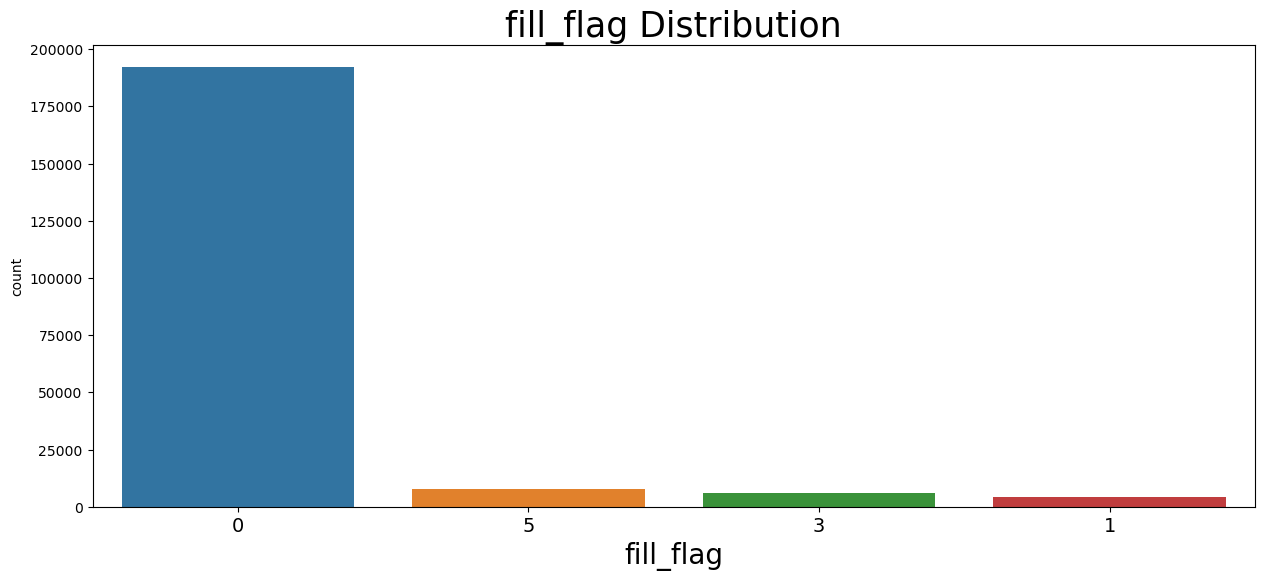

In [81]:
count_plot(train,'fill_flag',size=(15,6))

In [82]:
train['fill_flag'].value_counts()

0    192334
5      7651
3      6093
1      4162
Name: fill_flag, dtype: int64

### Let's see correlation between numeric columns.

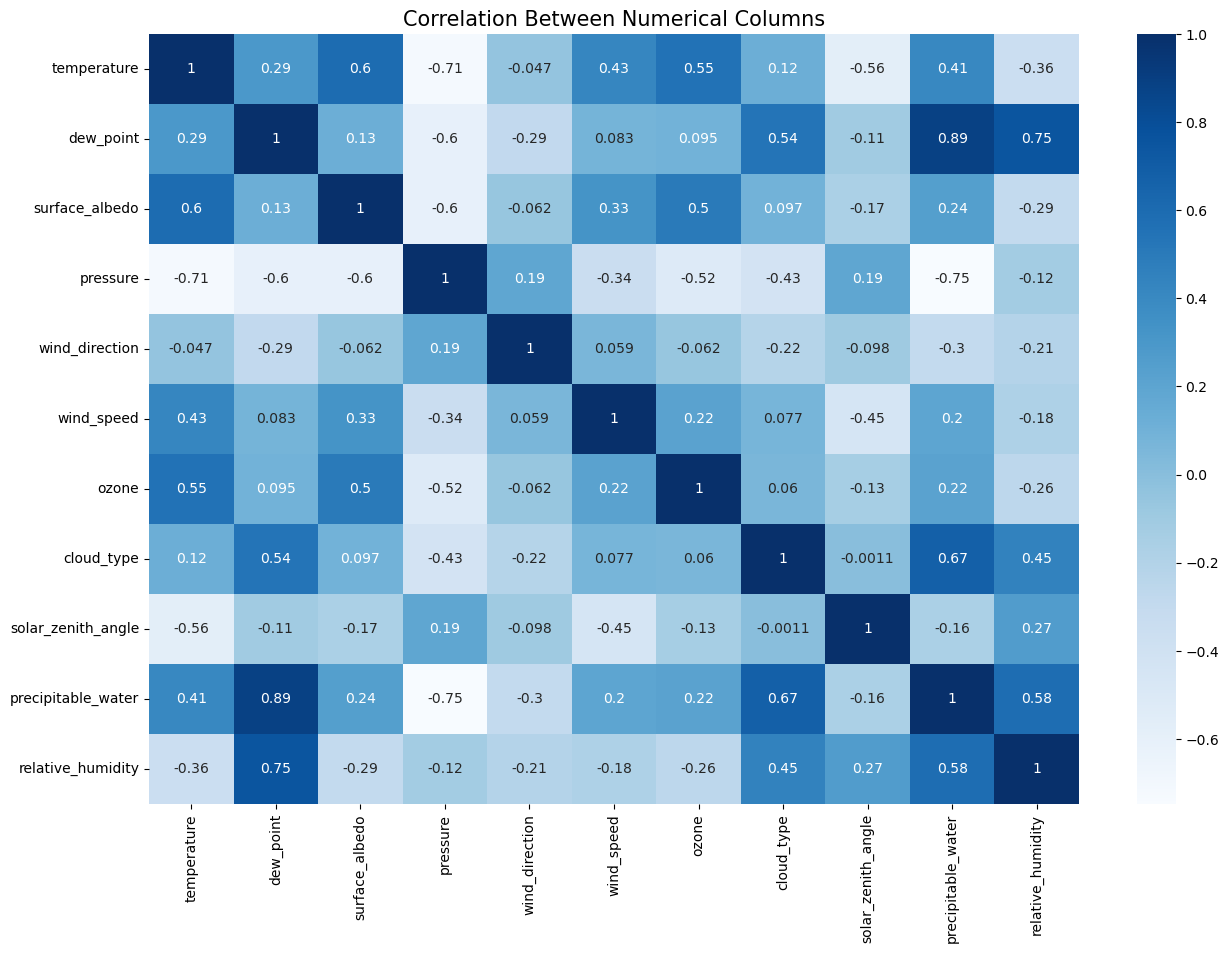

In [83]:
plt.figure(figsize=(15,10));
sns.heatmap(train.iloc[:,np.r_[1:7,11:16]].corr(),cmap='Blues',annot=True);
plt.title("Correlation Between Numerical Columns",fontsize=15);

In [84]:
def corr_features(df,threshold,target):
    corr_list=df.corr().loc[target].drop(target)
    return corr_list[corr_list>threshold]

In [85]:
for num ,i in enumerate(train.iloc[:,np.r_[1:7,11:16]]):
  
    result=corr_features(train.iloc[:,np.r_[1:7,11:16]] ,0.4,i)
    if len(result) > 0:
        print("="*100)
        print(f"The {i} Column is Correlated(0.4) with Following Features \n")
        print(result)
        print("-"*100)
    else:
        ...

The temperature Column is Correlated(0.4) with Following Features 

surface_albedo        0.596618
wind_speed            0.425250
ozone                 0.553733
precipitable_water    0.411293
Name: temperature, dtype: float64
----------------------------------------------------------------------------------------------------
The dew_point Column is Correlated(0.4) with Following Features 

cloud_type            0.542090
precipitable_water    0.886361
relative_humidity     0.749485
Name: dew_point, dtype: float64
----------------------------------------------------------------------------------------------------
The surface_albedo Column is Correlated(0.4) with Following Features 

temperature    0.596618
ozone          0.503839
Name: surface_albedo, dtype: float64
----------------------------------------------------------------------------------------------------
The wind_speed Column is Correlated(0.4) with Following Features 

temperature    0.42525
Name: wind_speed, dtype: float64
-

### Let's do feature engineering on timestamp feature.

In [86]:
def pre_process(df):
    df['date_time']=pd.to_datetime(df["timestamp"]) #convert to date-time format
    df['date']=df['date_time'].dt.date
    df['day']=df['date_time'].dt.day #extract day from the date
    df['day_label']=df['date_time'].dt.day_name() #extract the day name from the date
    df['day_number']=df['date_time'].dt.dayofweek #extract the day number from the date
    df['month_number']=df['date_time'].dt.month #extract month number from the date
    df['month_label']=df['date_time'].dt.strftime('%b') #extract the month name from the date
    df['year_quarter']=df['date_time'].dt.quarter #extract the quarter of the year
    df['week_of_year']=df['date_time'].dt.week #extract week of the year from date
    df['year']= df['date_time'].dt.year #extract year
    df['dayofmonth'] = df['date_time'].dt.daysinmonth #extract the day of the month
    df['dayofyear'] = df['date_time'].dt.day_of_year #extract day of the year
    df['weekday']=df['date_time'].dt.day_name().isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']).astype('int') #create weekday column
    df['weekend']=df['date_time'].dt.day_name().isin(['Saturday', 'Sunday']).astype('int') #create weekend column
    df['month_start']=df['date_time'].dt.is_month_start.astype('int') #create month start
    df['month_end']=df['date_time'].dt.is_month_end.astype('int') #create month end
    df['quarter_start']=df['date_time'].dt.is_quarter_start.astype('int') #create quarter start
    df['quarter_end']=df['date_time'].dt.is_quarter_end.astype('int') #create quarter end
    df['year_start']=df['date_time'].dt.is_year_start.astype('int') #create year start
    df['year_end']=df['date_time'].dt.is_year_end.astype('int') #create year end
    df['hour']=df['date_time'].dt.hour
    df['minute']=df['date_time'].dt.minute
    return df
    

### Apply feature engineering on timestamp column.

In [87]:
train=pre_process(train)

### Function to show different target distribution over the time

In [88]:
def date_time_line_plot(df,x_var,y_val,size=None):
    if size:
        _=plt.figure(figsize=size)
    for i,(y,clr)  in enumerate( zip(y_val,['Red','Green','Blue'])):
        _=plt.subplot(3,1,i+1)
        sns.lineplot(x=df[x_var],y=df[y], color = clr,label=str(y))
        _=plt.title(f'Over the year {y} Distribution',fontsize=22)
        _=plt.xlabel("")
        _=plt.xticks(fontsize=20)
        _=plt.yticks(fontsize=20)
    plt.legend()
    #plt.tight_layout()
    #plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
             

In [89]:
def date_time_line_plot(df,x_var,y_val,size=None,title=""):
    fig, axes = plt.subplots(3,1,figsize=size)
    for i,(y,clr,axs)  in enumerate( zip(y_val,['Red','Green','Blue'],axes.ravel())):
        sns.lineplot(x=df[x_var],y=df[y], color = clr,label=str(y),ax=axs)
        axs.set_title(f'{title} {y} Distribution',fontsize=22)
        axs.set_xlabel("")
        axs.legend()
    fig.subplots_adjust(hspace=0.7)

### Let's see the different target feature distribution over the time.

In [90]:
train['date_time'].describe()

count                  210240
unique                 210240
top       2019-01-01 00:00:00
freq                        1
first     2019-01-01 00:00:00
last      2022-12-31 23:50:00
Name: date_time, dtype: object

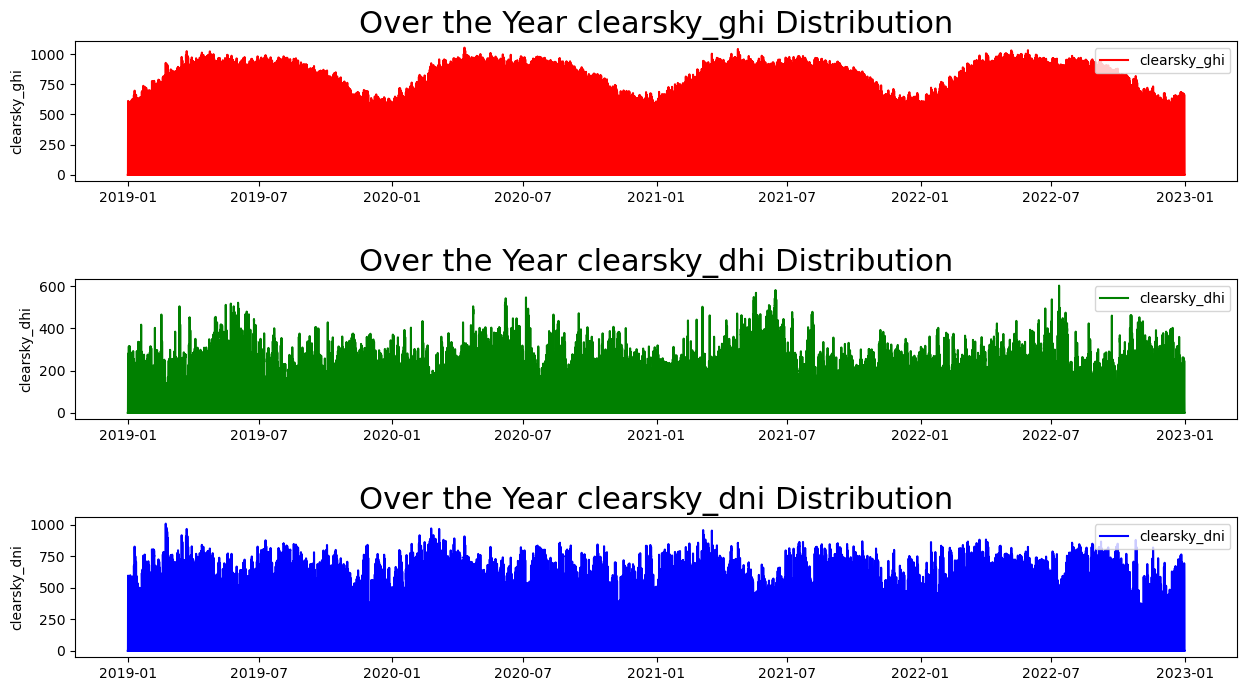

In [91]:
date_time_line_plot(df=train,
                   x_var= 'date_time',
                    y_val=['clearsky_ghi','clearsky_dhi','clearsky_dni'],
                    size=(15,8),
                   title="Over the Year")

#### The above solar irradiance data were recorded from Jan'2019 to Dec'2022. The metrological data was collected at 10-minute intervals.

### Let's see solar irradiance distribution over the months from the year 2019 to 2022.

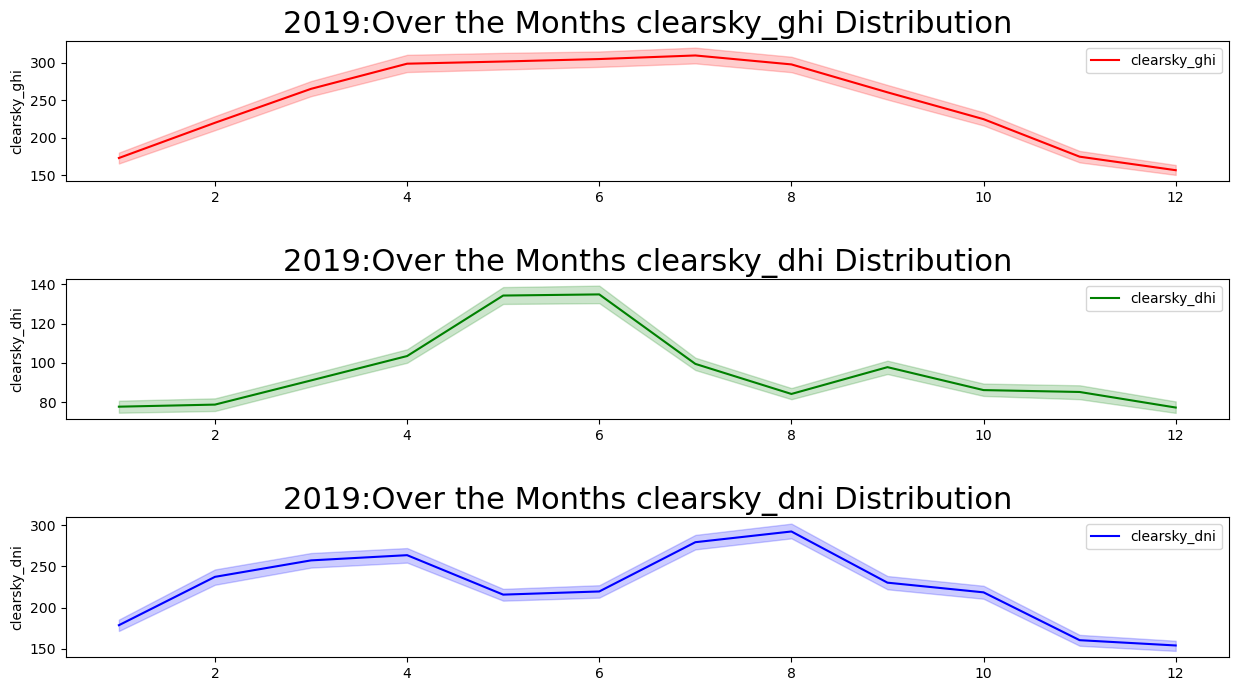

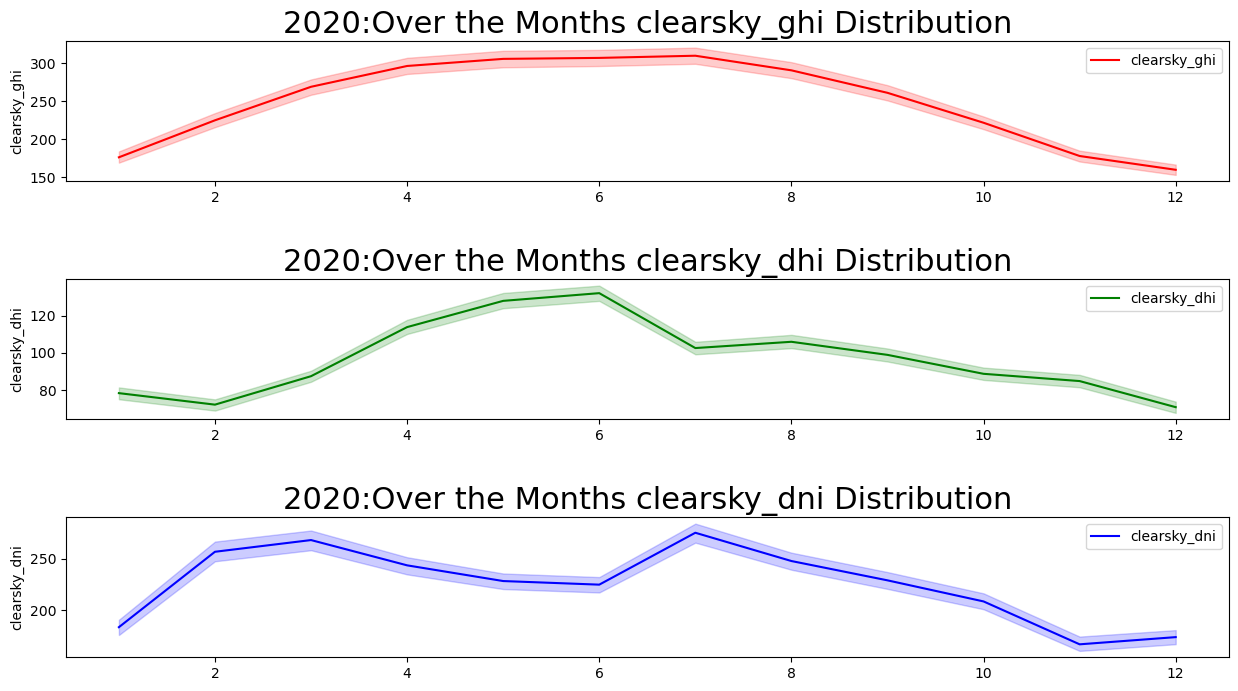

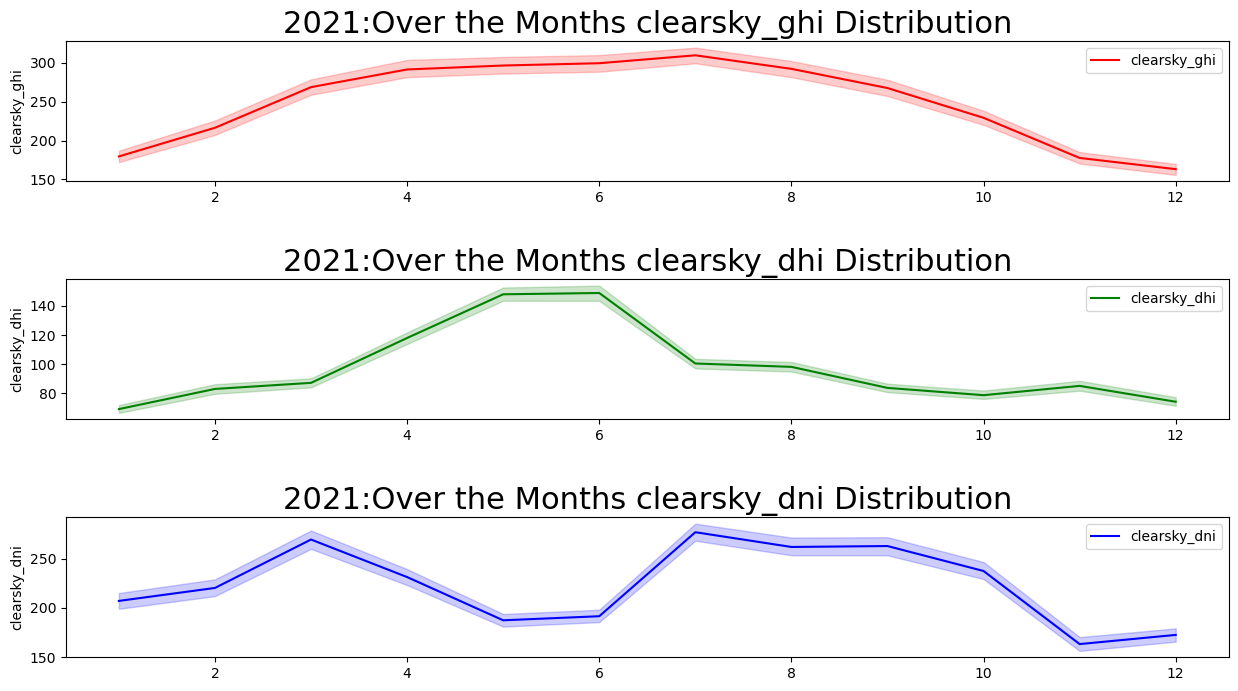

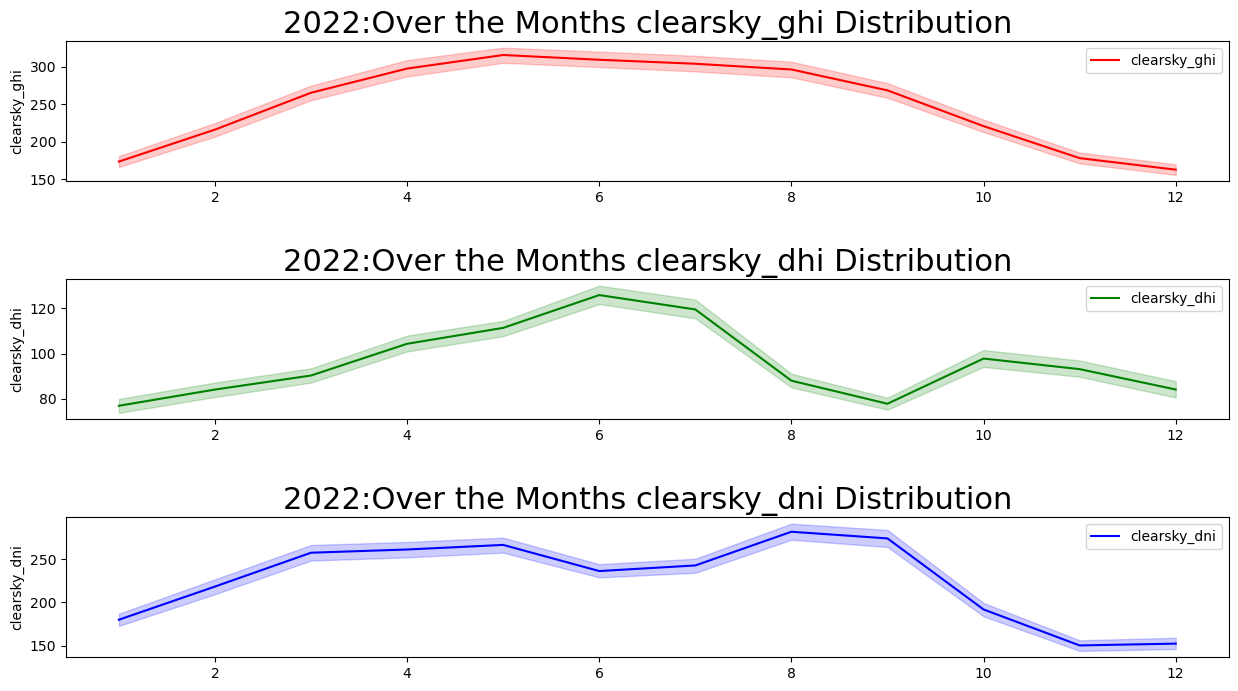

In [92]:
for year in [2019,2020,2021,2022]:
    date_time_line_plot(df=train[train['year']==year],
                        x_var= 'month_number',
                        y_val=['clearsky_ghi','clearsky_dhi','clearsky_dni'],
                        size=(15,8),
                        title=f"{year}:Over the Months")

### Let's see solar irradiance distribution over the weeks in the year.

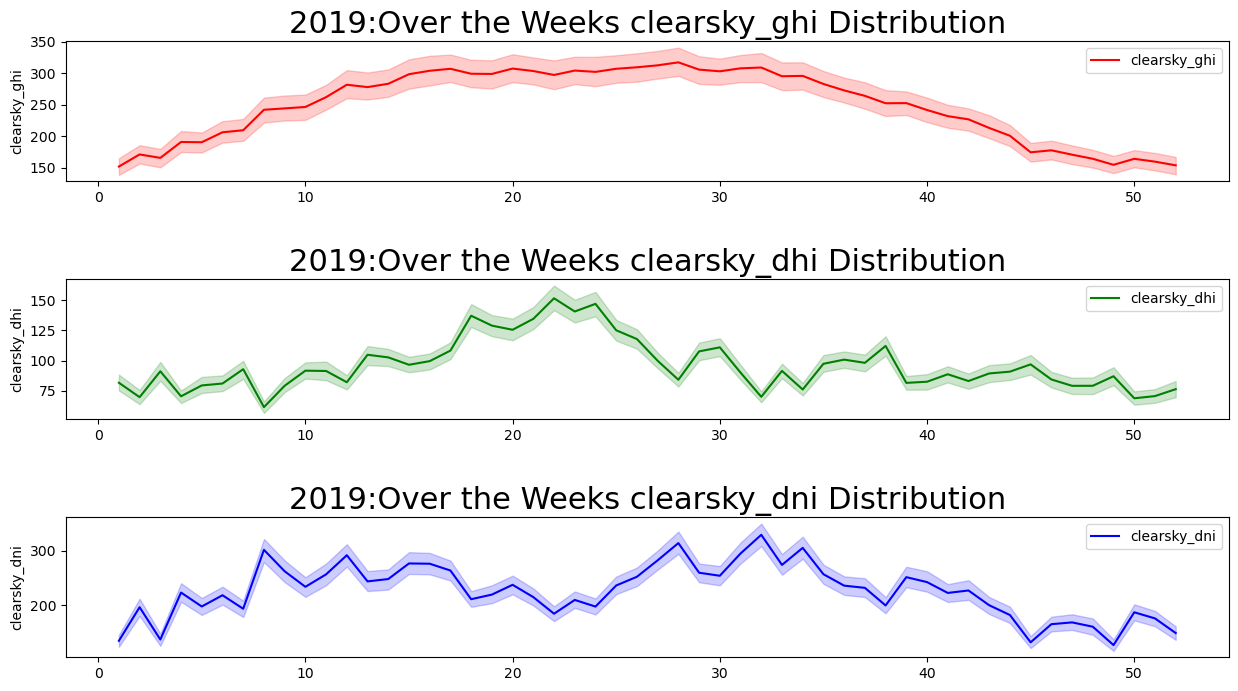

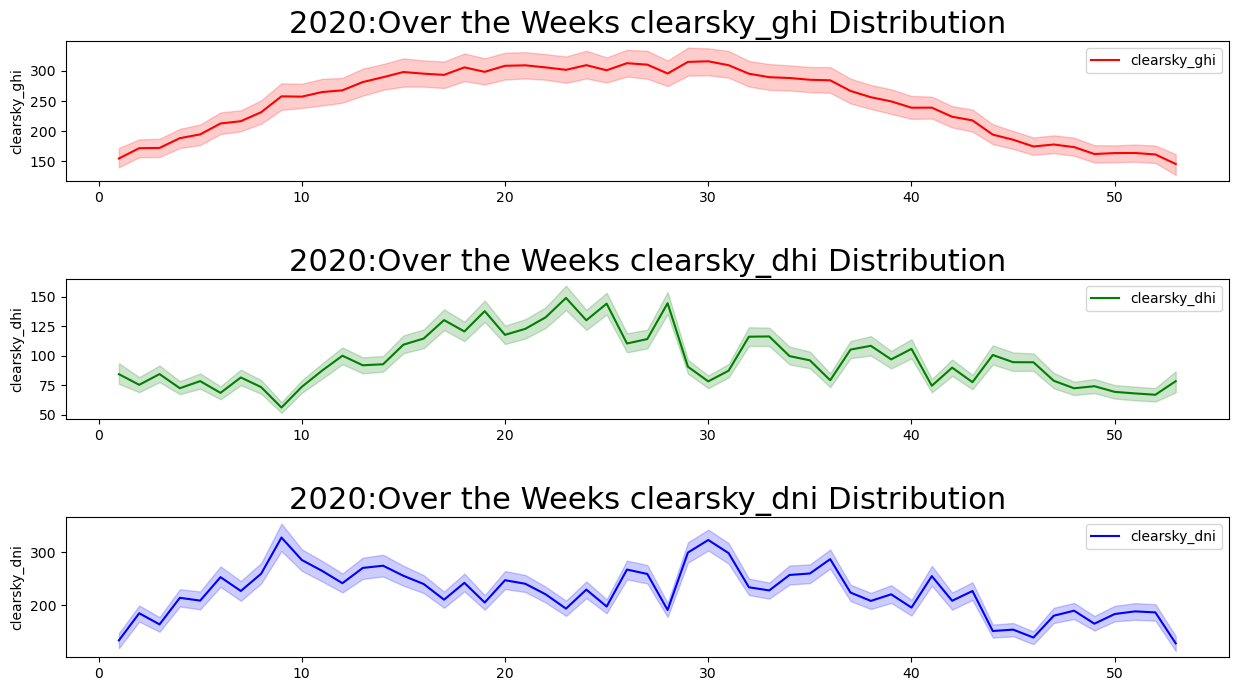

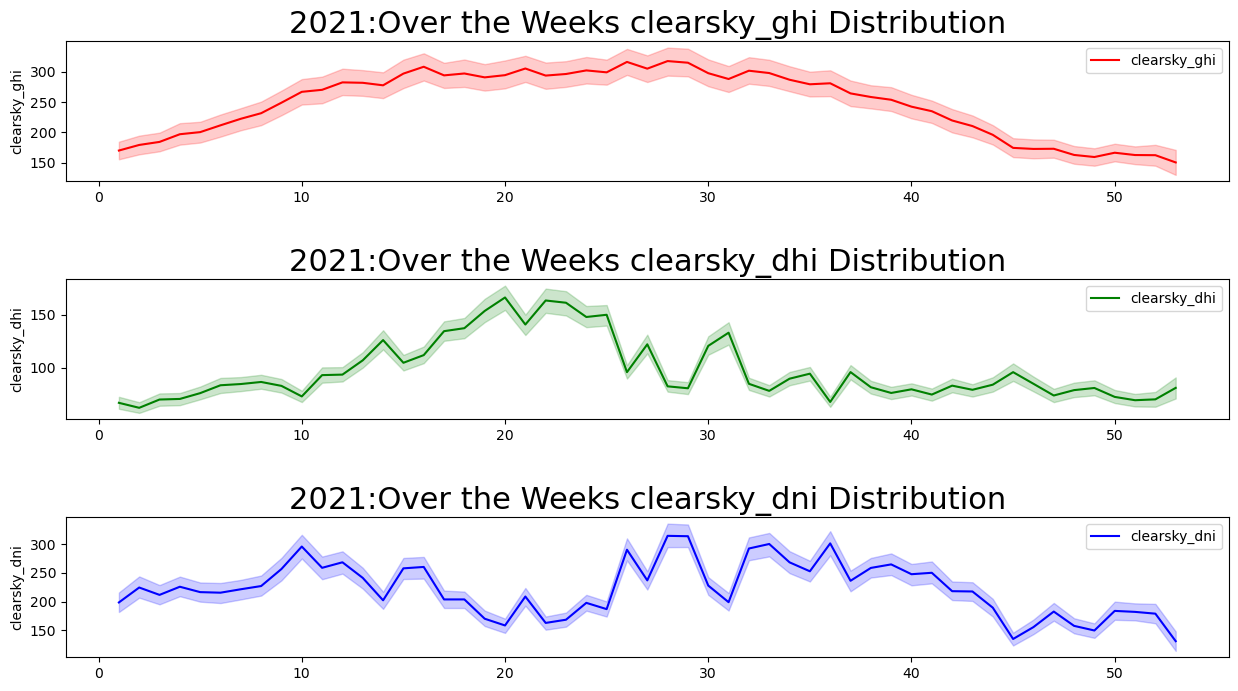

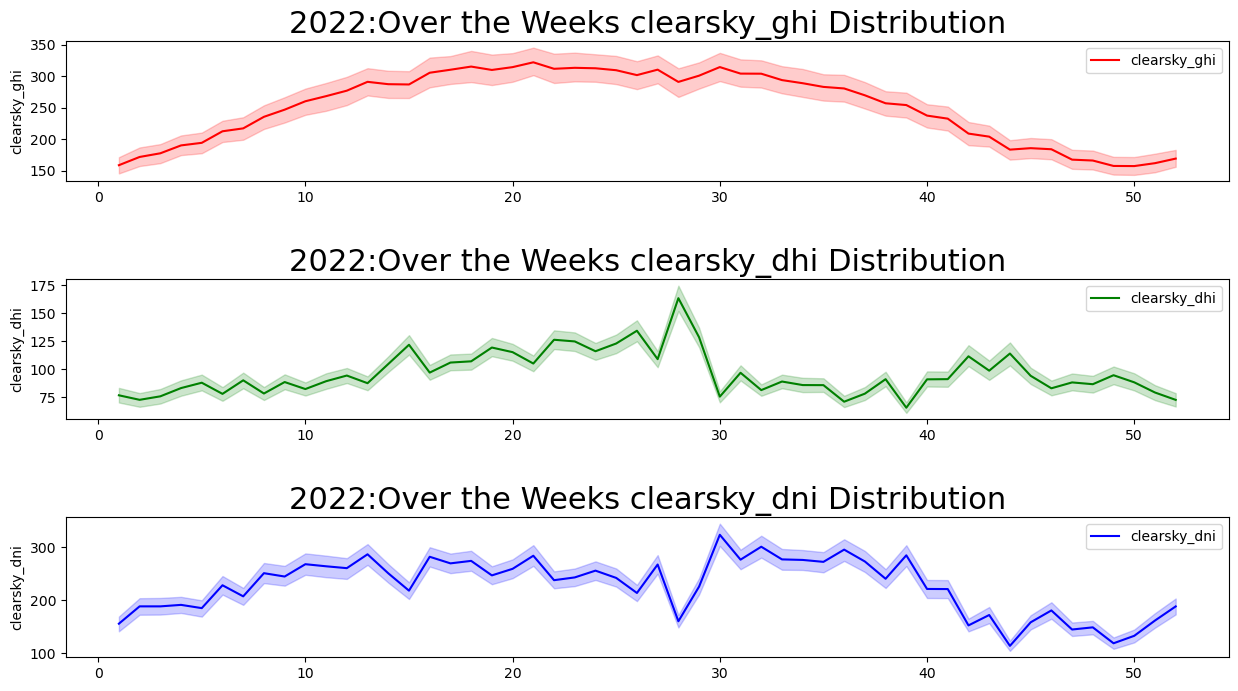

In [93]:
for year in [2019,2020,2021,2022]:
    date_time_line_plot(df=train[train['year']==year],
                        x_var= 'week_of_year',
                        y_val=['clearsky_ghi','clearsky_dhi','clearsky_dni'],
                        size=(15,8),
                        title=f"{year}:Over the Weeks")

### Let's see solar irradiance distribution over the day of the week.

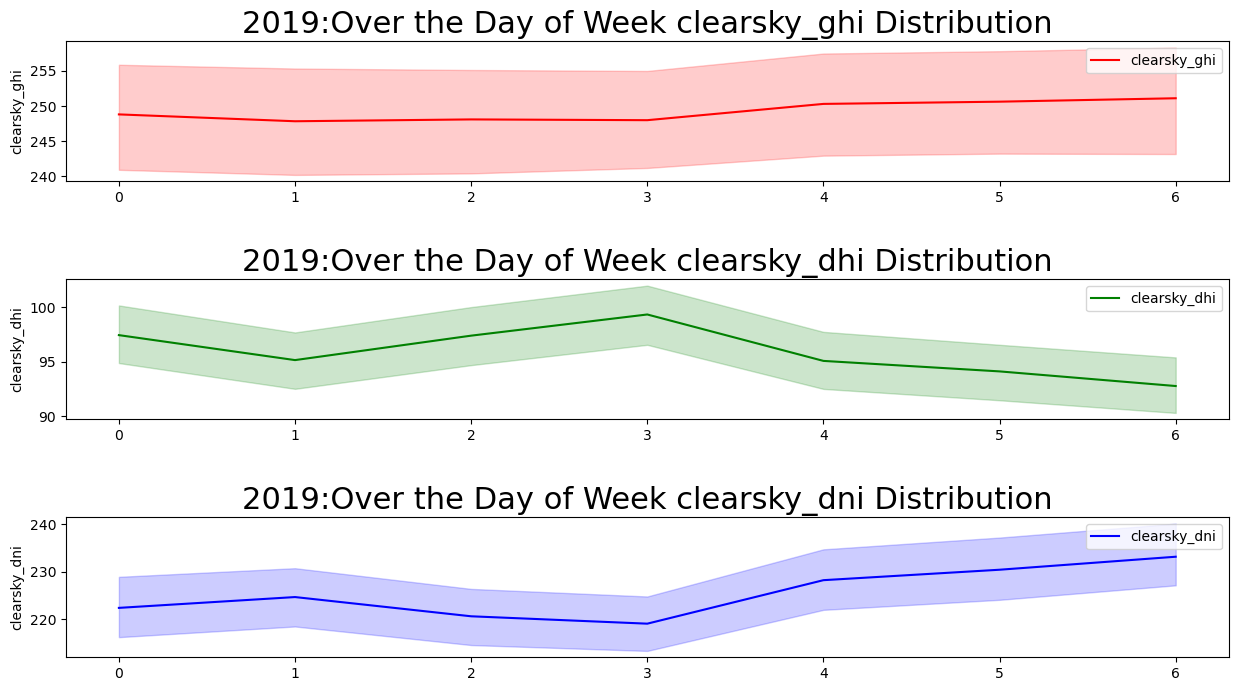

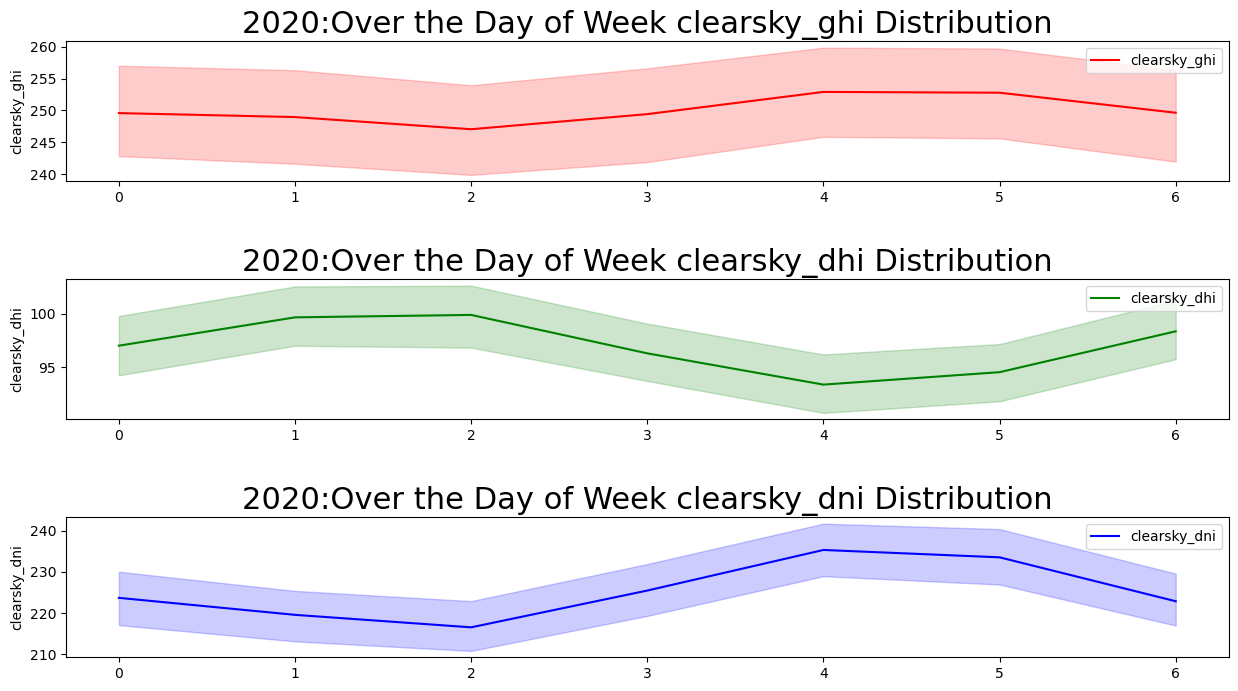

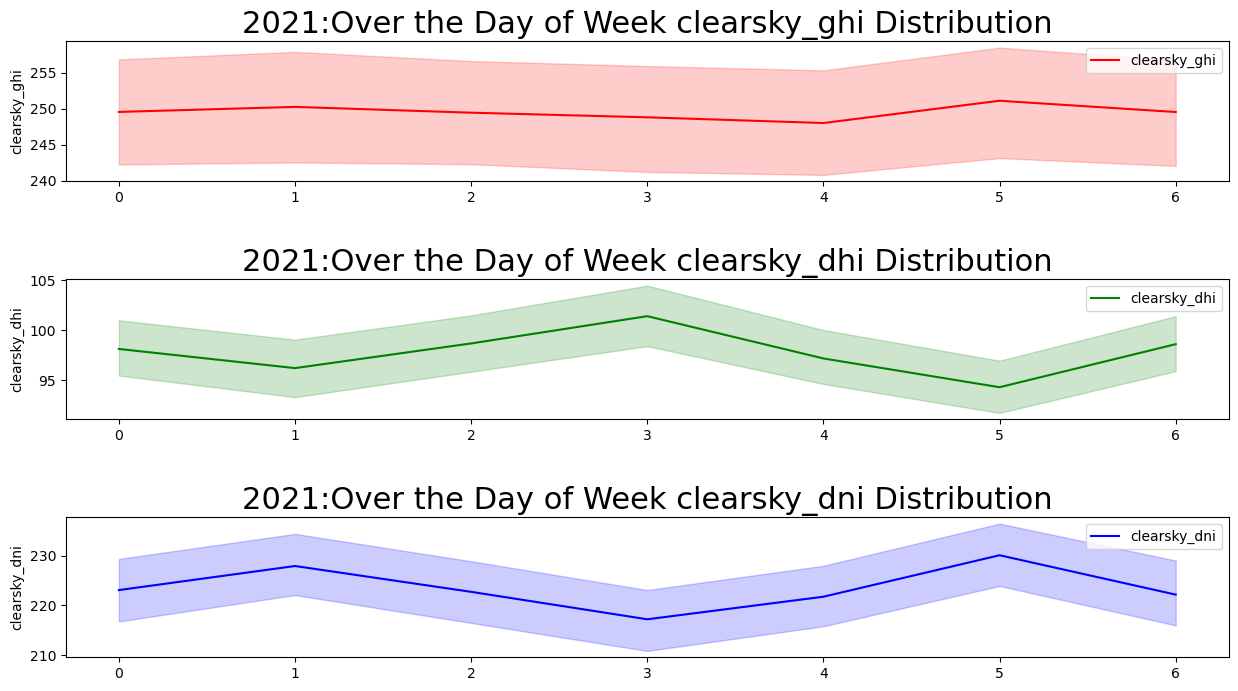

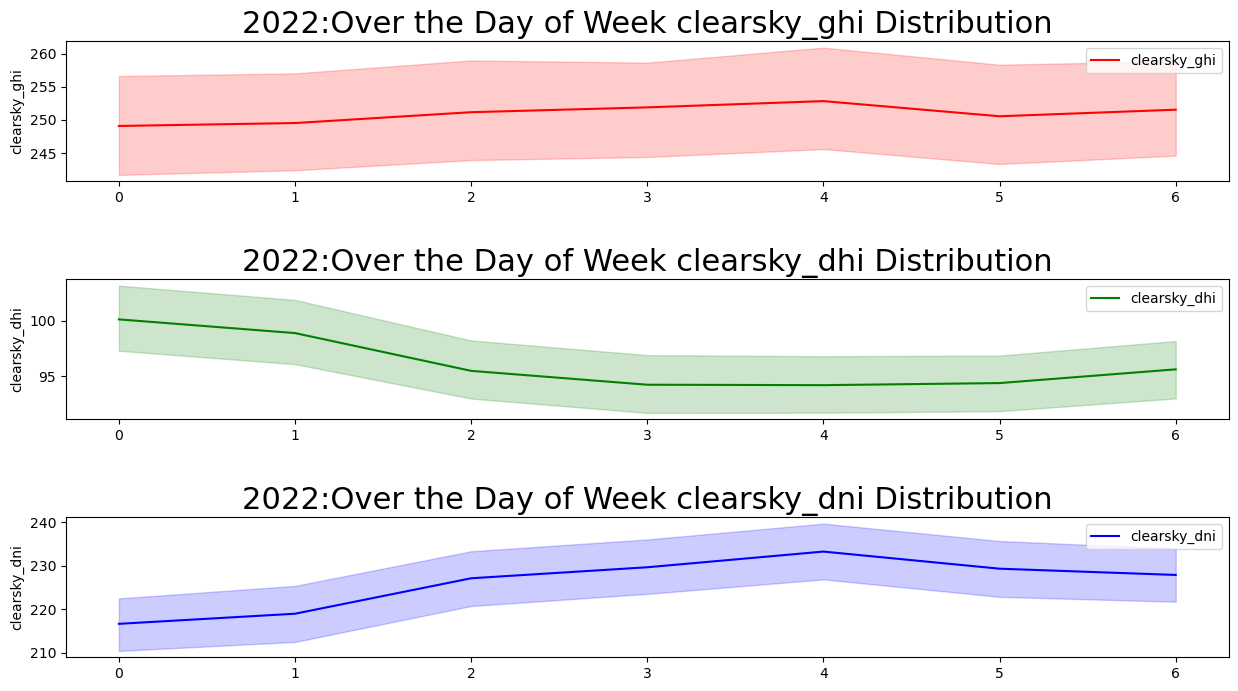

In [94]:
for year in [2019,2020,2021,2022]:
    date_time_line_plot(df=train[train['year']==year],
                        x_var= 'day_number',
                        y_val=['clearsky_ghi','clearsky_dhi','clearsky_dni'],
                        size=(15,8),
                        title=f"{year}:Over the Day of Week")

### Let's see solar irradiance distribution over the hour of the day.
### 10 day samples

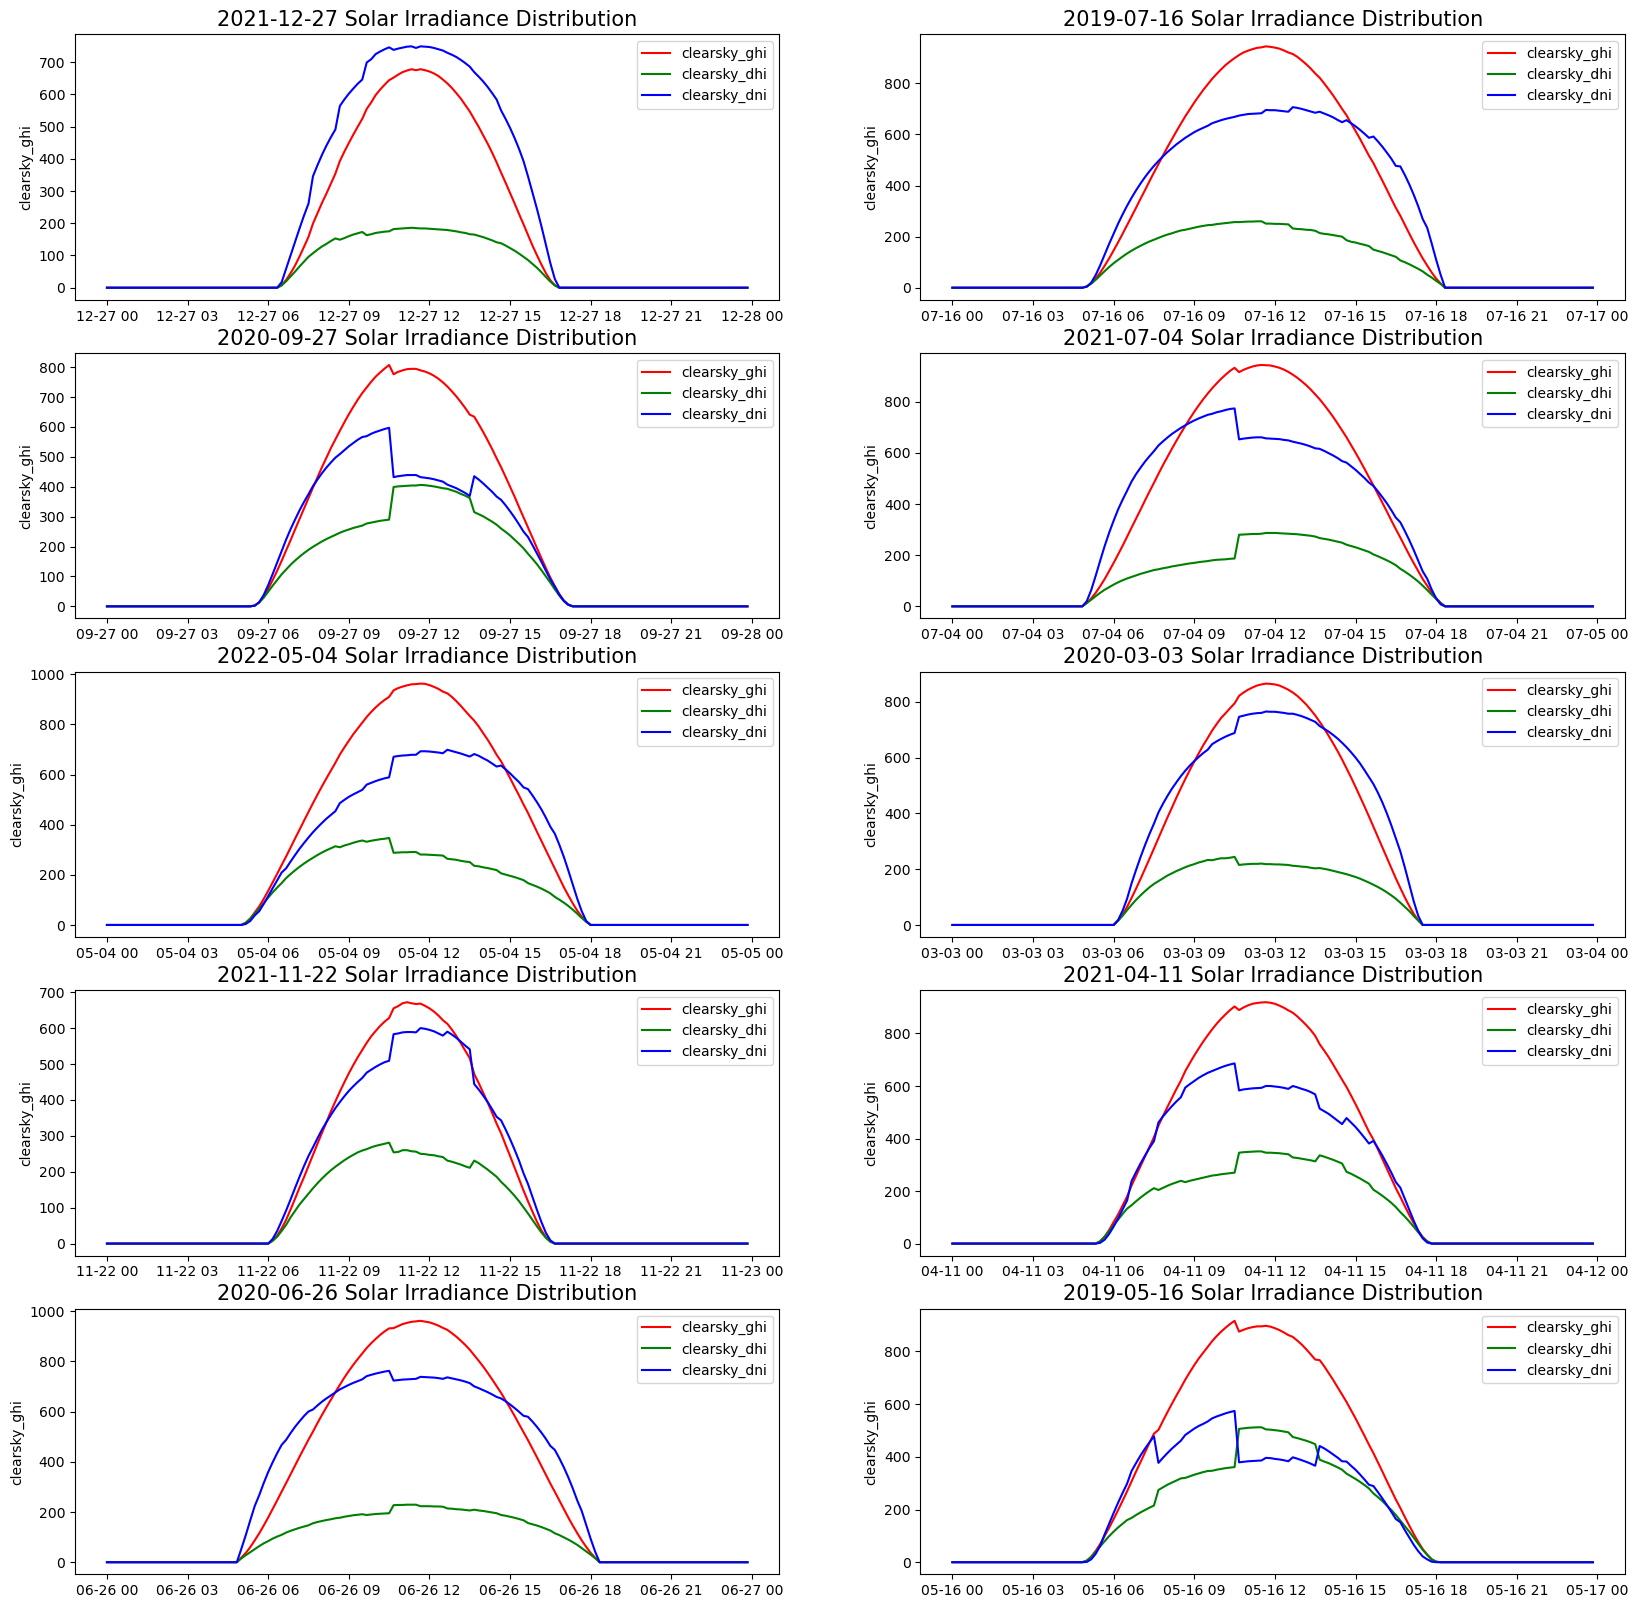

In [95]:
fig=plt.subplots(figsize=(20, 20))
for i,date  in enumerate([str(i) for i in train['date'].sample(n=10)]):    
    _=plt.subplot(5,2,i+1,)
    
    for i,(y,clr)  in enumerate( zip(['clearsky_ghi','clearsky_dhi','clearsky_dni'],
                                         ['Red','Green','Blue'])):
        
        sns.lineplot(data=train[train['date_time'].dt.date.astype(str)==date],
                     x='date_time',y=y,
                     color = clr,label=str(y))
    _=plt.title(date+' Solar Irradiance Distribution',fontsize=15)
    _=plt.xlabel("")
plt.show()

#### The above plot explains that each day the solar irradiance is high from morning 6 o'clock to evening 6'o clock.
#### Solar irradiance peaked at from 9'o clock till 3'o clock.

### Let's see how metrological nemerical features changes over the year.

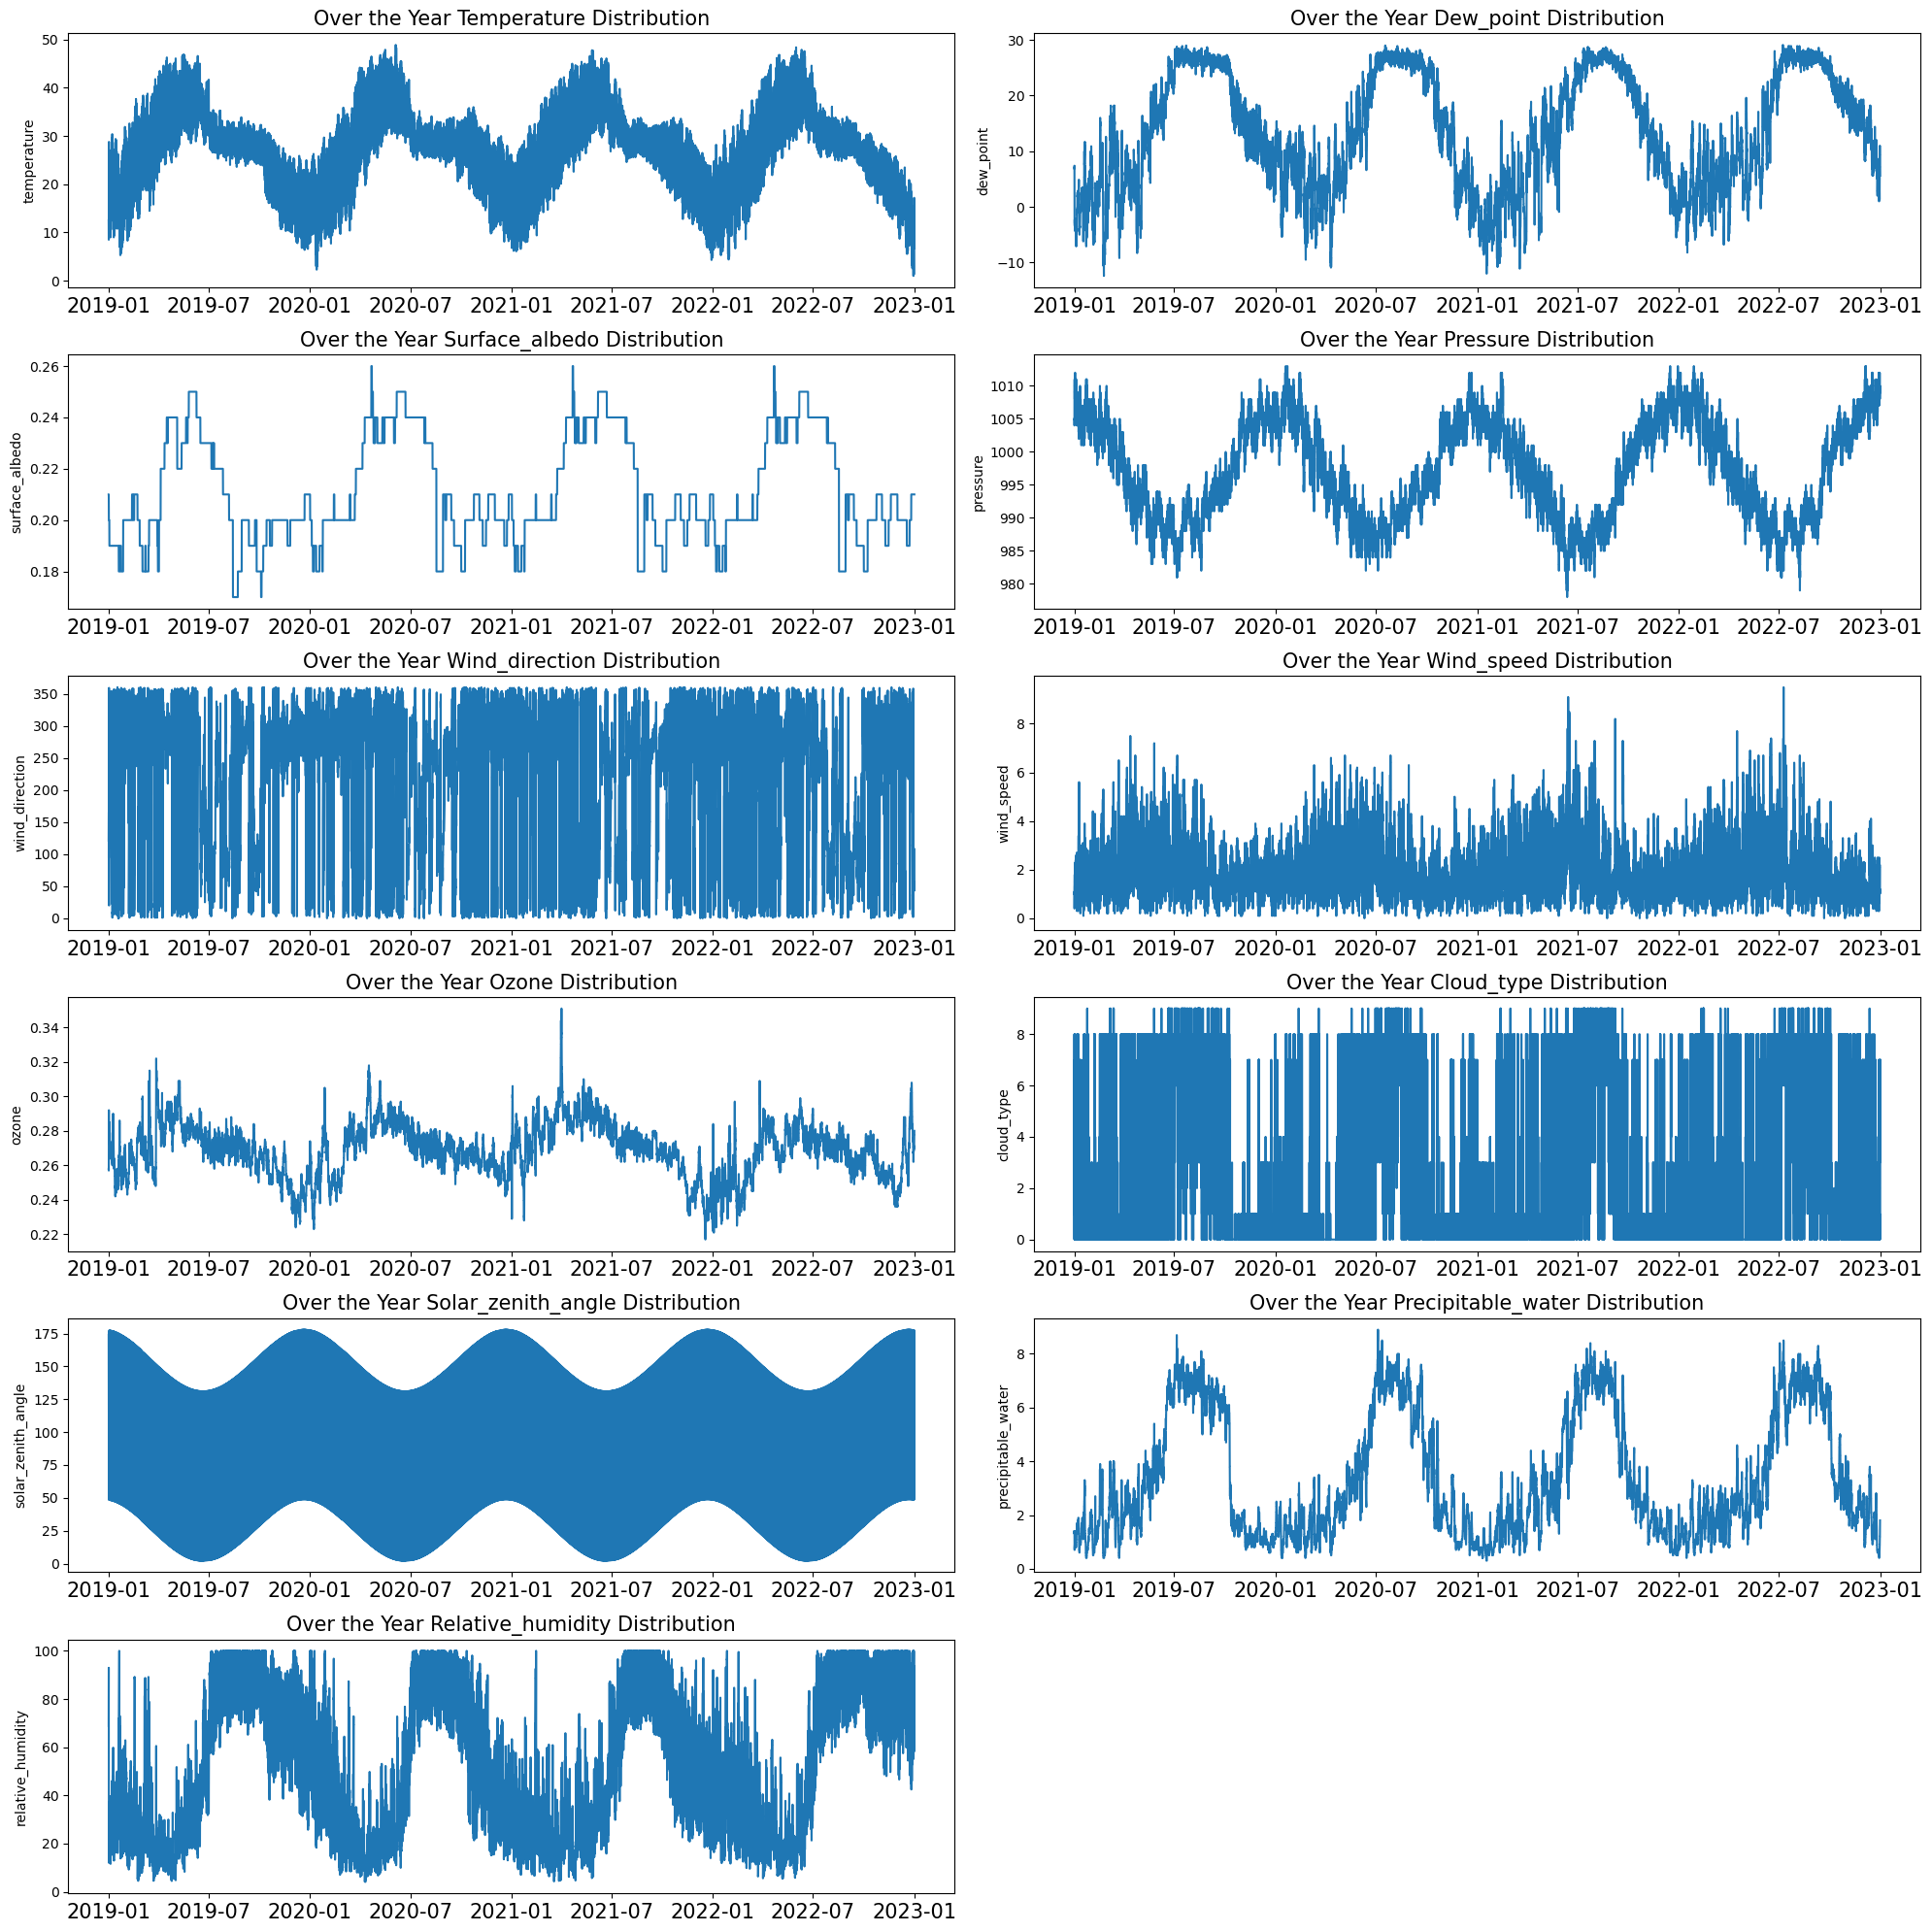

In [96]:
fig=plt.subplots(figsize=(20, 20))
for i,col  in enumerate(train.iloc[:,np.r_[1:7,11:16]].columns):    
    _=plt.subplot(6,2,i+1,)
    sns.lineplot(data=train,
                     x='date_time',y=col)
    _=plt.title(f'Over the Year {col.capitalize()} Distribution',fontsize=15)
    _=plt.xlabel("")
    _=plt.xticks(fontsize=15)
    _=plt.tight_layout()  
plt.show()

### Let's check the stationarity of metrological features.

### Let's use the Augmented Dickey-Fuller Test.
### The Augmented Dickey-Fuller Test assumption is,
* H0:Series is non-stationary(has a unit root)
* H1:Series is stationary(has no unit root)

In [97]:
def adf_test_plot(df,date,val):
    res=list()
    df1=df[[date,val]]
    df1.set_index(date,inplace=True)
    adftest=adfuller(df1[val],autolag='AIC')
    res.extend(adftest[0:4])
    res.extend(list(adftest[4].values()))
    return res
    """
    dfoutput=pd.Series(adftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
    for key,value in adftest[4].items():
        dfoutput['critical value (%s)'%key]= value

    if (dfoutput['p-value'] < 0.05) & ((dfoutput['Test Statistic'] < dfoutput['critical value (5%)'])):
        linecolor = 'forestgreen'
    else:
        linecolor = 'red'

    sns.lineplot(x=df[date], y=df[val],color=linecolor)
    plt.title(f"ADF Statistic {dfoutput['Test Statistic']:0.3f} \t p-value: {dfoutput['p-value']:0.3f}\nCritical Values 5%: {dfoutput['critical value (5%)']:0.3f}", fontsize=14)

    """


In [98]:
adf_test_result=pd.DataFrame(columns=['Column name','Test statistic','P-value','Lags used','Number of observations used',
                                      'Critical value (1%)','Critical value (5%)','Critical value (10%)'])

for col in train.iloc[:,np.r_[1:10,11,13:16]].columns:
    res=adf_test_plot(train,'date_time',col)
    res.insert(0,col)
    adf_test_result.loc[len(adf_test_result)]=res


                                                     
                
    
    
    

In [99]:
def test_stat_less_critical_val(test_s,cr_val_1,cr_val_5,cr_val_10):
    if test_s<cr_val_1 or test_s<cr_val_5 or test_s<cr_val_10:
        return True
    else:
        return False
        


adf_test_result['Test Statistic < Critical Value']=adf_test_result.apply(lambda df: test_stat_less_critical_val(df['Test statistic'],
                                                                                                                df['Critical value (1%)'],
                                                                                                                   ['Critical value (5%)'],
                                                                    df['Critical value (10%)']),axis=1).astype('int')

adf_test_result['Stationary']=adf_test_result.apply(lambda df:"Yes" if (df['Test Statistic < Critical Value']==1 \
                                                                        and df['P-value']<0.05) else "No", axis=1)

In [100]:
adf_test_result

Column name  Test statistic       P-value Lags used  \
0          temperature      -10.406507  1.850856e-18        82   
1            dew_point       -5.707478  7.430608e-07        80   
2       surface_albedo       -4.361585  3.469113e-04         0   
3             pressure       -6.143350  7.873863e-08        82   
4       wind_direction      -23.264805  0.000000e+00        82   
5           wind_speed      -27.465097  0.000000e+00        82   
6         clearsky_dhi      -77.375911  0.000000e+00        82   
7         clearsky_dni      -77.378474  0.000000e+00        82   
8         clearsky_ghi      -71.135754  0.000000e+00        82   
9                ozone       -9.094055  3.756447e-15        78   
10  solar_zenith_angle      -21.169391  0.000000e+00        82   
11  precipitable_water       -5.321727  4.935843e-06        33   
12   relative_humidity      -10.867146  1.398112e-19        82   

   Number of observations used  Critical value (1%)  Critical value (5%)  \
0                       210157            -3.430381            -2.861554   
1                       210159            -3.430381            -2.861554   
2                       210239            -3.430381            -2.861554   
3                       210157            -3.430381            -2.861554   
4                       210157            -3.430381            -2.861554   
5                       210157            -3.430381            -2.861554   
6                       210157            -3.430381            -2.861554   
7                       210157            -3.430381            -2.861554   
8                       210157            -3.430381            -2.861554   
9                       210161            -3.430381            -2.861554   
10                      210157            -3.430381            -2.861554   
11                      210206            -3.430381            -2.861554   
12                      210157            -3.430381            -2.861554   

    Critical value (10%)  Test Statistic < Critical Value Stationary  
0              -2.566777                                1        Yes  
1              -2.566777                                1        Yes  
2              -2.566777                                1        Yes  
3              -2.566777                                1        Yes  
4              -2.566777                                1        Yes  
5              -2.566777                                1        Yes  
6              -2.566777                                1        Yes  
7              -2.566777                                1        Yes  
8              -2.566777                                1        Yes  
9              -2.566777                                1        Yes  
10             -2.566777                                1        Yes  
11             -2.566777                                1        Yes  
12             -2.566777                                1        Yes

### From the above ADF test results, all the metrological features' p-value is less than the significance level(0.05), so reject the null hypothesis, and the data is stationary.

### Let's use the KPSS Test.
### The KPSS Test assumption is,
* H0:Series is stationary(has no unit root)
* H1:Series is non stationary(has a unit root)[](http://)

In [101]:
def kpss_test(df,date,val,diff=None):
    res=[]
    df1=df[[date,val]]
    df1.set_index(date,inplace=True)
    if diff:
        kpsstest = kpss(df1[val].diff().fillna(0), regression='c',nlags="auto")
        res.extend(kpsstest[0:3])
        res.extend(list(kpsstest[3].values()))
        return res
    else:
        kpsstest = kpss(df1[val], regression='c',nlags="auto")
        res.extend(kpsstest[0:3])
        res.extend(list(kpsstest[3].values()))
        return res

In [102]:
kpss_test_result=pd.DataFrame(columns=['Column name','Test statistic','P-value','Lags used',
                                      'Critical value (10%)','Critical value (5%)','Critical value (2.5%)',
                                      'Critical value (1%)'])

for col in train.iloc[:,np.r_[1:10,11,13:16]].columns:
    res=kpss_test(train,'date_time',col,)
    res.insert(0,col)
    kpss_test_result.loc[len(kpss_test_result)]=res


    

def test_stat_less_critical_val(test_s,cr_val_10,cr_val_5,cr_val_2_5,cr_val_1):
    res=[]
    if test_s>cr_val_10 or test_s>cr_val_5 or test_s>cr_val_2_5 or test_s>cr_val_1:
        res.append(True)
    return any(res)    
    
    
kpss_test_result['Test Statistic > Critical Value']=kpss_test_result.apply(lambda df:test_stat_less_critical_val(
                                                                    df['Test statistic'],
                                                                    df['Critical value (10%)'], 
                                                                     df['Critical value (5%)'], 
                                                                      df['Critical value (2.5%)'],
                                                                      df['Critical value (1%)']
                                                                       ),axis=1).astype('int')
kpss_test_result['Stationary']=kpss_test_result.apply(lambda df:"No" if (df['Test Statistic > Critical Value']==1 and df['P-value']<0.05) else "Yes", axis=1
                                                     )
                
    
    
    

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning

In [103]:
kpss_test_result

Column name  Test statistic   P-value Lags used  \
0          temperature        1.332265  0.010000       263   
1            dew_point        2.366750  0.010000       266   
2       surface_albedo        1.504778  0.010000       266   
3             pressure        1.306066  0.010000       265   
4       wind_direction        0.485902  0.044842       257   
5           wind_speed        0.623453  0.020504       259   
6         clearsky_dhi        0.539455  0.032780       255   
7         clearsky_dni        0.500624  0.041526       255   
8         clearsky_ghi        0.982507  0.010000       255   
9                ozone        2.372383  0.010000       266   
10  solar_zenith_angle        1.152340  0.010000       259   
11  precipitable_water        1.362669  0.010000       266   
12   relative_humidity        3.565466  0.010000       264   

    Critical value (10%)  Critical value (5%)  Critical value (2.5%)  \
0                  0.347                0.463                  0.574   
1                  0.347                0.463                  0.574   
2                  0.347                0.463                  0.574   
3                  0.347                0.463                  0.574   
4                  0.347                0.463                  0.574   
5                  0.347                0.463                  0.574   
6                  0.347                0.463                  0.574   
7                  0.347                0.463                  0.574   
8                  0.347                0.463                  0.574   
9                  0.347                0.463                  0.574   
10                 0.347                0.463                  0.574   
11                 0.347                0.463                  0.574   
12                 0.347                0.463                  0.574   

    Critical value (1%)  Test Statistic > Critical Value Stationary  
0                 0.739                                1         No  
1                 0.739                                1         No  
2                 0.739                                1         No  
3                 0.739                                1         No  
4                 0.739                                1         No  
5                 0.739                                1         No  
6                 0.739                                1         No  
7                 0.739                                1         No  
8                 0.739                                1         No  
9                 0.739                                1         No  
10                0.739                                1         No  
11                0.739                                1         No  
12                0.739                                1         No

#### From the above KPSS test results, all the metrological features' p-value is less than the significance level(0.05), so reject the null hypothesis, and the data is non-stationary.

#### The adf test concludes the features are stationary and kpss test concludes the features are non-stationary.
#### If adf test result is stationary and kpss test result is non-stationary means then the series is a difference stationary.

### Let's take the consecutive difference between the observation and check the stationary using kpss test.

In [104]:
kpss_test_result=pd.DataFrame(columns=['Column name','Test statistic','P-value','Lags used',
                                      'Critical value (10%)','Critical value (5%)','Critical value (2.5%)',
                                      'Critical value (1%)'])

for col in train.iloc[:,np.r_[1:10,11,13:16]].columns:
    res=kpss_test(train,'date_time',col,diff=True)
    res.insert(0,col)
    kpss_test_result.loc[len(kpss_test_result)]=res


    

def test_stat_less_critical_val(test_s,cr_val_10,cr_val_5,cr_val_2_5,cr_val_1):
    res=[]
    if test_s>cr_val_10 or test_s>cr_val_5 or test_s>cr_val_2_5 or test_s>cr_val_1:
        res.append(True)
    return any(res)    
    
    
kpss_test_result['Test Statistic > Critical Value']=kpss_test_result.apply(lambda df:test_stat_less_critical_val(
                                                                    df['Test statistic'],
                                                                    df['Critical value (10%)'], 
                                                                     df['Critical value (5%)'], 
                                                                      df['Critical value (2.5%)'],
                                                                      df['Critical value (1%)']
                                                                       ),axis=1).astype('int')
kpss_test_result['Stationary']=kpss_test_result.apply(lambda df:"No" if (df['Test Statistic > Critical Value']==1 and df['P-value']<0.05) else "Yes", axis=1
                                                     )
                
    
    
    

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning

In [105]:
kpss_test_result

Column name  Test statistic  P-value Lags used  \
0          temperature        0.006886      0.1       241   
1            dew_point        0.011360      0.1       147   
2       surface_albedo        0.013222      0.1         0   
3             pressure        0.023622      0.1       210   
4       wind_direction        0.000887      0.1        87   
5           wind_speed        0.000942      0.1       171   
6         clearsky_dhi        0.000551      0.1       225   
7         clearsky_dni        0.000536      0.1       222   
8         clearsky_ghi        0.000649      0.1       241   
9                ozone        0.004214      0.1       209   
10  solar_zenith_angle        0.003798      0.1       255   
11  precipitable_water        0.016843      0.1       221   
12   relative_humidity        0.003542      0.1       225   

    Critical value (10%)  Critical value (5%)  Critical value (2.5%)  \
0                  0.347                0.463                  0.574   
1                  0.347                0.463                  0.574   
2                  0.347                0.463                  0.574   
3                  0.347                0.463                  0.574   
4                  0.347                0.463                  0.574   
5                  0.347                0.463                  0.574   
6                  0.347                0.463                  0.574   
7                  0.347                0.463                  0.574   
8                  0.347                0.463                  0.574   
9                  0.347                0.463                  0.574   
10                 0.347                0.463                  0.574   
11                 0.347                0.463                  0.574   
12                 0.347                0.463                  0.574   

    Critical value (1%)  Test Statistic > Critical Value Stationary  
0                 0.739                                0        Yes  
1                 0.739                                0        Yes  
2                 0.739                                0        Yes  
3                 0.739                                0        Yes  
4                 0.739                                0        Yes  
5                 0.739                                0        Yes  
6                 0.739                                0        Yes  
7                 0.739                                0        Yes  
8                 0.739                                0        Yes  
9                 0.739                                0        Yes  
10                0.739                                0        Yes  
11                0.739                                0        Yes  
12                0.739                                0        Yes

### The above result explains that the data become stationary when taking consecutive differences between the observations.

### Let's see the correlation between the time series and its lagged values by using acf plot.

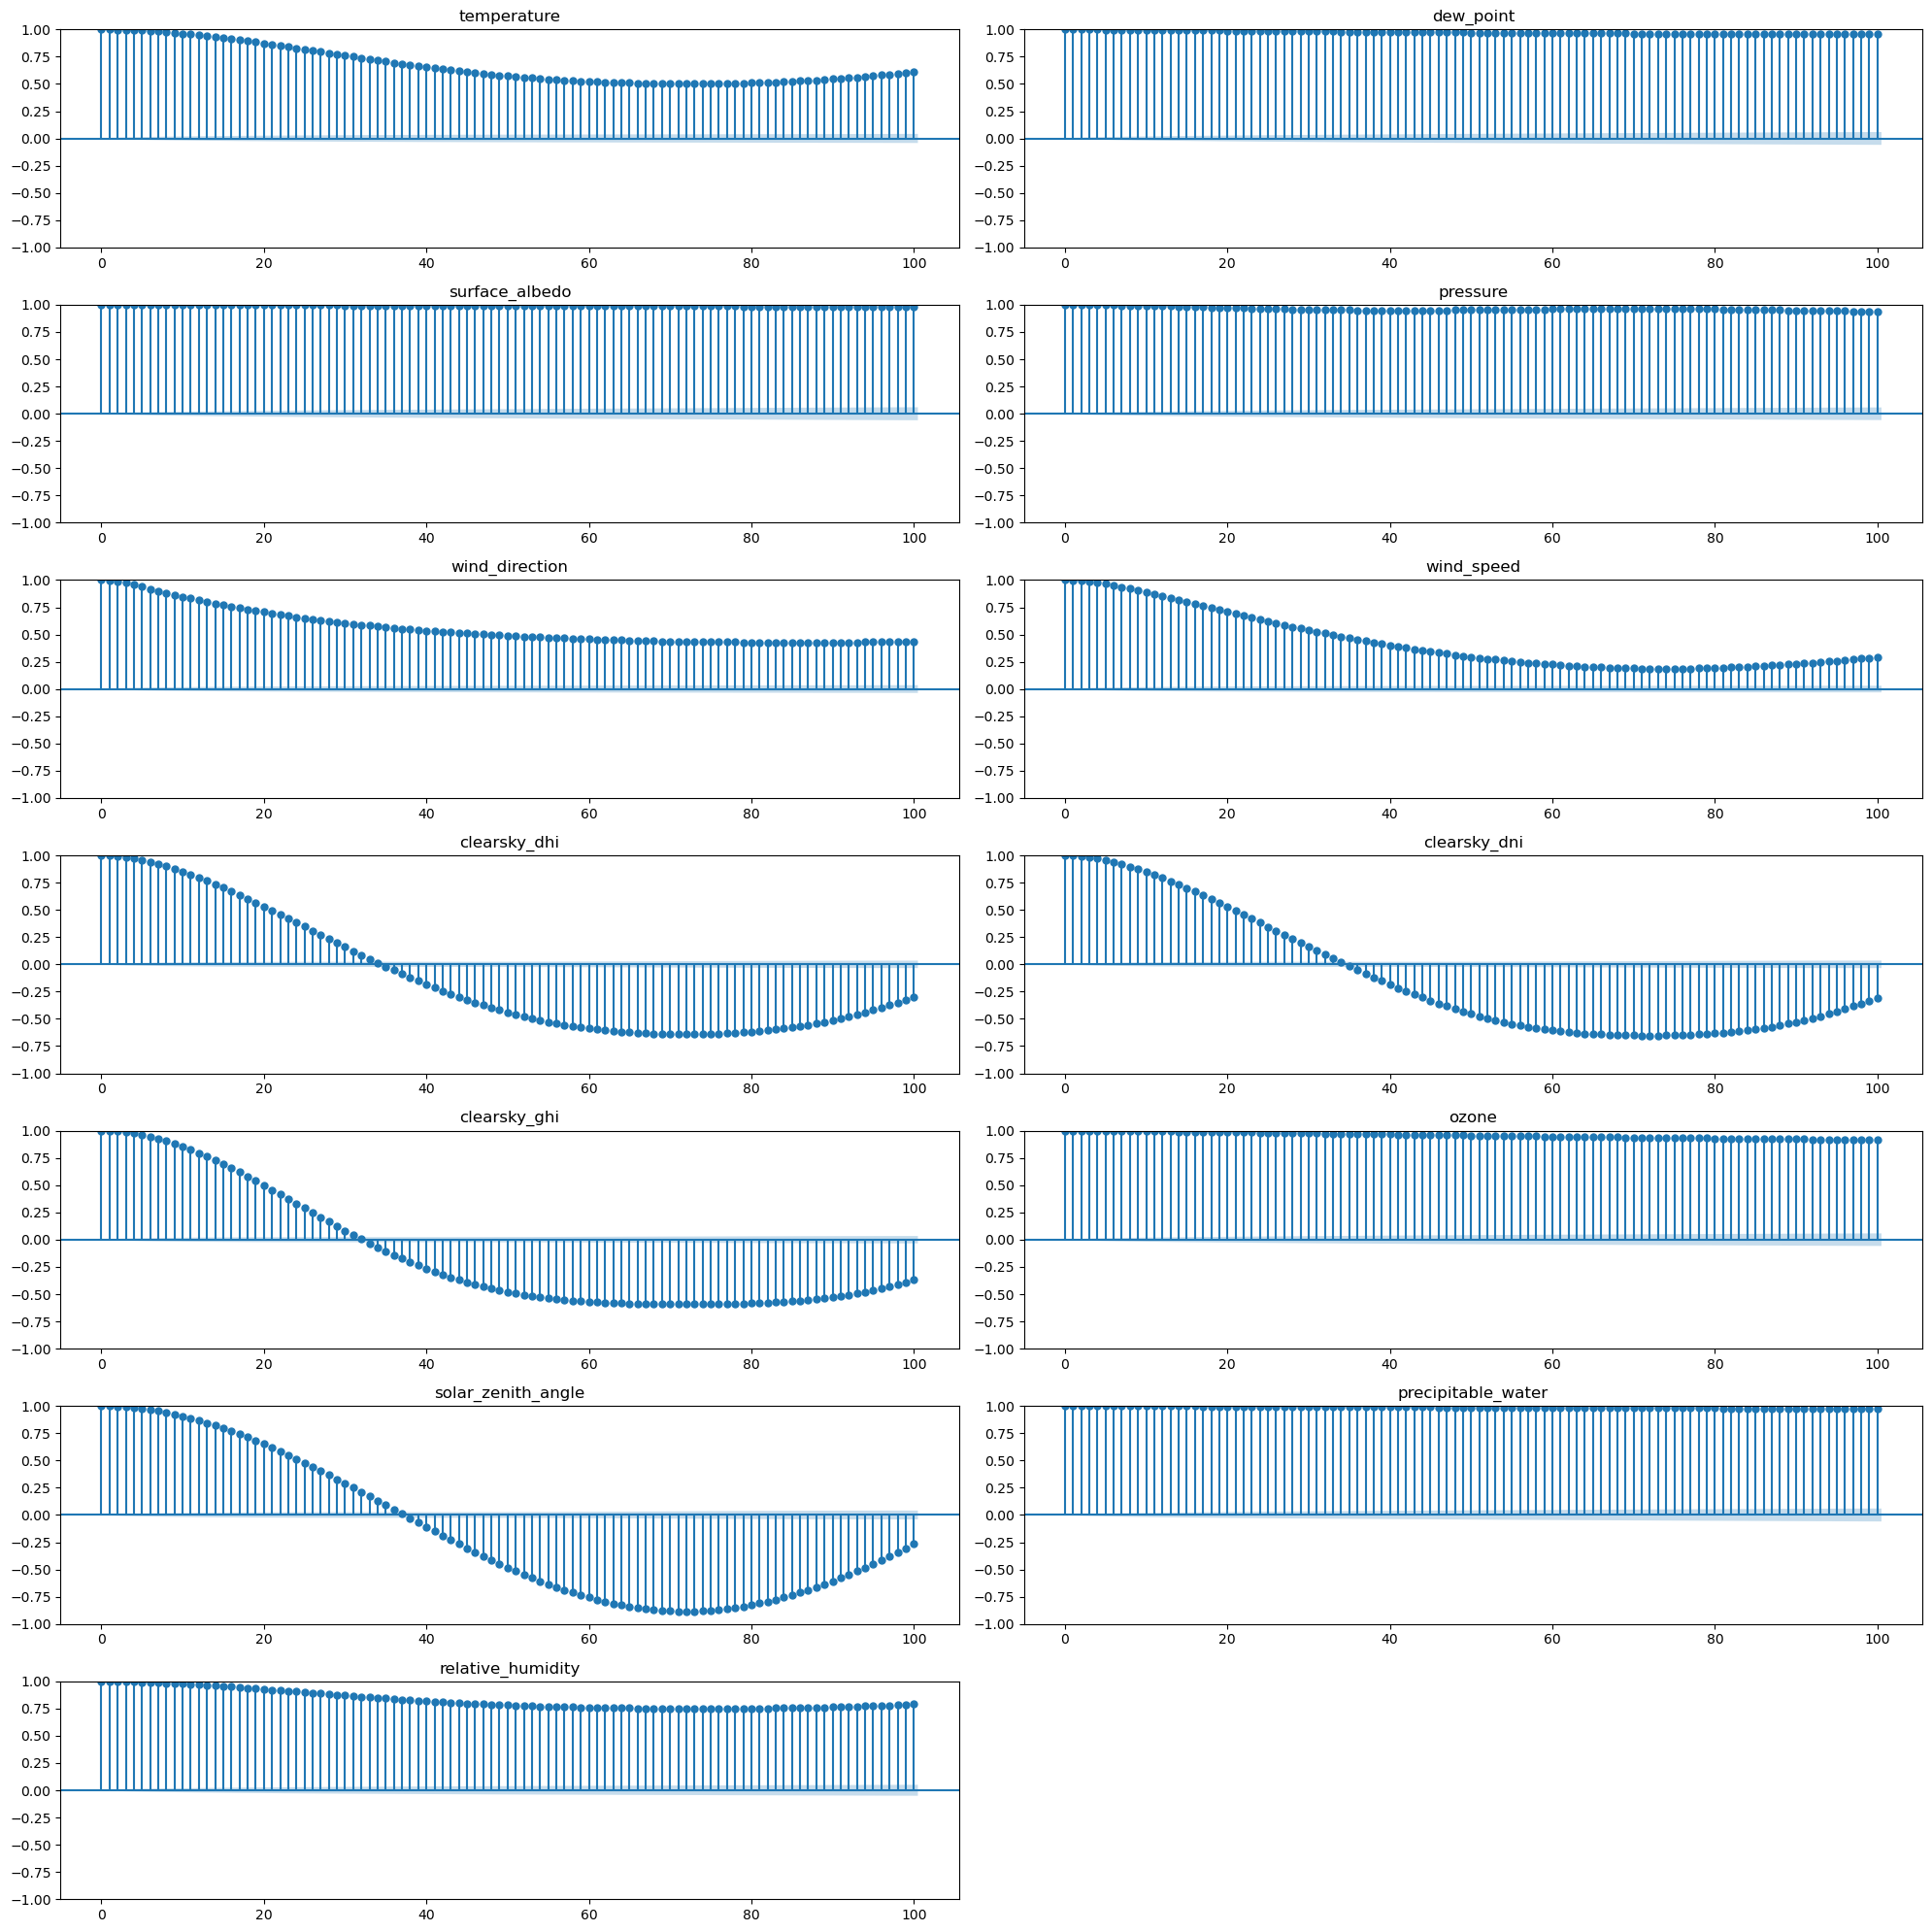

In [106]:
fig=plt.figure(figsize=(20, 20))
for i,col  in enumerate(train.iloc[:,np.r_[1:10,11,13:16]].columns):    
    ax1=fig.add_subplot(7,2,i+1)
    df2=train[['date_time',col]]
    df2.set_index('date_time',inplace=True)
    fig=plot_acf(df2[col],lags=100,ax=ax1,) #
    plt.title(col)
    plt.tight_layout() 

#### The above acf plot explains that the metrological features present values are highly correlated with previous vlaues.

### Pacf plot

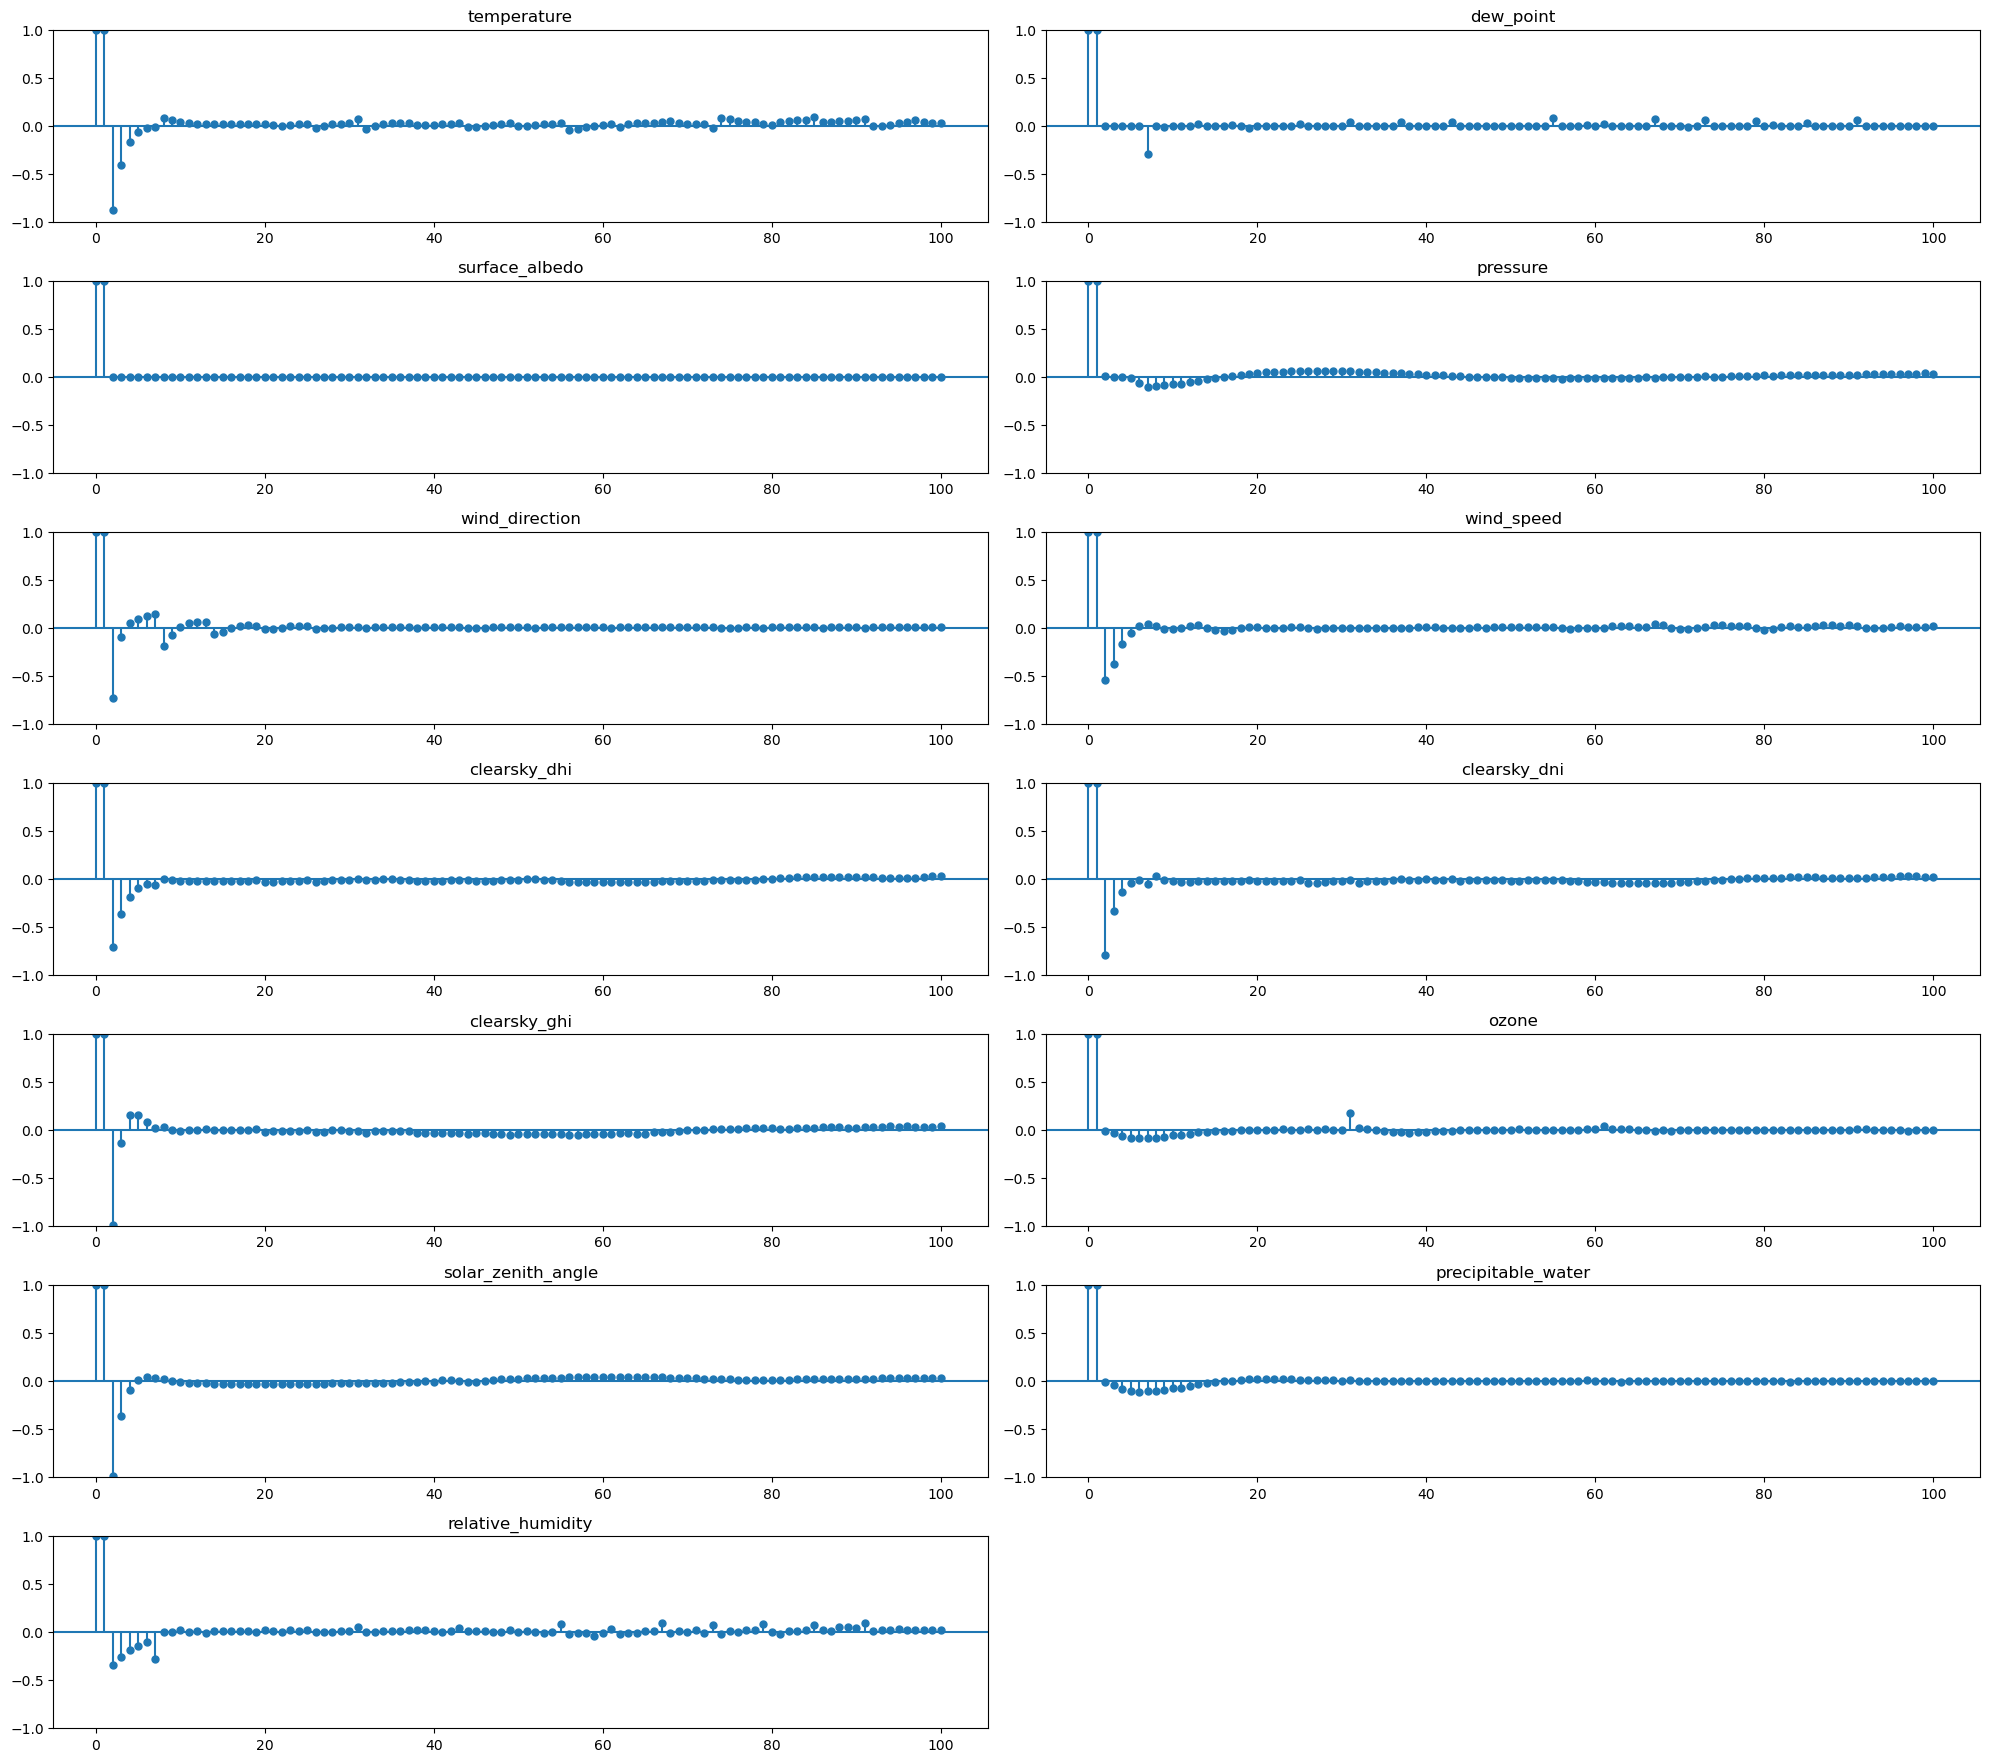

In [107]:
fig=plt.figure(figsize=(20, 20))
for i,col  in enumerate(train.iloc[:,np.r_[1:10,11,13:16]].columns):    
    ax1=fig.add_subplot(8,2,i+1)
    df2=train[['date',col]]
    df2.set_index('date',inplace=True) 
    fig=plot_pacf(df2[col], lags=100,ax=ax1) #
    plt.title(col)
    plt.tight_layout() 

#### The pacf plot explains the correlation between the time series and its lagged values after controlling for the effects of intermediate lags.

### Clearsky_DHI

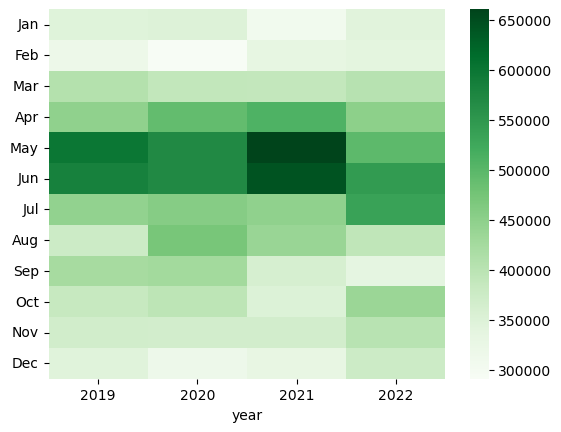

In [108]:
months=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
sns.heatmap(train.pivot_table(index="month_number",
                              columns="year",
                              values="clearsky_dhi",
                              aggfunc="sum").set_index(pd.Index(months)),cmap='Greens');
plt.yticks(rotation=0);

#### The highest clearsky_dhi was recorded in the month of May and June '2021.

#### From the year 2019 to 2021 the highest clearsky_dhi was recorded in the month of May and June. This pattern changed in the year 2022.

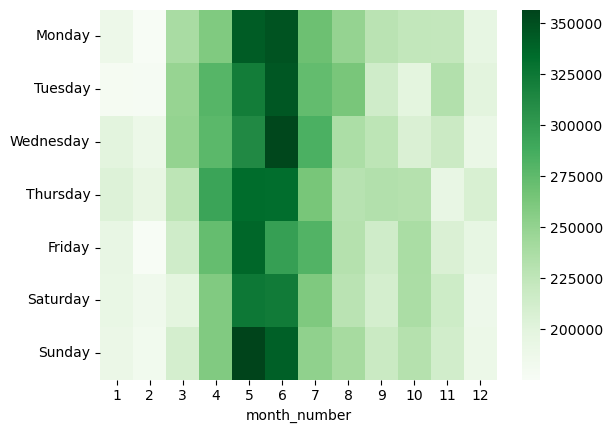

In [109]:
sns.heatmap(train.pivot_table(index="day_number",
                              columns="month_number",
                              values="clearsky_dhi",
                              aggfunc="sum").set_index(pd.Index(['Monday','Tuesday',
                                                                 'Wednesday', 'Thursday', 
                                                                 'Friday', 'Saturday', 
                                                                 'Sunday'])),cmap='Greens');
plt.yticks(rotation=0);

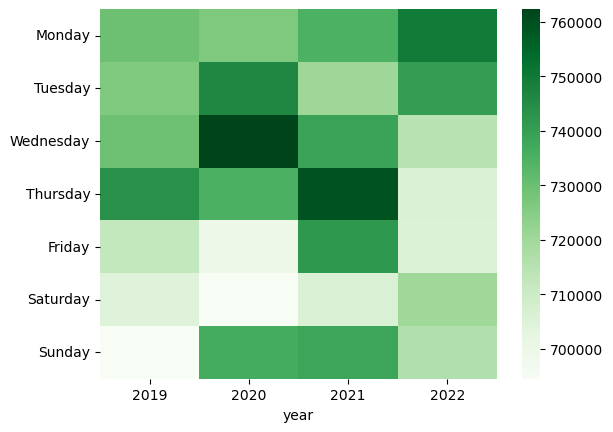

In [110]:
sns.heatmap(train.pivot_table(index="day_number",
                              columns="year",
                              values="clearsky_dhi",
                              aggfunc="sum").set_index(pd.Index(['Monday','Tuesday',
                                                                 'Wednesday', 'Thursday', 
                                                                 'Friday', 'Saturday',
                                                                 'Sunday'])),
                                                                   cmap='Greens');
plt.yticks(rotation=0);

#### From the year 2019 to 2022, the highest clear_dhi was recorded on the day from Monday to Thursday.

### Clearsky_DNI

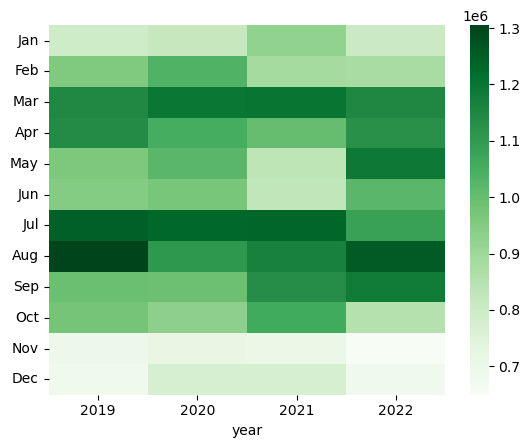

In [111]:
months=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
sns.heatmap(train.pivot_table(index="month_number",
                              columns="year",
                              values="clearsky_dni",
                              aggfunc="sum").set_index(pd.Index(months)),cmap='Greens');
plt.yticks(rotation=0);

#### The highest clearsky_dni was recorded in the month of June, July, and August '2019.

#### From the year 2019 to 2021 the highest clearsky_dni was recorded in the month of March, May, July and August.

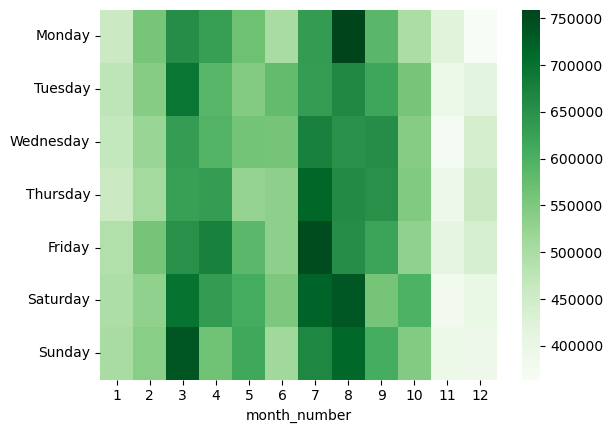

In [112]:
sns.heatmap(train.pivot_table(index="day_number",
                              columns="month_number",
                              values="clearsky_dni",
                              aggfunc="sum").set_index(pd.Index(['Monday','Tuesday',
                                                                 'Wednesday', 'Thursday', 
                                                                 'Friday', 'Saturday', 
                                                                 'Sunday'])),cmap='Greens');
plt.yticks(rotation=0);

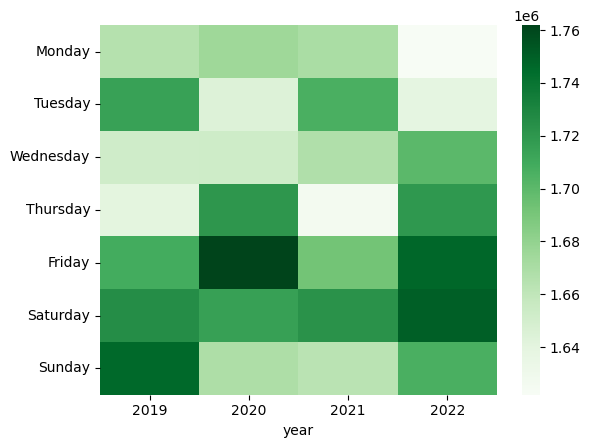

In [113]:
sns.heatmap(train.pivot_table(index="day_number",
                              columns="year",
                              values="clearsky_dni",
                              aggfunc="sum").set_index(pd.Index(['Monday','Tuesday',
                                                                 'Wednesday', 'Thursday', 
                                                                 'Friday', 'Saturday',
                                                                 'Sunday'])),
                                                                   cmap='Greens');

#### From the year 2019 to 2022, the highest clear_dni was recorded on the day from Thursday to Sunday.


### Clearsky_GHI

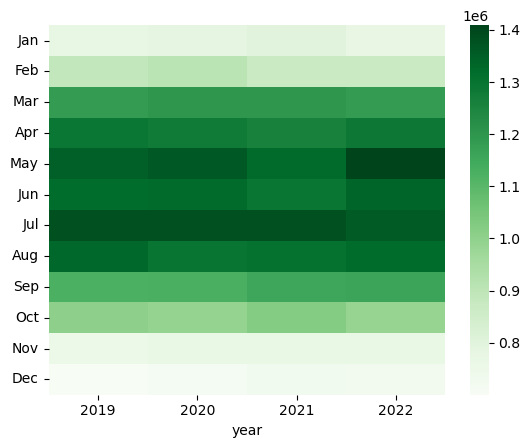

In [114]:
months=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
sns.heatmap(train.pivot_table(index="month_number",
                              columns="year",
                              values="clearsky_ghi",
                              aggfunc="sum").set_index(pd.Index(months)),cmap='Greens');
plt.yticks(rotation=0);

#### The highest clearsky_ghi was recorded in the month of May, and July '2019.

#### From the year 2019 to 2021 the highest clearsky_ghi was recorded in the month of May, and July.

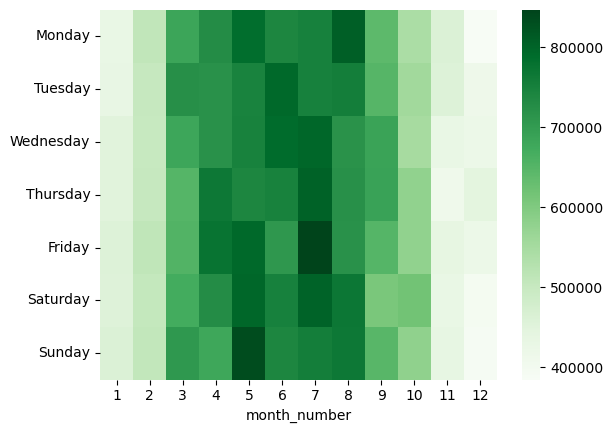

In [115]:
sns.heatmap(train.pivot_table(index="day_number",
                              columns="month_number",
                              values="clearsky_ghi",
                              aggfunc="sum").set_index(pd.Index(['Monday','Tuesday',
                                                                 'Wednesday', 'Thursday', 
                                                                 'Friday', 'Saturday', 
                                                                 'Sunday'])),cmap='Greens');
plt.yticks(rotation=0);

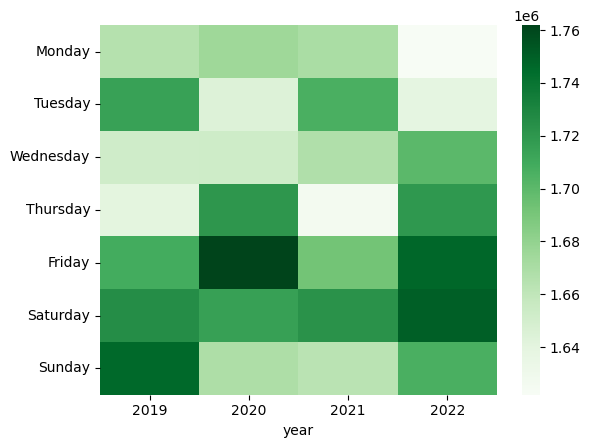

In [116]:
sns.heatmap(train.pivot_table(index="day_number",
                              columns="year",
                              values="clearsky_dni",
                              aggfunc="sum").set_index(pd.Index(['Monday','Tuesday',
                                                                 'Wednesday', 'Thursday', 
                                                                 'Friday', 'Saturday',
                                                                 'Sunday'])),
                                                                   cmap='Greens');
plt.yticks(rotation=0);

#### From the year 2019 to 2022, the highest clear_ghi was recorded on the day from Thursday to Sunday.

